# Easy Visa

## Problem Statement

**Context**

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

**Objective**:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You as a data scientist at EasyVisa have to analyze the data provided and, with the help of a classification model:

Facilitate the process of visa approvals.
Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

**Data Description**

The data contains the different attributes of employee and the employer. The detailed data dictionary is given below.

- **case_id**: ID of each visa application
- **continent**: Information of continent the employee
- **education_of_employee**: Information of education of the employee
- **has_job_experience**: Does the employee has any job experience? Y= Yes; N = No
- **requires_job_training**: Does the employee require any job training? Y = Yes; N = No
- **no_of_employees**: Number of employees in the employer's company
- **yr_of_estab**: Year in which the employer's company was established
- **region_of_employment**: Information of foreign worker's intended region of employment in the US.
- **full_time_position**: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
- **unit_of_wage**: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
- **prevailing_wage**: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
- **case_status**: Flag indicating if the Visa was certified or denied

**BirdEye** 👀

It consists of visa application records with features related to the employee (e.g., education, experience), the employer (e.g., company size, establishment year), job details (e.g., wage, employment region), and the final case status (certified or denied)

*Goal (Brief)*

This problem aims to predict the **approval** or **denial** of a U.S. work visa application based on various factors related to the employee and employer. Given the increasing number of visa applications, manually reviewing each case is becoming inefficient. Hence need a machine learning (ML) model that can help automate and streamline the decision-making process.

This is a classification problem, where the target variable (case_status) has two possible outcomes:

- Certified (Visa Approved)
- Denied (Visa Rejected)


**Key Questions that can be answered** 🎯

1. What factors influence visa approval the most?
2. Do certain types of applicants have a better chance of approval?
3. Does salary or wage type affect visa approval?
4. Do bigger or older companies have an advantage?

## Data background and Contents


The dataset contains 11 columns, including:  

- **Employee details**: Continent, Education, Job Experience, Job Training  
- **Employer details**: Number of Employees, Year of Establishment  
- **Job attributes**: Region of Employment, Prevailing Wage, Wage Unit, Full-time Position  
- **Target variable**: Case Status (Certified or Denied)  

The model will analyze historical visa application data and learn patterns that distinguish approved cases from rejected ones.

**Key Features (Predictors)**  
1. **Employee attributes:**  
   - Education level  
   - Job experience  
   - Job training requirements  

2. **Employer attributes:**  
   - Number of employees  
   - Year of establishment  

3. **Job & wage details:**  
   - Region of employment  
   - Prevailing wage & wage unit (Hourly, Weekly, etc.)  
   - Full-time or part-time position  

### Preparation

In [1]:
# verify
import sys
print(sys.executable, sys.version)

/Users/nipunshah/anaconda3/bin/python 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


NOTE: If using Jupyter Notebook then consider below versions for 

- scikit-learn              **1.2.2**
- imbalanced-learn          0.10.1

due to some discrepancies

In [304]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate as tb
from statsmodels.graphics.mosaicplot import mosaic

from scipy.stats import chi2_contingency, zscore
from scipy.stats import randint, uniform

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# Suppress warnings
import warnings
warnings.filterwarnings('ignore') # Ignores all warnings (optional)

In [208]:
# other imports
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
# Global options and themes

# Set pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Show 100 rows by default

# Seaborn theme for consistent plotting style
sns.set_theme(style="whitegrid", palette="muted", context="notebook")  # You can change it to darkgrid, ticks, etc.
plt.rcParams["figure.figsize"] = (15, 6)  # Set default figure size for plots
plt.rcParams["font.size"] = 14            # Set font size for readability

# restrict float display to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# Helpers

def tb_describe(df_col):
    """
    Helper function to display descriptive statistics in a nicely formatted table

    Parameters:
    df_col : pandas Series or DataFrame column
        The column to generate descriptive statistics for

    Returns:
    None - prints formatted table
    """
    stats = df_col.describe().to_frame().T
    print(tb.tabulate(stats, headers='keys', tablefmt='simple', floatfmt='.2f'))

In [5]:
# Primitive Utils
def snake_to_pascal(snake_str, join_with=" "):
    """Convert snake_case to PascalCase (eg my_name -> MyName)
    Args:
        snake_str (str): string to convert
        join_with (str): character to join the components, default is space
    """
    components = snake_str.split("_")
    return join_with.join(x.title() for x in components)


def format_pct(val):
    """Format a val as percentage i.e max 2 decimal value & adding % at the end"""
    return f"{val:.1f}%"

def to_percentage(value):
    """value is expected to be a normalized float value in [0, 1]"""
    return format_pct(value * 100)

def calc_iqr(series: pd.Series):
    """
    series: array of numerical values
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR

In [6]:
def draw_countplot(
    df,
    colName: str,
    *,
    label=None,
    rot=0,
    order=None,
    sort=True,
    palette=None,
    showgrid=None,
):
    """
    Draw a count plot with value labels and optional features
    """
    # prep (meta) --
    xlabel = label if label else snake_to_pascal(colName)
    priority = None
    if order is not None:
        priority = order
    elif sort:
        # sort by count
        priority = df[colName].value_counts().index

    # plot (crux) --
    ax = sns.countplot(data=df, x=colName, order=priority, palette=palette)
    # display count above each bar
    ax.bar_label(ax.containers[0])

    # Calculate & mark percentages
    total = len(df[colName])
    for p in ax.patches:
        freq = p.get_height()
        percentage = to_percentage(freq / total)
        ax.annotate(
            percentage,
            (p.get_x() + p.get_width() / 2.0, freq / 2.0),
            ha="center",
            va="center",
        )

    # aesthetics --
    plt.title(f"Frequency of {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.xticks(rotation=rot)
    if showgrid:
        plt.grid(True)
    plt.show()

In [7]:
# list all files in current directory
!ls

EasyVisa.csv   minenotes      notebook.ipynb points         summary


In [8]:
# Load the dataset
df = pd.read_csv('EasyVisa.csv')
# backup of original df
df_original = df.copy()

In [9]:
# Peek the dataset
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.20,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.65,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.86,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.03,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.39,Year,Y,Certified


In [10]:
# Shape (Size)
df.shape

(25480, 12)

🧐 The dataset contains **25,480** visa applications with **12 features**, including employee background, employer details, job specifics, and _visa decision_

In [11]:
# Data Types
df.dtypes


case_id                   object
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
yr_of_estab                int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
case_status               object
dtype: object

🧐 The dataset includes categorical and numerical features, with most columns being categorical (e.g., continent, education, job experience), while no_of_employees, yr_of_estab, and prevailing_wage are numerical.

> Hence we need to perform Categorical Encoding for multiple columns

In [12]:
df.nunique()

case_id                  25480
continent                    6
education_of_employee        4
has_job_experience           2
requires_job_training        2
no_of_employees           7105
yr_of_estab                199
region_of_employment         5
prevailing_wage          25454
unit_of_wage                 4
full_time_position           2
case_status                  2
dtype: int64

> case_id can be excluded as it holds too many values which is nominal in nature !

In [13]:
# Columns Information
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [14]:
# Missing values
missing_values = df.isnull().sum().sum()
missing_values

0

👀 There are **no missing values** in dataset

In [15]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


👀 The dataset has **no duplicate entries**, ensuring each visa application is unique.

In [16]:
# Statistical summary (only numerical columns)
stats = df.describe(include=['int64', 'float64']).T
stats

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.00,5667.04,22877.93,-26.00,1022.00,2109.00,3504.00,602069.00
yr_of_estab,25480.00,1979.41,42.37,1800.00,1976.00,1997.00,2005.00,2016.00
prevailing_wage,25480.00,74455.81,52815.94,2.14,34015.48,70308.21,107735.51,319210.27


Looking at the numbers: 

1. **Company sizes** vary dramatically - from tiny operations to massive corporations with over 600,000 employees. Most companies are mid-sized.
2. **Company age** shows most are established businesses, not startups. The oldest dates back to 1800.
3. **Wages** range from extremely low ($2.14) to very high ($319,210), with most around $70,000. The huge range suggests different job types or possible data errors at the low end.

❗**There are negative values (-26) for no_of_employees, which seem incorrect and may need correction.**

In [17]:
# total application with -ve no_of_employees count
df[df['no_of_employees'] < 0].shape[0]

33

It seems the -ve values may be due to data entry error

In [18]:
df['case_status'].value_counts()

Certified    17018
Denied        8462
Name: case_status, dtype: int64

Focus on recall for the "Denied" class: minimize false negatives (cases where the model predicts "Certified" but the actual outcome was "Denied").

approving someone who should be denied, which has more serious consequences than the opposite error.

## Univariate Analysis (EDA)

#### 1. Continent 
(Categorical - nominal)

In [19]:
df['continent'].describe()

count     25480
unique        6
top        Asia
freq      16861
Name: continent, dtype: object

In [20]:
df['continent'].value_counts()


Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64

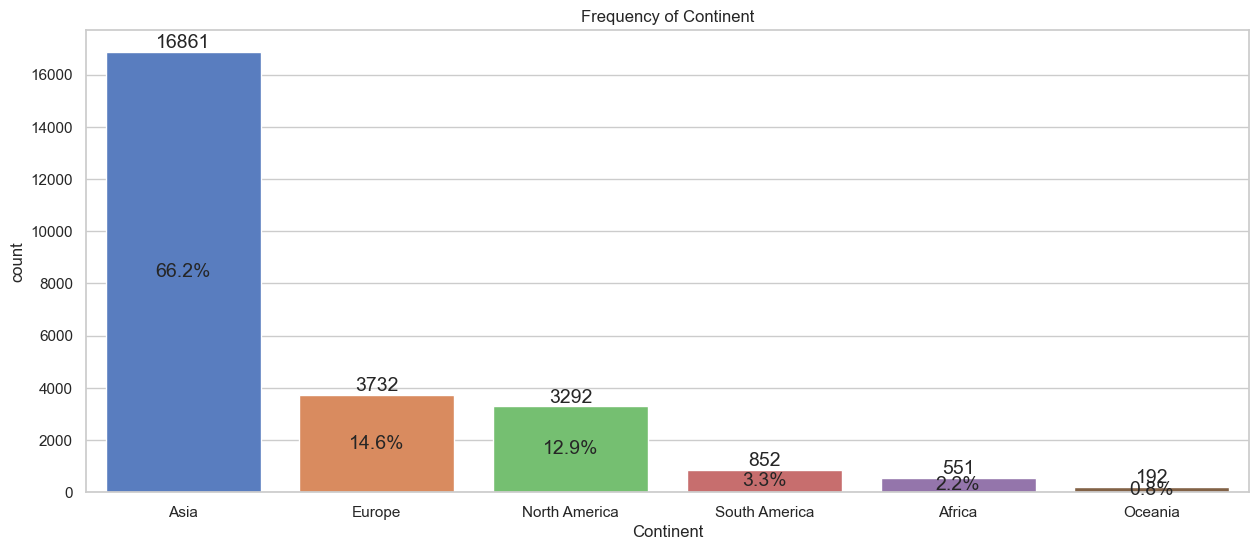

In [21]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'continent', label='Continent')

🔍 Based on the continent distribution shown in your EDA:

1. **Asia dominates applications**: Two-thirds (66.2%) of all visa applications come from Asia, making it by far the largest source of applicants.

2. **Europe and North America follow**: These regions account for 14.6% and 12.9% respectively, forming the second tier of applicants.

3. **Limited representation from other regions**: South America (3.3%), Africa (2.2%), and Oceania (0.8%) contribute relatively few applications.

**For modeling**: The heavy imbalance across continents means tree-based models will have much more data to learn patterns for Asian applicants than for those from smaller regions like Oceania.


#### 2. Education of Employee
(categorical - ordinal)

In [22]:
df['education_of_employee'].describe()

count          25480
unique             4
top       Bachelor's
freq           10234
Name: education_of_employee, dtype: object

In [23]:
df['education_of_employee'].value_counts()

Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64

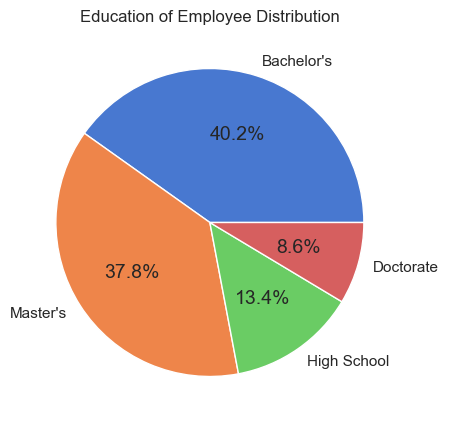

In [24]:
education_counts = df['education_of_employee'].value_counts()
education_counts.plot.pie(autopct='%1.1f%%', figsize=(5, 5))
plt.ylabel('')  # Remove y-label
plt.title('Education of Employee Distribution')
plt.show()

🔍 Based on the education distribution:

1. **Bachelor's and Master's degrees dominate**: These two education levels account for nearly 80% of all applicants (40.2% Bachelor's, 37.8% Master's).

2. **Fewer high school and doctorate applicants**: High school graduates (13.4%) and doctorate holders (8.6%) represent smaller portions of the applicant pool.

3. **Highly educated workforce**: The vast majority (86.6%) of visa applicants have college degrees, indicating employers are primarily seeking skilled, educated workers.

> tree-based models will have substantial data across all education categories, though they may learn more reliable patterns for Bachelor's and Master's degree holders.

#### 3. Has Job Experience
(categorical - binary)

In [25]:
df['has_job_experience'].describe()

count     25480
unique        2
top           Y
freq      14802
Name: has_job_experience, dtype: object

In [26]:
df['has_job_experience'].value_counts()

Y    14802
N    10678
Name: has_job_experience, dtype: int64

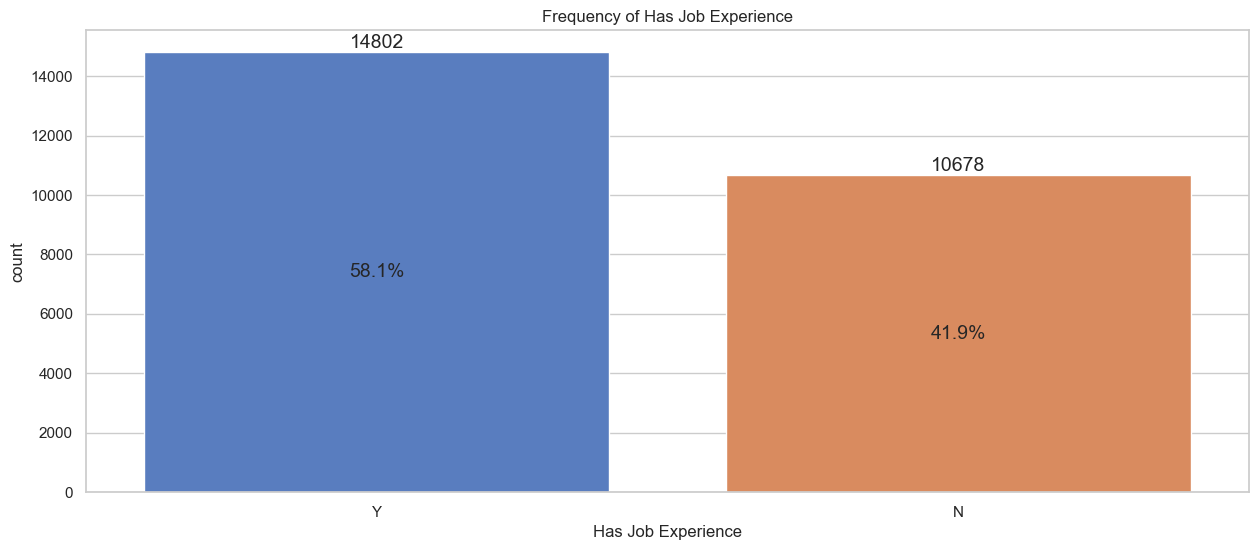

In [27]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'has_job_experience', label='Has Job Experience')

🔍 Based on the job experience distribution:

1. **Experience dominates**: Most applicants (58.1%) have job experience, while a substantial minority (41.9%) do not.

2. **Balanced distribution**: The split between experienced and inexperienced applicants is relatively balanced, with a moderate skew toward experienced workers.

3. **Diverse talent pool**: The significant presence of both experienced and inexperienced applicants suggests visa programs serve both entry-level and experienced positions.

> Your tree-based models will have sufficient data for both experience categories, allowing reliable pattern detection for both groups.

#### 4. Requires Job Training
(categorical - binary)

In [28]:
df['requires_job_training'].describe()

count     25480
unique        2
top           N
freq      22525
Name: requires_job_training, dtype: object

In [29]:
df['requires_job_training'].value_counts()

N    22525
Y     2955
Name: requires_job_training, dtype: int64

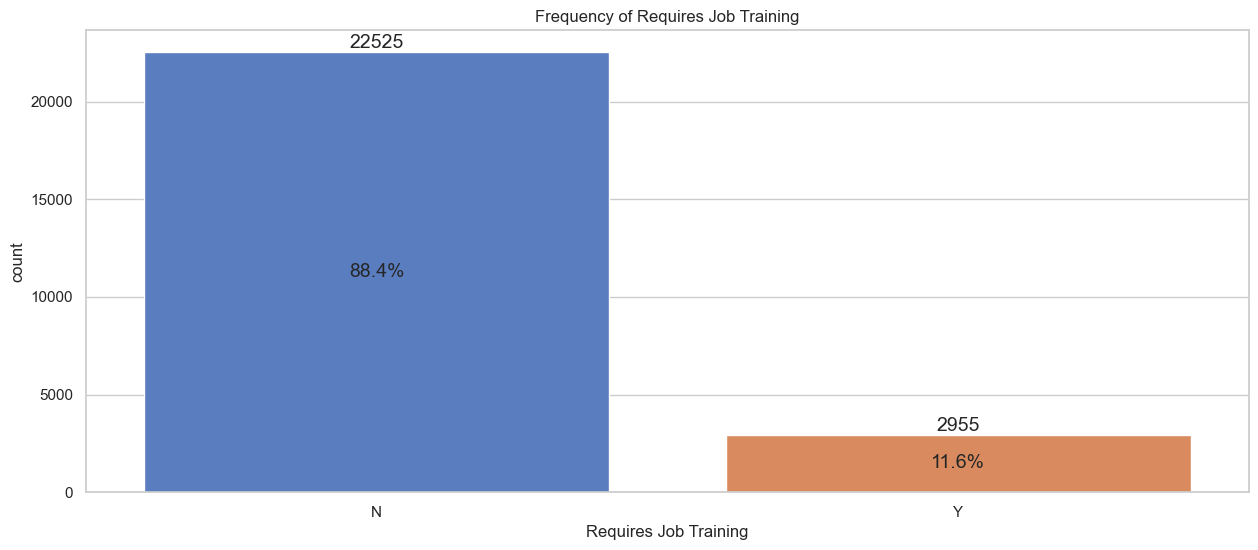

In [30]:
plt.figure(figsize=(15, 6))
draw_countplot(df, 'requires_job_training', label='Requires Job Training')


🔍 Observations : 

1. **Training rarely required**: The vast majority of applicants (88.4%) do not require job training, while only a small portion (11.6%) do.

2. **Strong imbalance**: This feature shows a significant imbalance, with "No training required" being the dominant category by a large margin.

3. **Specialized workforce**: The low need for training suggests most visa applicants already possess the necessary skills for their positions.

> The significant imbalance (88.4% vs 11.6%) means the "requires training" category is rare, which could cause tree-based models to treat it as an outlier or underweight its importance unless it has a very strong signal for visa outcomes.

🧠 **REMEMBER (Trees Point)**: 
1. If category dominates then The tree might split based on it too soon
2. If category is too rare then The tree might overfit to noise

> ⚡ **NOTE**: 
> **Tree doesn't directly prefer dominant categories, but dominance can influence impurity reduction calculations, making it more likely to be picked**


#### 5. Number of Employees
(Numerical)

In [31]:
tb_describe(df['no_of_employees'])

                    count     mean       std     min      25%      50%      75%        max
---------------  --------  -------  --------  ------  -------  -------  -------  ---------
no_of_employees  25480.00  5667.04  22877.93  -26.00  1022.00  2109.00  3504.00  602069.00


In [32]:
print('Skewness : ', df['no_of_employees'].skew())
print('Kurtosis : ', df['no_of_employees'].kurt())


Skewness :  12.265260077708275
Kurtosis :  206.33501961590892


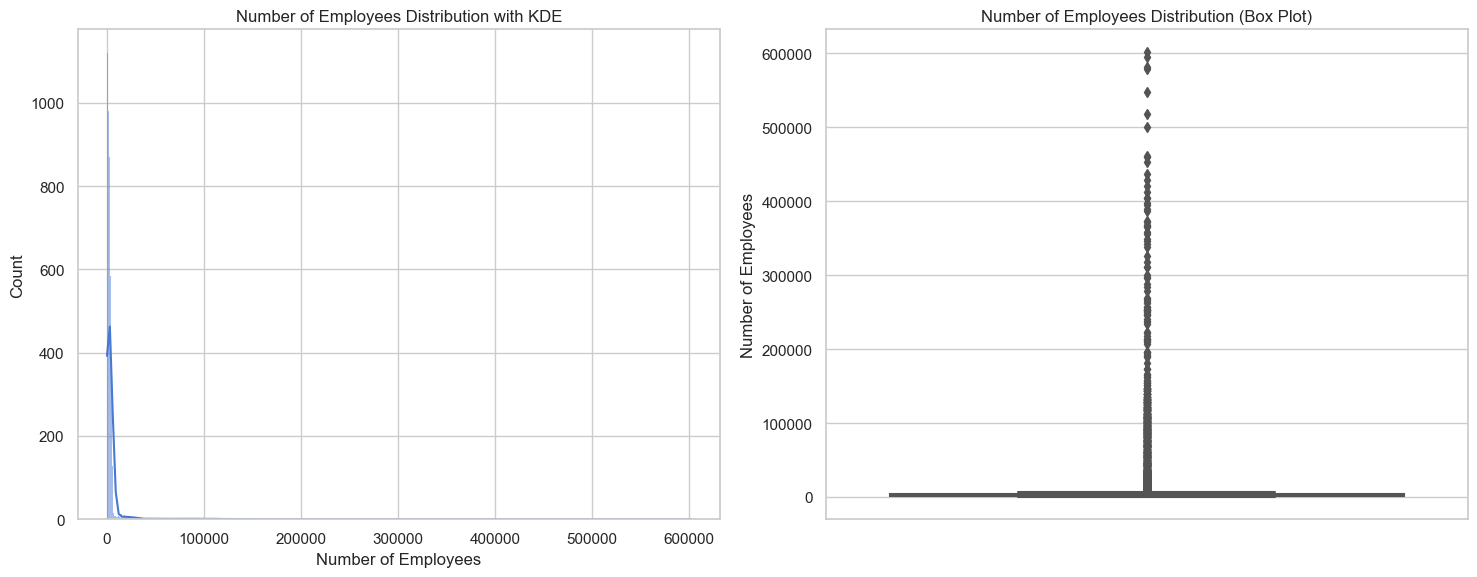

In [33]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot 1: Histogram with KDE
sns.histplot(data=df, x='no_of_employees', kde=True, ax=ax1)
ax1.set_title('Number of Employees Distribution with KDE')
ax1.set_xlabel('Number of Employees')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df['no_of_employees'], ax=ax2)
ax2.set_title('Number of Employees Distribution (Box Plot)')
ax2.set_ylabel('Number of Employees')

plt.tight_layout()
plt.show()

🧐 Observations: 

- Region is very dense & narrow at first glance
- From box plot, it's visible that there are many outliers & values are tightly clustered, so which might make Tree struggle.
- If most values fall within a narrow range, the Decision Tree may struggle to find useful splits because there’s low variance in the feature. (ie **Feature might have low predictive power**)


The extreme skewness (12.26) and kurtosis (206.33) indicate the data is heavily concentrated in a narrow range with many outliers, which could cause a tree-based model to create inefficient splits or overfit to rare values. If most values fall within a narrow range, the Decision Tree may struggle to find useful splits because there's low variance in the feature.


> Might need Binning or Log-Transform to visualize it better

Let's Try **Log-Transform**
- to spread out the compressed values
- Smooths right-skewed data

In [34]:
# check if there are any -ve values
df['no_of_employees'].min()

-26

In [35]:
df['no_of_employees'].value_counts().max()

18

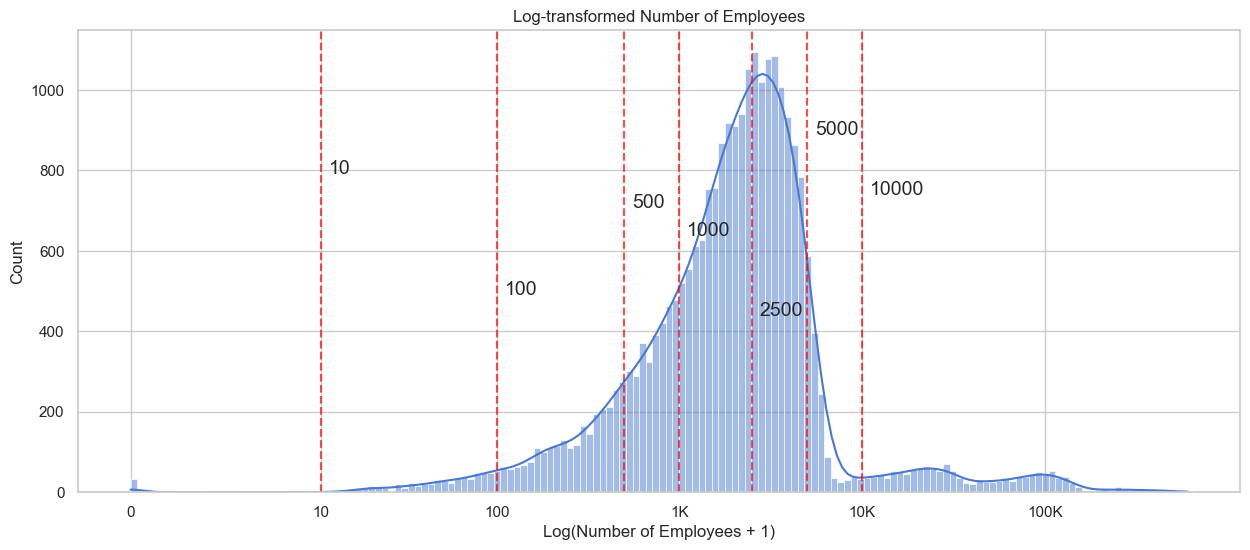

In [36]:
# Log Transformation (Strategy to handle Skewed Data)

plt.figure(figsize=(15, 6))

# Log transformation (adding 1 to handle zeros/negative values)
# NOTE: clip() is used to clip the values to a minimum of 0, as log works only for positive values
log_employees = np.log1p(df['no_of_employees'].clip(lower=0))

# Plot histogram with KDE
sns.histplot(log_employees, kde=True)

# find the reference point for number having highest frequency
df['no_of_employees'].value_counts().idxmax()

# Add reference lines with annotations
reference_points = [10, 100, 500, 1000, 2500, 5000, 10000]
for point in reference_points:
    log_point = np.log1p(point)
    plt.axvline(x=log_point, color='red', linestyle='--', alpha=0.7)
    vertical_offset = np.random.uniform(0.4, 0.9)
    plt.text(log_point + 0.1, plt.ylim()[1]*vertical_offset, f'{point}', verticalalignment='top')

# Customize x-axis ticks to show original values
log_ticks = [np.log1p(x) for x in [0, 10, 100, 1000, 10000, 100000]]
plt.xticks(log_ticks, ['0', '10', '100', '1K', '10K', '100K'])

plt.title('Log-transformed Number of Employees')
plt.xlabel('Log(Number of Employees + 1)')
plt.ylabel('Count')
plt.show()

📌 Points 

- Peaks might represnt potential grouping
- Valleys may suggest natural seperation points

In [37]:
# skewness and kurtosis for log-transformed data
print('Skewness : ', log_employees.skew())
print('Kurtosis : ', log_employees.kurt())

Skewness :  -0.09672037380703381
Kurtosis :  3.7313228285861375


⚡ Based on Log transformed visualization

1. **Bell-shaped distribution after transformation:** The log transformation reveals a nearly normal distribution (skew: -0.09, kurtosis: 3.73), centered between 100-10K employees.
2. **Natural groupings emerge**: several peaks and valleys can be seen, suggesting natural company size categories that could be useful for binning.
3. **Multiple clusters in larger companies**: The right tail shows several smaller peaks, indicating potential sub-groups within large companies (>10K employees).


💡 **Most visa applications come from mid-sized companies (100-10K employees), with fewer applications from very small or very large organizations.**

>🤔 NOTE:
>
> Log transformation is useful for linear models but less necessary for trees

Let's try **Binning**

It Creates meaningful categories that are easy to understand and explain

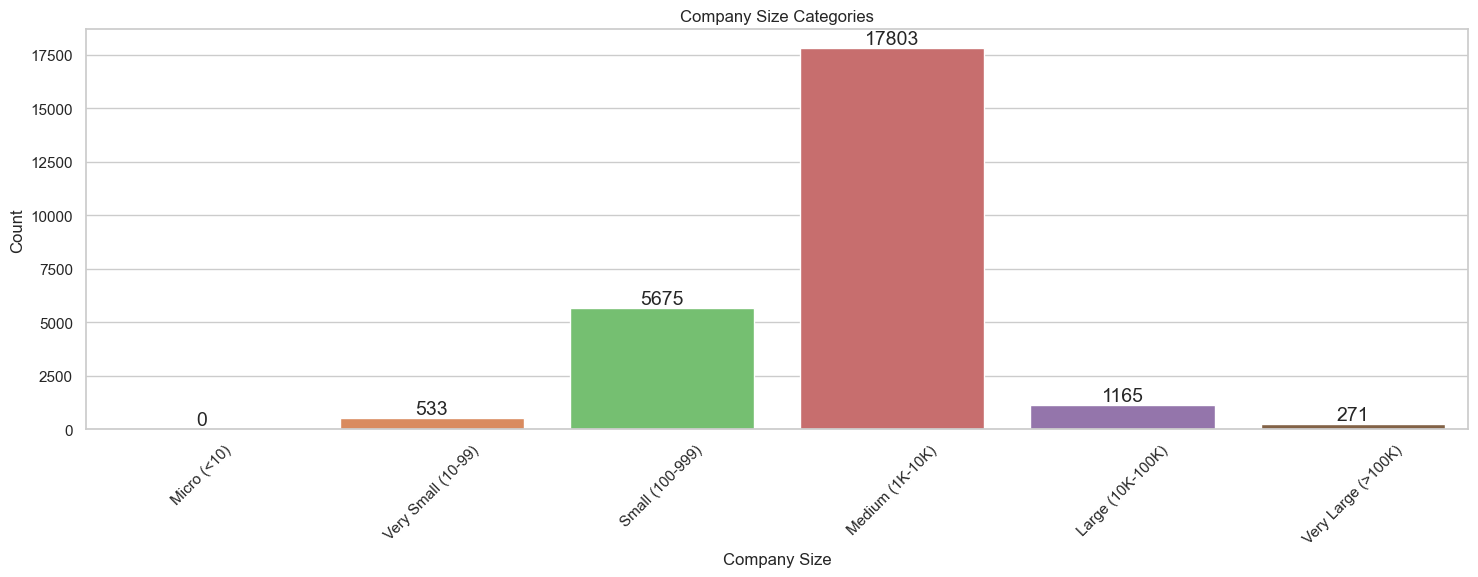

In [38]:
# Binning (Strategy to handle Skewed Data)

# Create company size categories
bins = [0, 10, 100, 1000, 10000, 100000, float("inf")]
labels = [
    "Micro (<10)",
    "Very Small (10-99)",
    "Small (100-999)",
    "Medium (1K-10K)",
    "Large (10K-100K)",
    "Very Large (>100K)",
]

# Create new binned feature
company_size_feature = pd.cut(
    df["no_of_employees"].clip(lower=0), bins=bins, labels=labels
)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=company_size_feature)
plt.title("Company Size Categories")
plt.xlabel("Company Size")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [39]:
company_size_feature.value_counts()

Medium (1K-10K)       17803
Small (100-999)        5675
Large (10K-100K)       1165
Very Small (10-99)      533
Very Large (>100K)      271
Micro (<10)               0
Name: no_of_employees, dtype: int64

In [40]:
company_size_feature.value_counts(normalize=True) * 100

Medium (1K-10K)      69.96
Small (100-999)      22.30
Large (10K-100K)      4.58
Very Small (10-99)    2.09
Very Large (>100K)    1.06
Micro (<10)           0.00
Name: no_of_employees, dtype: float64

In [41]:
pd.crosstab(company_size_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
no_of_employees,,
Very Small (10-99),62.66,37.34
Small (100-999),66.20,33.80
Medium (1K-10K),66.99,33.01
Large (10K-100K),68.07,31.93
Very Large (>100K),70.11,29.89


🔍 Observations : 

1. **Medium-sized companies dominate**: Nearly 70% of visa applications come from medium-sized companies (1K-10K employees), with small companies (100-999) accounting for another 22%.

2. **Very small and very large companies are rare**: Companies with fewer than 100 or more than 10K employees together represent less than 8% of applications.

3. **Approval rates increase with company size**: There's a clear trend where larger companies have higher visa approval rates - from 62.7% for very small companies to 70.1% for very large companies.

🚀 **Business insight**: Larger companies appear more successful at navigating the visa process, possibly due to more resources, experience with immigration procedures, or stronger business cases.

🤔 **Company size** shows a meaningful relationship with the target variable, making it likely to be an important feature in your tree-based models.

> Hence a new column ie CompanySize can be cooked during preprocessing (if possible)


#### 6. Year of Establishment
(numerical)

In [42]:
colname = 'yr_of_estab'

In [43]:
tb_describe(df[colname])

                count     mean    std      min      25%      50%      75%      max
-----------  --------  -------  -----  -------  -------  -------  -------  -------
yr_of_estab  25480.00  1979.41  42.37  1800.00  1976.00  1997.00  2005.00  2016.00


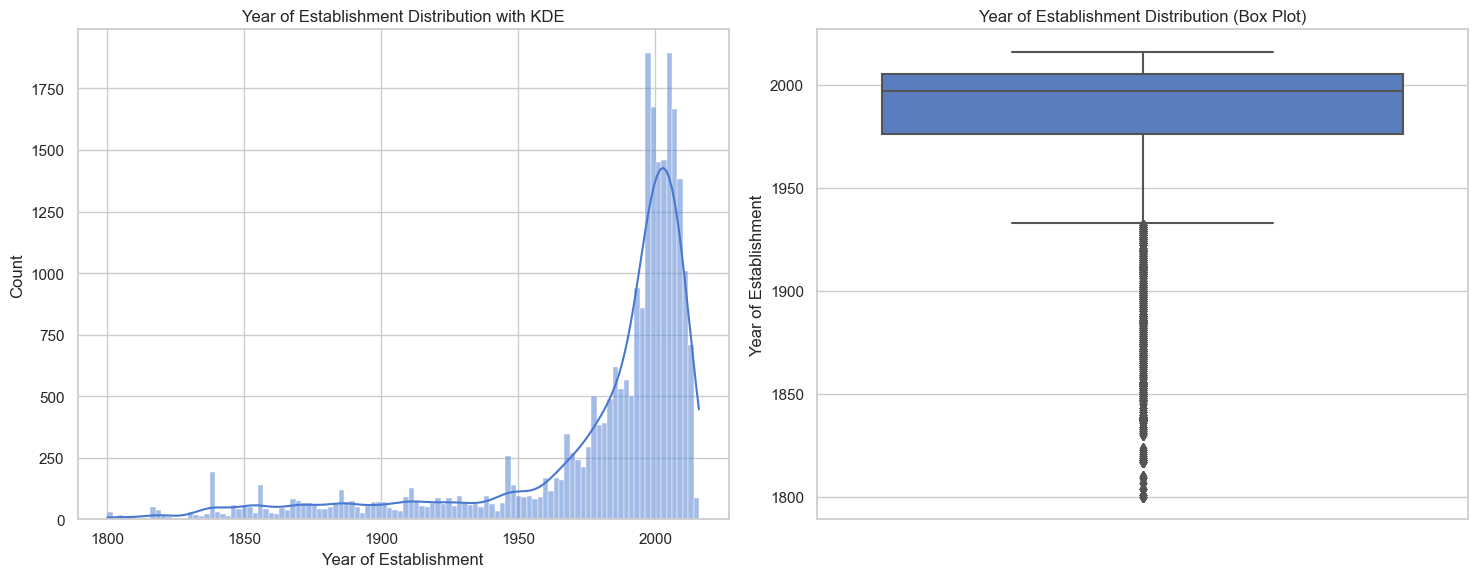

In [44]:
# Histogram and Box Plot
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot 1: Histogram with KDE
sns.histplot(data=df, x=colname, kde=True, ax=ax1)
ax1.set_title('Year of Establishment Distribution with KDE')
ax1.set_xlabel('Year of Establishment')
ax1.set_ylabel('Count')

# Plot 2: Box Plot
sns.boxplot(y=df[colname], ax=ax2)
ax2.set_title('Year of Establishment Distribution (Box Plot)')
ax2.set_ylabel('Year of Establishment')

plt.tight_layout()
plt.show()

> The distribution is reasonably interpretable

In [45]:
# Skewness and Kurtosis
print('Skewness : ', df[colname].skew())
print('Kurtosis : ', df[colname].kurt())


Skewness :  -2.037301271676438
Kurtosis :  3.506956756052395


🔍 Observations 

1. **Left-skewed distribution**: Most companies are relatively newer.

2. **Outliers on the left**: The box plot shows many outliers on the lower end, representing very old companies established well before the majority.

3. **Business insight**: Most visa applications come from companies established in recent decades, with fewer from very old companies.
   
4. **Bell-shaped region focus**: Most splits will likely occur in the dense 1950-2000 region where most companies fall, potentially finding meaningful thresholds like pre/post-1980.


⚡ Points 

The data shows that as years progress, more companies in the dataset were established, with a concentration of companies founded in recent decades. This reflects both the general growth in business formation over time and possibly a higher likelihood of newer companies seeking foreign workers through visa applications.

🧐 **Potential insight**: The model might discover that very old companies (e.g., established before 1900) have different approval patterns than modern companies.

💡 NOTE: 

1. Trees are invariant to monotonic transformations
2. They handle skewed distributions and outliers naturally
3. They make splits based on rank ordering, not absolute values

**Ensemble advantage**: Ensemble methods like Random Forest will reduce the impact of outlier-based splits through averaging multiple trees.


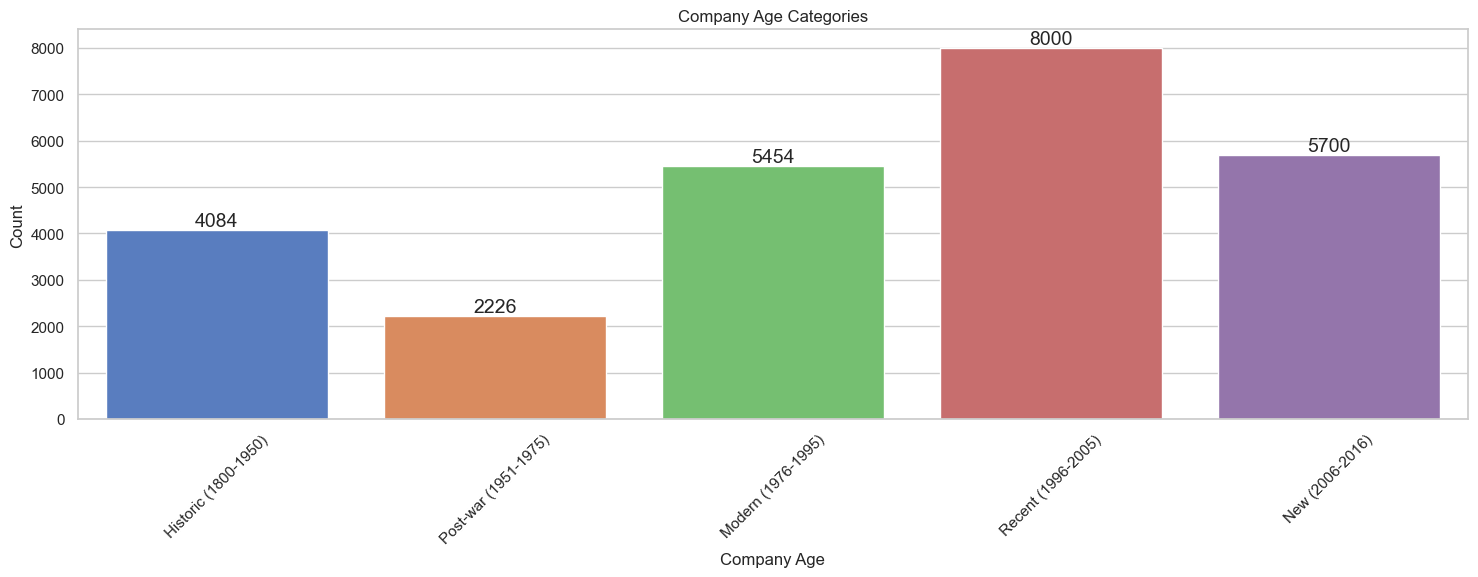

In [46]:
# Binning (Strategy to handle Skewed Data)

# Create company age categories
bins = [1800, 1950, 1975, 1995, 2005, 2016]
labels = ['Historic (1800-1950)', 'Post-war (1951-1975)',
          'Modern (1976-1995)', 'Recent (1996-2005)',
          'New (2006-2016)']

# Create new binned feature
company_age_feature = pd.cut(df['yr_of_estab'],
                                   bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=company_age_feature)
plt.title('Company Age Categories')
plt.xlabel('Company Age')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [47]:
company_age_feature.value_counts()

Recent (1996-2005)      8000
New (2006-2016)         5700
Modern (1976-1995)      5454
Historic (1800-1950)    4084
Post-war (1951-1975)    2226
Name: yr_of_estab, dtype: int64

In [48]:
company_age_feature.value_counts(normalize=True) * 100

Recent (1996-2005)     31.42
New (2006-2016)        22.38
Modern (1976-1995)     21.42
Historic (1800-1950)   16.04
Post-war (1951-1975)    8.74
Name: yr_of_estab, dtype: float64

In [49]:
pd.crosstab(company_age_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
yr_of_estab,,
Historic (1800-1950),66.19,33.81
Post-war (1951-1975),66.62,33.38
Modern (1976-1995),65.44,34.56
Recent (1996-2005),66.04,33.96
New (2006-2016),69.63,30.37


🔍 Observations:

1. **Recent companies dominate**: Companies established between 1996-2005 form the largest group (31.4%), followed by new companies from 2006-2016 (22.4%).

2. **Even distribution across eras**: The remaining companies are fairly evenly distributed across Modern (21.4%) and Historic (16.0%) periods, with fewer from the Post-war era (8.7%).

3. **Newer companies have higher approval rates**: Companies established after 2005 have notably higher approval rates (69.6%) compared to companies from other eras (65-66%).

4. **Consistent denial rates for older companies**: Companies established before 2006 show remarkably consistent denial rates (33-35%), suggesting age isn't a major factor among established companies.

💡 **Business insight**: The data suggests newer companies might have advantages in the visa process, possibly due to being in growing industries or having more modern business practices.

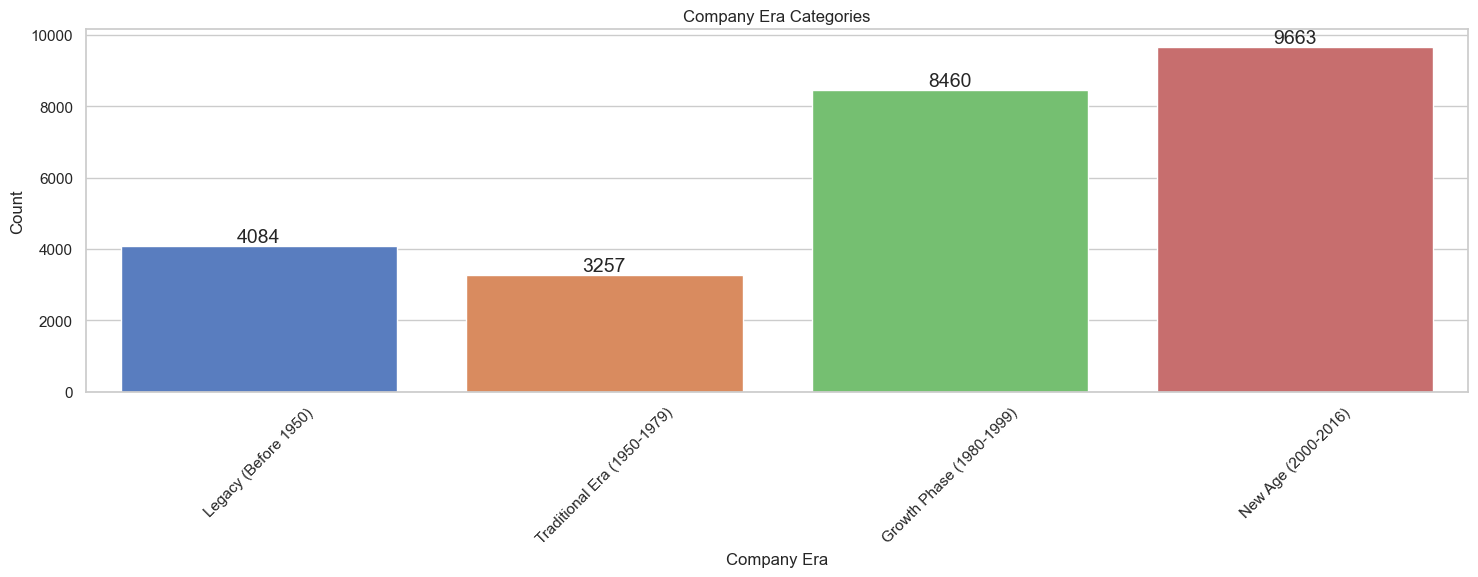

In [50]:
# Binning (Strategy to handle Skewed Data)

# Create company age categories
bins = [1800, 1950, 1980, 2000, 2016]
labels = [
    "Legacy (Before 1950)",
    "Traditional Era (1950-1979)",
    "Growth Phase (1980-1999)",
    "New Age (2000-2016)",
]

# Create new binned feature
company_era_feature = pd.cut(df["yr_of_estab"], bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=company_era_feature)
plt.title("Company Era Categories")
plt.xlabel("Company Era")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

In [51]:
company_era_feature.value_counts()

New Age (2000-2016)            9663
Growth Phase (1980-1999)       8460
Legacy (Before 1950)           4084
Traditional Era (1950-1979)    3257
Name: yr_of_estab, dtype: int64

In [52]:
company_era_feature.value_counts(normalize=True) * 100

New Age (2000-2016)           37.95
Growth Phase (1980-1999)      33.22
Legacy (Before 1950)          16.04
Traditional Era (1950-1979)   12.79
Name: yr_of_estab, dtype: float64

In [53]:
pd.crosstab(company_era_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
yr_of_estab,,
Legacy (Before 1950),66.19,33.81
Traditional Era (1950-1979),66.50,33.50
Growth Phase (1980-1999),65.51,34.49
New Age (2000-2016),68.26,31.74


🔍 Points

Both analyses reveal similar patterns

1. Modern companies dominate
2. New Age companies have highest approval rates
3. Little difference in visa outcomes among established companies

#### 7 Region of Employment
(Categorical - Nominal)

In [54]:
coname = 'region_of_employment'

In [55]:
df[coname].describe()

count         25480
unique            5
top       Northeast
freq           7195
Name: region_of_employment, dtype: object

In [56]:
df[coname].value_counts()

Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: region_of_employment, dtype: int64

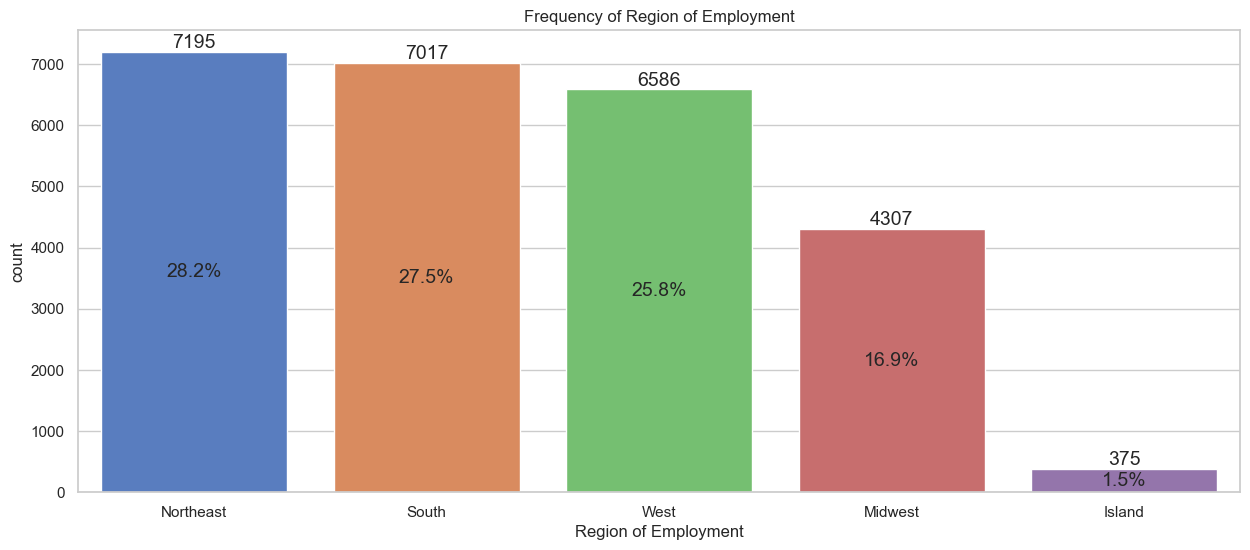

In [57]:
plt.figure(figsize=(15, 6))
draw_countplot(df, coname, label='Region of Employment')

🔍 Observations: 

1. **Balanced distribution across major regions**: Northeast (28.2%), South (27.5%), and West (25.8%) have similar representation, with Midwest slightly lower (16.9%).

2. **Island region is rare**: The Island region represents only 1.5% of applications, making it a minority class.

3. **Coastal dominance**: Coastal regions (Northeast and West) together account for over half of all visa applications, reflecting the concentration of industries that typically hire foreign workers.

4. **Business implications**: Visa processing resources might need to be allocated proportionally across regions, with special consideration for the unique needs of the Island region.

💡 **For modeling**: The significant imbalance with the Island region means tree-based models might have less reliable patterns for this region unless they show very distinct approval patterns.


#### 8. Prevailing Wage (Wage Paid Similalry)
(Numerical)

>  wage paid to similarly employed workers in the same occupation and area

In [58]:
colname = 'prevailing_wage'

In [59]:
tb_describe(df[colname])

                    count      mean       std    min       25%       50%        75%        max
---------------  --------  --------  --------  -----  --------  --------  ---------  ---------
prevailing_wage  25480.00  74455.81  52815.94   2.14  34015.48  70308.21  107735.51  319210.27


In [60]:
# Skewness and Kurtosis
print('Skewness : ', df[colname].skew())
print('Kurtosis : ', df[colname].kurt())


Skewness :  0.7557760603032042
Kurtosis :  0.824273521052552


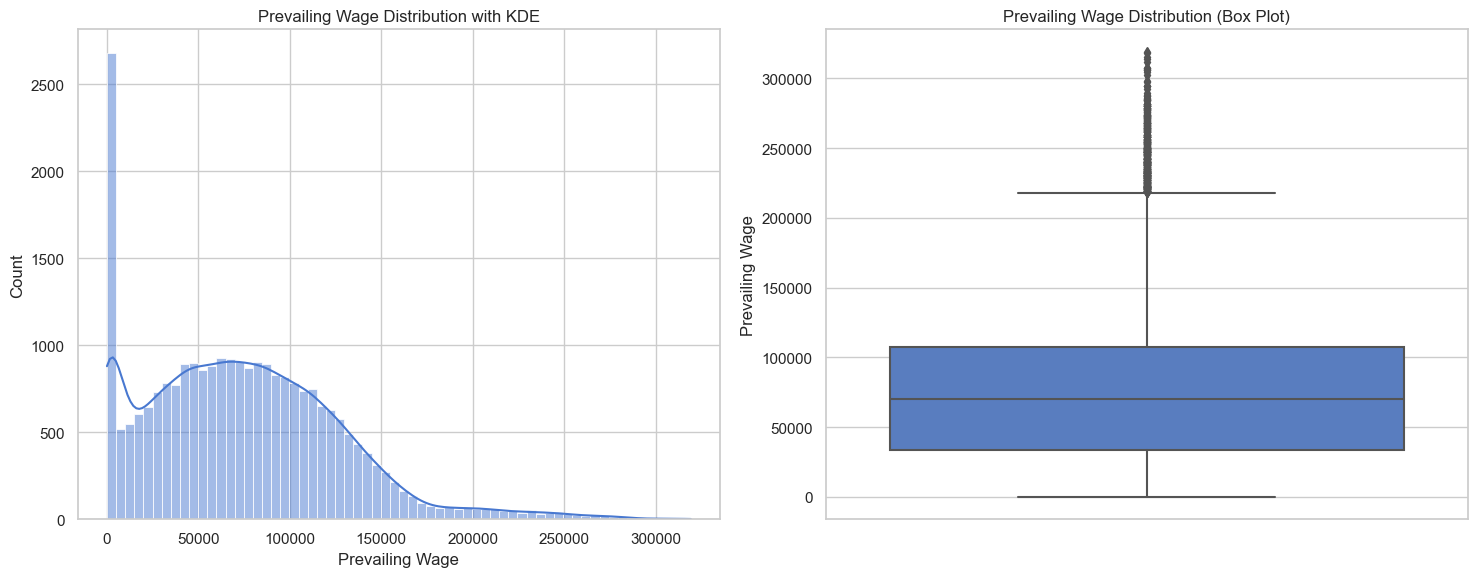

In [61]:
# Histogram and Box Plot
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(data=df, x=colname, kde=True, ax=ax1)
ax1.set_title('Prevailing Wage Distribution with KDE')
ax1.set_xlabel('Prevailing Wage')
ax1.set_ylabel('Count')

sns.boxplot(y=df[colname], ax=ax2)
ax2.set_title('Prevailing Wage Distribution (Box Plot)')
ax2.set_ylabel('Prevailing Wage')
plt.tight_layout()
plt.show()

⚡ Points

1. The distribution is already reasonably bell-shaped & at first glance appears like SNAIL with long TAIL
2. Right skewed but not extreme (many outliers on end)
3. There are few valleys, one on left (neck) and one on right (tail)

🔍 Observations: 

1. **Natural wage thresholds**: The valleys represent transition points between different salary tiers in the labor market.

2. **Distinct job categories**: Each peak likely represents a different job category or skill level - entry-level positions (left peak), professional roles (middle peak), and specialized/executive positions (right peak).

3. **Potential splitting points**: These valleys are natural points where a decision tree might create splits, as they represent meaningful transitions in the wage structure.

4. **Market segmentation**: The labor market naturally segments into these wage bands, reflecting different qualification levels and job responsibilities.

💡 These natural breaks in the distribution could be valuable for creating wage categories that align with real-world job market structures.


In [62]:
df[colname].describe()


count    25480.00
mean     74455.81
std      52815.94
min          2.14
25%      34015.48
50%      70308.21
75%     107735.51
max     319210.27
Name: prevailing_wage, dtype: float64

Let's try **Binning**

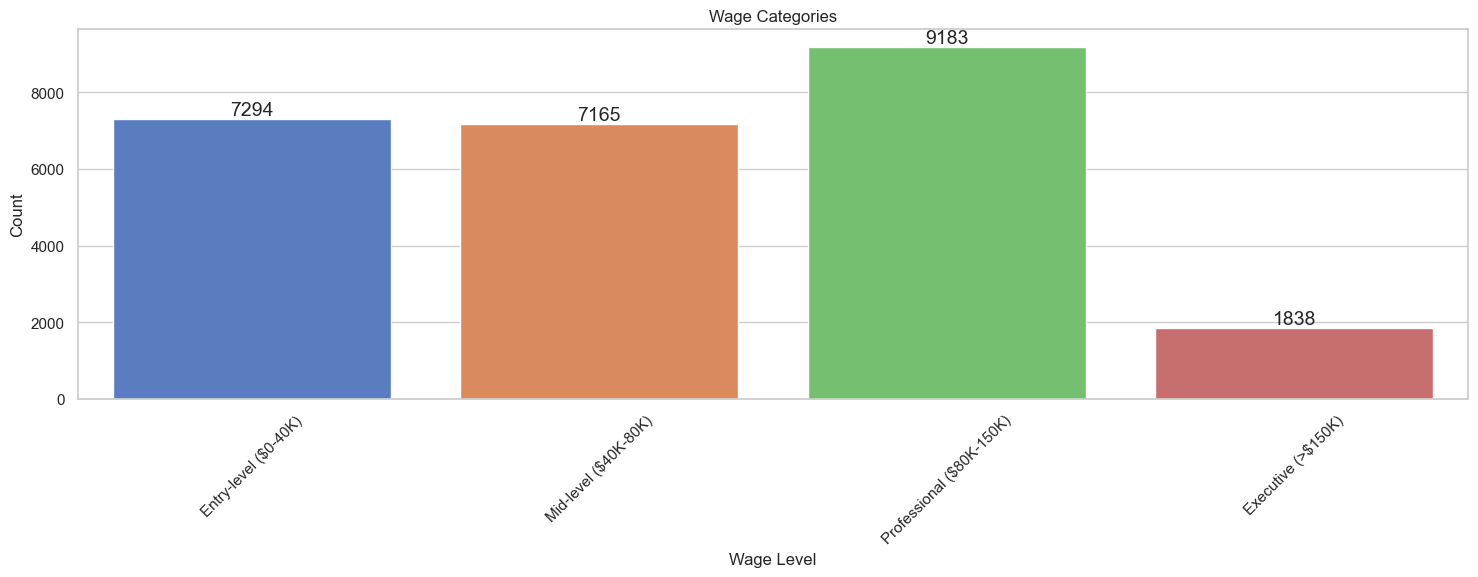

In [63]:
# Binning (Just to explore if it can be useful)

# Create wage categories based on observed distribution patterns
bins = [0, 40000, 80000, 150000, 320000]
labels = ['Entry-level ($0-40K)', 'Mid-level ($40K-80K)',
          'Professional ($80K-150K)', 'Executive (>$150K)']

# Create new binned feature
wage_category_feature = pd.cut(df['prevailing_wage'],
                            bins=bins, labels=labels)

# Plot the distribution
plt.figure(figsize=(15, 6))
ax = sns.countplot(x=wage_category_feature)
plt.title('Wage Categories')
plt.xlabel('Wage Level')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [64]:
wage_category_feature.value_counts()

Professional ($80K-150K)    9183
Entry-level ($0-40K)        7294
Mid-level ($40K-80K)        7165
Executive (>$150K)          1838
Name: prevailing_wage, dtype: int64

In [65]:
wage_category_feature.value_counts(normalize=True) * 100

Professional ($80K-150K)   36.04
Entry-level ($0-40K)       28.63
Mid-level ($40K-80K)       28.12
Executive (>$150K)          7.21
Name: prevailing_wage, dtype: float64

In [66]:
pd.crosstab(wage_category_feature, df['case_status'], normalize='index') * 100

case_status,Certified,Denied
prevailing_wage,,
Entry-level ($0-40K),60.82,39.18
Mid-level ($40K-80K),69.38,30.62
Professional ($80K-150K),68.86,31.14
Executive (>$150K),70.08,29.92


🔍 Observation: 

1. **Professional wages dominate**: The largest group is Professional ($80K-150K) at 36%, with Entry-level and Mid-level each representing about 28% of applications.

2. **Executive wages are rare**: Only 7.2% of applications are for Executive-level wages (>$150K).

3. **Clear relationship with visa outcomes**: Entry-level wages have significantly lower approval rates (60.8%) compared to all other categories (69-70%).

4. **Higher wages, higher approvals**: There's a positive relationship between wage level and approval rate, with Executive wages having the highest approval rate (70.1%).

⚡ **Business insight**: The substantial gap in approval rates between Entry-level and other categories suggests wage is an important factor in visa decisions, with applications for lower-paid positions facing greater scrutiny.

> This strong relationship makes wage category likely to be an important feature in your tree-based models.


#### 9. Unit of Wage
(Category)

In [67]:
colname = 'unit_of_wage'

In [68]:
df[colname].describe()

count     25480
unique        4
top        Year
freq      22962
Name: unit_of_wage, dtype: object

In [69]:
df[colname].value_counts()

Year     22962
Hour      2157
Week       272
Month       89
Name: unit_of_wage, dtype: int64

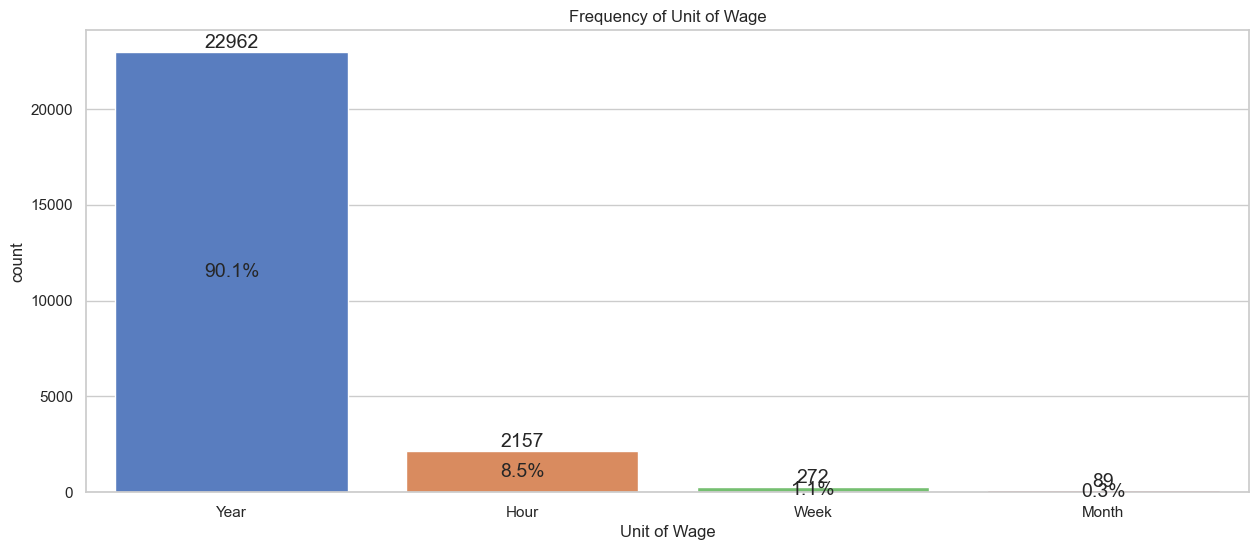

In [70]:
plt.figure(figsize=(15, 6))
draw_countplot(df, colname, label='Unit of Wage')

🔍 Observations:

1. **Yearly wages dominate**: The vast majority (90.1%) of applications report wages on a yearly basis.

2. **Hourly wages are distant second**: Only 8.5% of applications use hourly wage rates.

3. **Weekly and monthly are rare**: These units combined represent just 1.4% of applications.

4. **Extreme imbalance**: The distribution is highly skewed toward yearly wages, creating a significant class imbalance & a dominant category as "Yearly Wage"

💡 **Business insight**: Most visa applications are for salaried positions rather than hourly wage jobs, reflecting the professional nature of many visa-sponsored positions.

❗ **For modeling**: The extreme imbalance means tree-based models will have limited data to learn patterns for the minority classes (especially weekly and monthly wages), potentially making predictions less reliable for these groups.


#### 10. Full Time Position
(Categorical - Binary)

In [71]:
colname = 'full_time_position'

In [72]:
df[colname].describe()

count     25480
unique        2
top           Y
freq      22773
Name: full_time_position, dtype: object

In [73]:
df[colname].value_counts()

Y    22773
N     2707
Name: full_time_position, dtype: int64

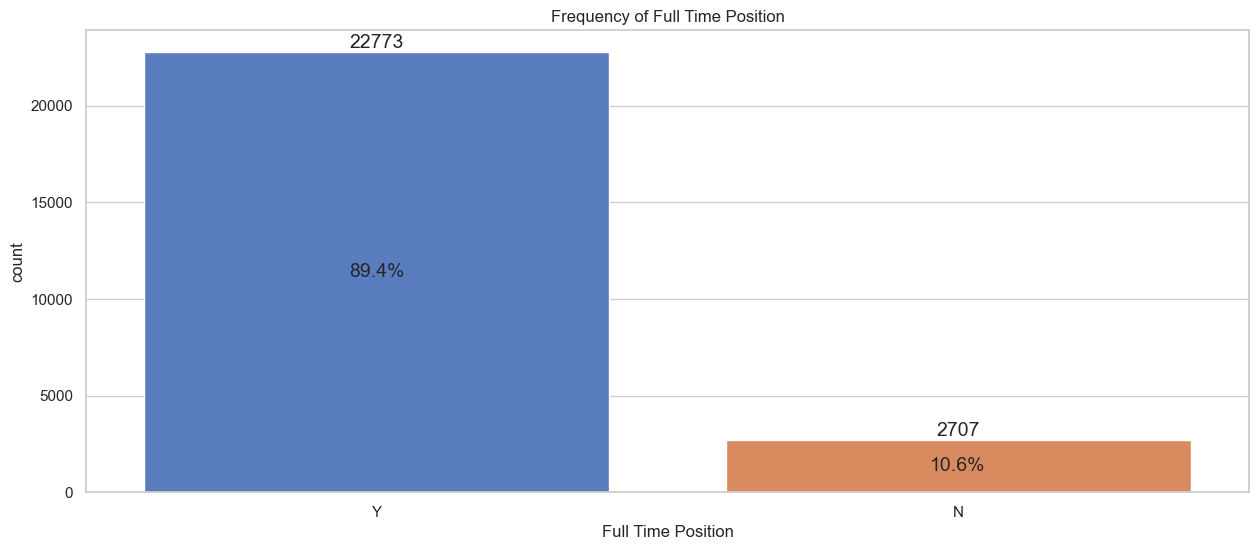

In [74]:
plt.figure(figsize=(15, 6))
draw_countplot(df, colname, label='Full Time Position')

🔍 Observations: 

1. **Full-time positions dominate**: The vast majority (89.4%) of visa applications are for full-time positions.

2. **Part-time positions are rare**: Only 10.6% of applications are for part-time positions.

3. **Strong imbalance**: The distribution is heavily skewed toward full-time positions.

🚀 **Business insight**: Visa programs are primarily used for full-time employment, reflecting immigration policies that generally favor permanent, stable positions over temporary or part-time work.

⚡ **For modeling**: The significant imbalance means tree-based models will have less data to learn patterns for part-time positions, potentially making predictions less reliable for this minority class unless it shows very distinct approval patterns.

> rarity can make it an informative split if it strongly correlates with the target.
> 
> If rarity correlates good with target then it may reveals risk of overfitting

#### 11. Case Status
(Target - Binary)

In [75]:
colname = 'case_status'

In [76]:
df[colname].describe()

count         25480
unique            2
top       Certified
freq          17018
Name: case_status, dtype: object

In [77]:
df[colname].value_counts()

Certified    17018
Denied        8462
Name: case_status, dtype: int64

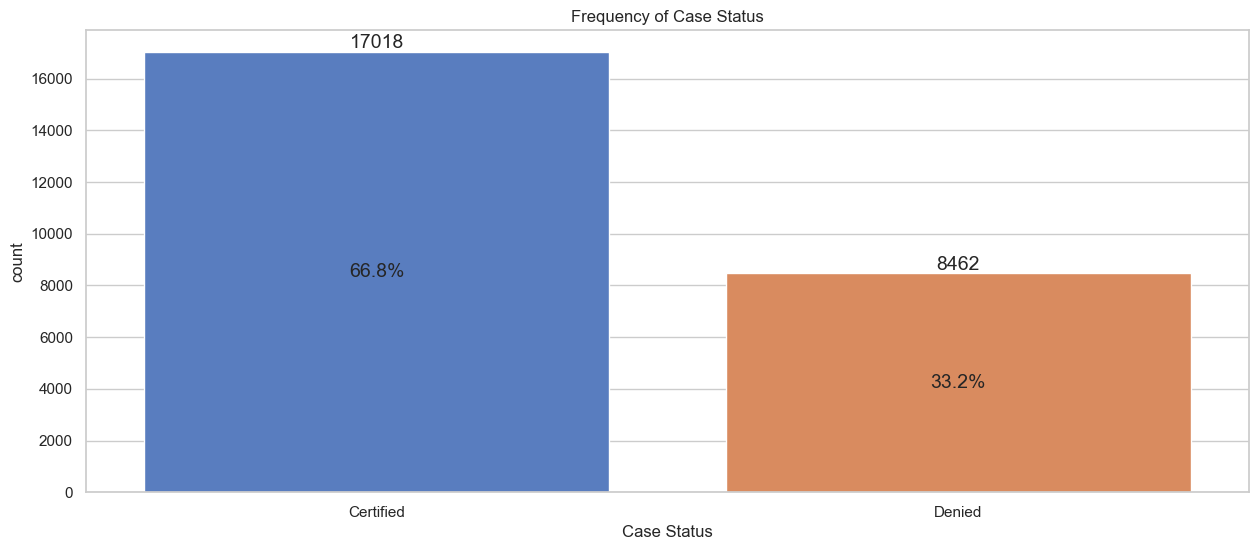

In [78]:
plt.figure(figsize=(15, 6))
draw_countplot(df, colname, label='Case Status')

🧐 Observations:

1. **Approval dominates**: About two-thirds (66.8%) of visa applications are certified (approved).

2. **One-third denied**: The remaining one-third (33.2%) of applications are denied.

3. **Moderate imbalance**: While there is class imbalance, it's not extreme - both classes have substantial representation.

4. **Business context**: The approval rate aligns with the purpose of the visa program, which is designed to approve qualified applications while maintaining standards.

🚀 **For modeling**: 
   - The moderate imbalance means standard classification metrics may be appropriate
   - Focus on both precision and recall, especially for the "Denied" class
   - The dataset has sufficient examples of both outcomes for effective learning

🎯 **Evaluation strategy**: Given the business context, Prioritize correctly identifying applications that should be denied (recall for the "Denied" class) is at crux.
- ensures we correctly identify actual denials, reducing "false negatives".
- If wrongly predicted as Certified, it could lead to misinformed decisions in real-world applications.

👀 **Regulatory perspective**: The visa program's purpose is to protect US workers while allowing qualified foreign workers. Missing a case that should be denied (false negative) could undermine this protection.

⚡ **Cost of errors**: 
- **False positive** (predicting Certified when actually Denied): Could allow unqualified applicants through, potentially affecting US labor market
- **False negative** (predicting Denied when actually Certified): Delays a qualified applicant, but they can appeal or reapply


---

## MultiVariate Analysis

#### Helper (Python)

In [79]:
def create_stacked_bar(
    df,
    feature,
    title="Approval Rates by Feature",
    xlabel="Feature",
    ylabel="Percentage",
    colors=["steelblue", "lightcoral"],
):
    """
    Create a stacked bar chart showing the distribution of a binary target variable
    across categories of a feature.

    returns crosstab
    """
    target="case_status"

    # Create a cross-tabulation
    crosstab = pd.crosstab(df[feature], df[target], normalize="index") * 100

    # Create stacked bar chart
    plt.figure(figsize=(12, 8))
    crosstab.plot(kind="bar", stacked=True, color=colors, figsize=(12, 8))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title=target)

    # Add percentage labels on bars - simplified for binary target
    for i, category in enumerate(crosstab.index):
        # Get percentages
        first_value = crosstab.iloc[i, 0]  # First class (e.g., Certified)
        second_value = crosstab.iloc[i, 1]  # Second class (e.g., Denied)

        # Add text for first class (middle of its section)
        plt.text(
            i,
            first_value / 2,
            f"{first_value:.1f}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        )

        # Add text for second class (middle of its section)
        plt.text(
            i,
            first_value + second_value / 2,
            f"{second_value:.1f}%",
            ha="center",
            va="center",
            color="black",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.show()

    return crosstab


In [80]:
# Mosaic Plot (Helps to show both Dominant Category + Dominant Split/Imbalance)
def create_mosaic_plot(df, feature, title=None):
    """
    Create a mosaic plot showing relationship between a feature and target variable
    """
    target='case_status'
    # Create figure
    plt.figure(figsize=(12, 8))

    # Set default title if none provided
    if title is None:
        title = f'{feature} vs {target}'

    # Create the data dictionary for mosaic
    # This creates a dictionary with keys as tuples of (continent, case_status)
    mosaic_data = {(i, j): 0 for i in df[feature].unique() for j in df[target].unique()}
    for i, row in df.iterrows():
        mosaic_data[(row[feature], row[target])] += 1

    # Create mosaic plot
    mosaic(mosaic_data, gap=0.01, title=title,
        properties=lambda key: {'color': 'steelblue' if key[1] == 'Certified' else 'lightcoral'})

    plt.tight_layout()
    plt.show()

In [81]:
def perform_chi_square_test(df, feature1, feature2='case_status'):
    """
    Perform Chi-Square test of independence between two categorical variables

    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame containing the data
    feature1 : str
        Name of first categorical feature
    feature2 : str
        Name of second categorical feature

    Returns:
    --------
    None
        Displays plots and prints test results
    """
    # Step 1: Create contingency table
    ct = pd.crosstab(df[feature1], df[feature2])

    # Step 2: Perform Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(ct)

    # Step 3: Convert expected values to DataFrame for visualization
    expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)

    # Step 4: Plot heatmap (Observed vs. Expected)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Observed values heatmap
    sns.heatmap(ct, annot=True, cmap="Blues", fmt="d", ax=axes[0])
    axes[0].set_title(f"Observed Frequencies: {feature1} vs {feature2}")

    # Expected values heatmap
    sns.heatmap(expected_df, annot=True, cmap="Reds", fmt=".1f", ax=axes[1])
    axes[1].set_title(f"Expected Frequencies: {feature1} vs {feature2}")

    plt.tight_layout()
    plt.show()

    # Step 5: Print Chi-Square Test result
    print(f"Chi-Square Statistic: {chi2:.2f}")
    print(f"P-value: {p:.4f}")

    # Decision based on p-value
    alpha = 0.05  # Significance level
    if p < alpha:
        print(f"Reject H₀: There is a significant relationship between {feature1} and {feature2}")
    else:
        print(f"Fail to reject H₀: No significant relationship found between {feature1} and {feature2}")


In [82]:
# Grouped Bar Plot

def create_grouped_bar(df, feature1, feature2='case_status', title=None, sortAsc=None):
    """
    Create a grouped bar plot comparing a feature against case status with counts and percentages.
    """
    # Create the grouped bar plot
    # Sort values by count
    order = None
    if sortAsc is not None:
        order = df[feature1].value_counts(ascending=sortAsc).index
    ax = sns.countplot(data=df, x=feature1, hue=feature2, order=order)

    # Calculate percentages
    total = len(df)
    for p in ax.patches:
        percentage = p.get_height() / total * 100

        # Add count on top
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='bottom')

        # Add percentage inside bar
        ax.annotate(f'{percentage:.1f}%',
                   (p.get_x() + p.get_width()/2., p.get_height()/2),
                   ha='center', va='center')

    # Set title - use default if none provided
    if title is None:
        title = f'Case Status Distribution by {feature1}'
    plt.title(title)

    plt.xlabel(snake_to_pascal(feature1))
    plt.ylabel(snake_to_pascal(feature2))

    # plt.xticks(rotation=45)
    plt.show()

In [83]:
# Contigencey Table
def create_contingency_table(df, feature1, feature2='case_status', pct=False):
    """
    Create a contingency table for two categorical features showing both counts and percentages.
    """
    return pd.crosstab(df[feature1], df[feature2], normalize= 'index' if pct else False) * 100

#### 1. Continent vs Case Status

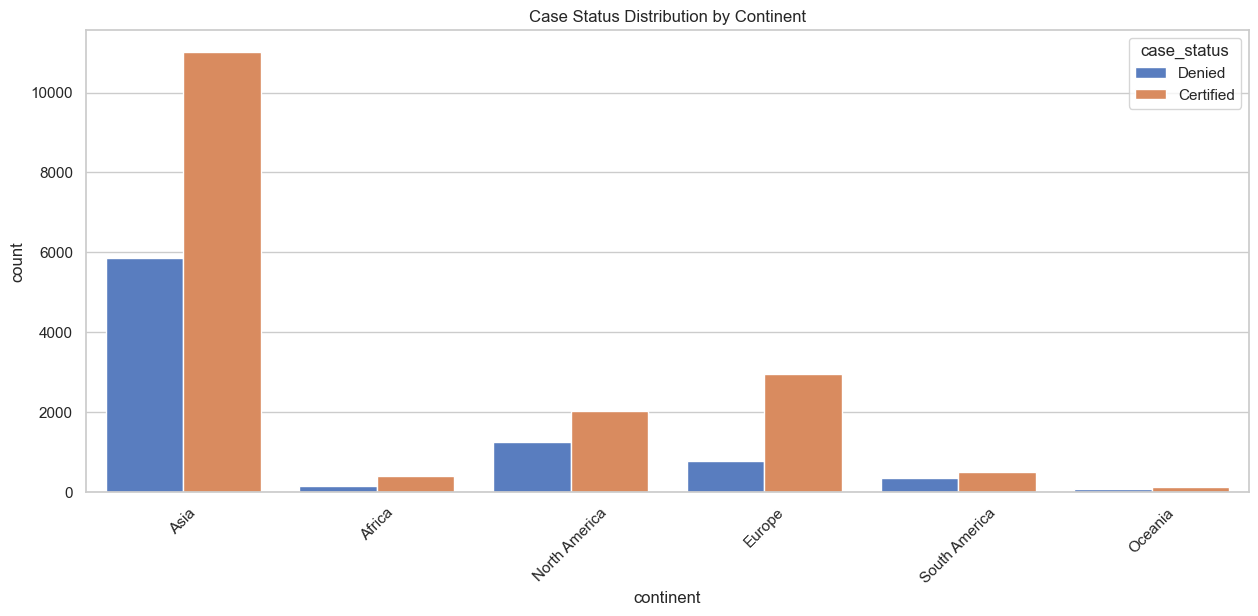

In [84]:
# Grouped Bar Plot
sns.countplot(data=df, x='continent', hue='case_status')
plt.title('Case Status Distribution by Continent')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

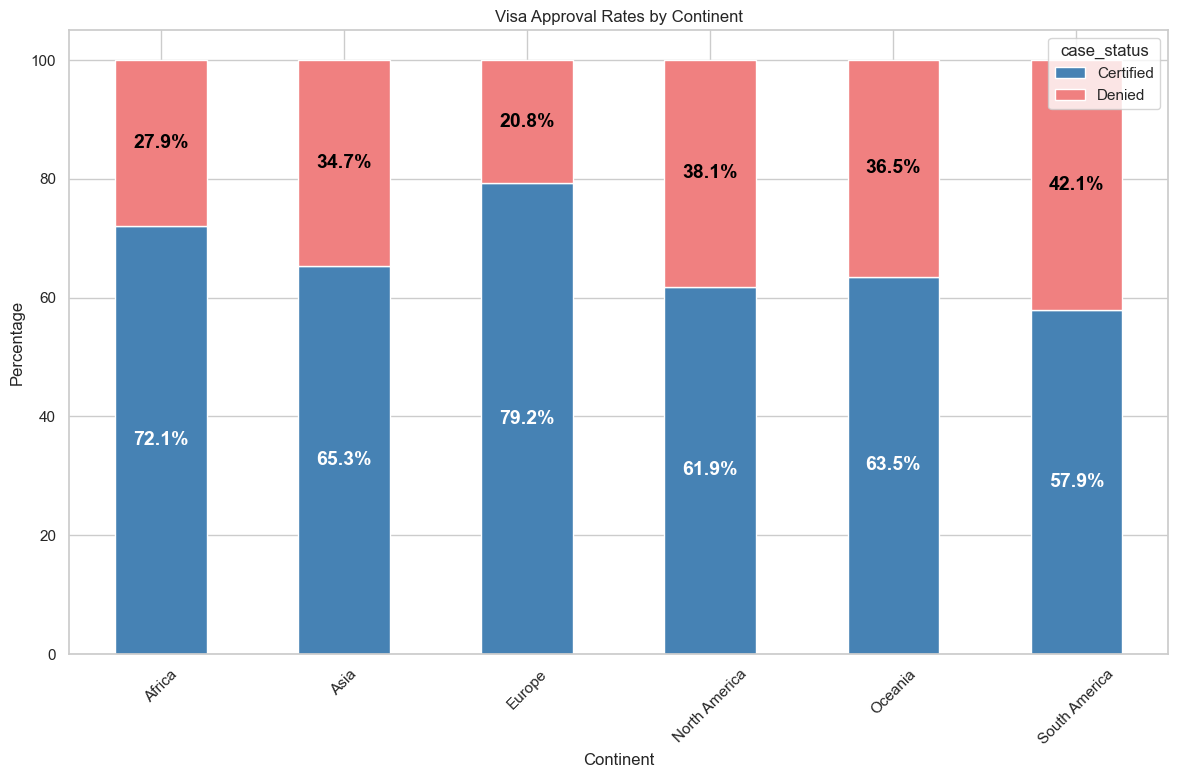

In [85]:
ct = create_stacked_bar(df, 'continent', 'Visa Approval Rates by Continent', 'Continent', 'Percentage')

👀 Points

1. Africa and Europe has good split dominance (ie Imbalance) which Favors Tree based Algorithms.
2. The substantial variation in approval rates (over 21 percentage points between Europe and South America) suggests geographic origin is a meaningful factor in visa outcomes.

Observations

1. **Europe has highest approval rate**: European applicants have a significantly higher approval rate (79.2%) than applicants from other continents, nearly 12 percentage points above the overall average.

2. **South America faces most challenges**: South American applicants have the lowest approval rate (57.9%), facing denials in over 42% of cases.

3. **North America surprisingly low**: Despite proximity, North American applicants have the second-lowest approval rate (61.9%), well below the overall average.

4. **Asia dominates volume but average success**: While Asia represents the majority of applications, its approval rate (65.3%) is slightly below the overall average.

5. **Clear geographic patterns**: The substantial variation in approval rates (over 21 percentage points between Europe and South America) suggests geographic origin is a meaningful factor in visa outcomes.

#### 2. Has Job Experience vs Case Status

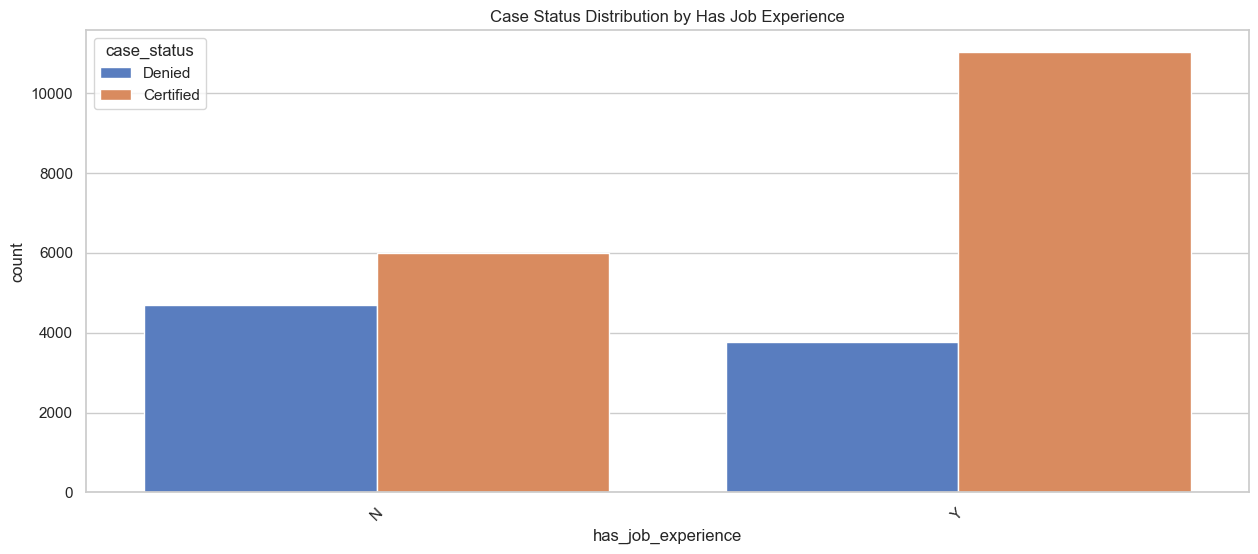

In [86]:
# Grouped Bar Plot
sns.countplot(data=df, x='has_job_experience', hue='case_status')
plt.title('Case Status Distribution by Has Job Experience')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

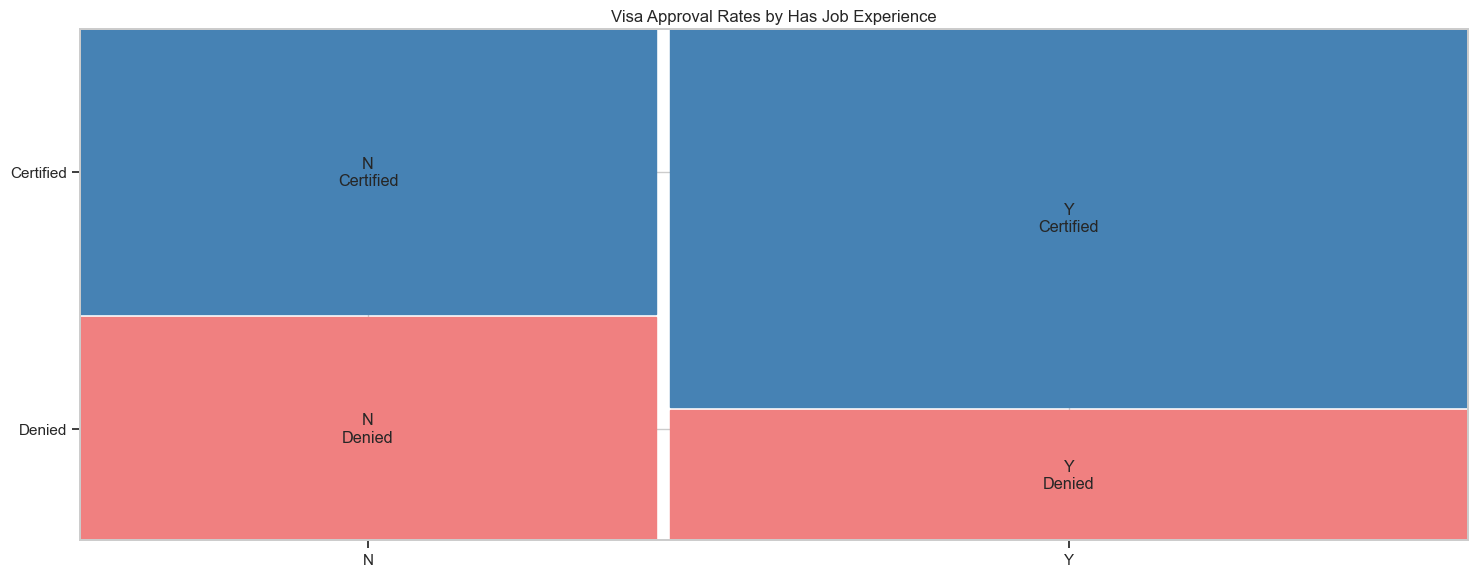

In [87]:
create_mosaic_plot(df, 'has_job_experience', title='Visa Approval Rates by Has Job Experience')

<Figure size 1200x800 with 0 Axes>

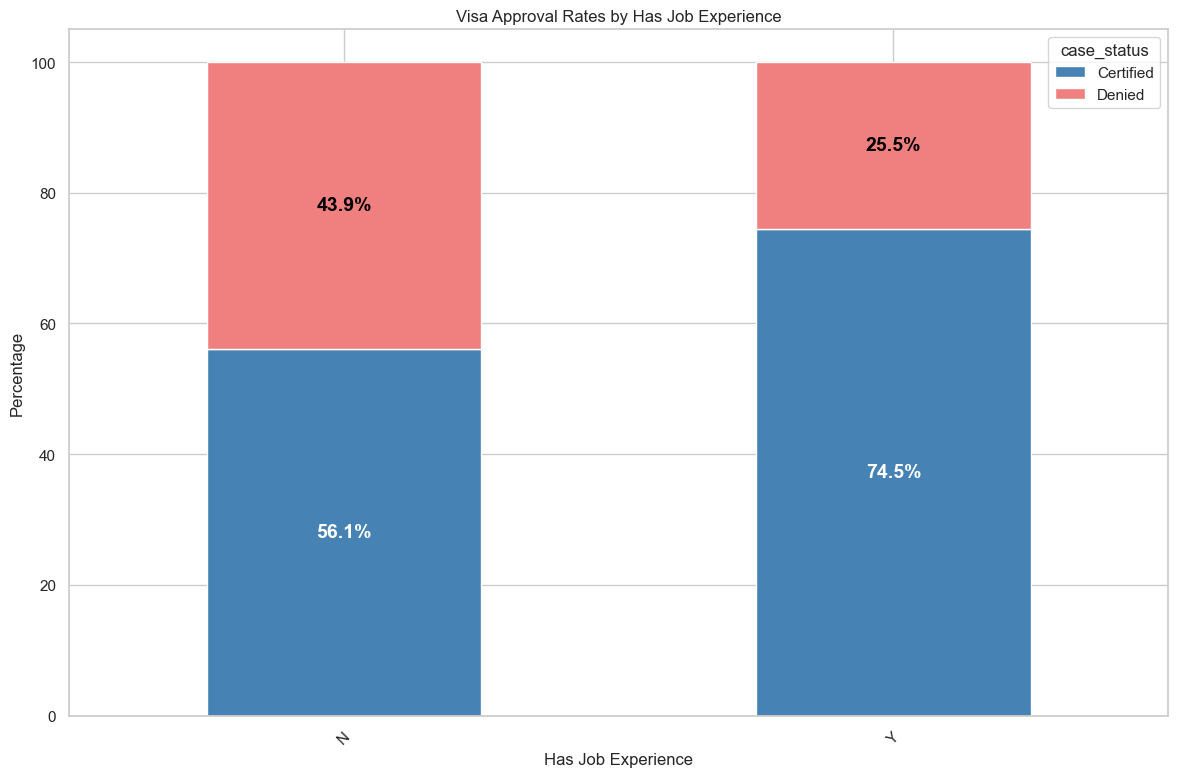

In [88]:
ct = create_stacked_bar(df, 'has_job_experience', 'Visa Approval Rates by Has Job Experience', 'Has Job Experience', 'Percentage')

👀 From above 3 plots:

- We can say that `has_job_experience` does quite good job for `Yes`, because it's
  - Dominating Category (Wider breadth wise)
  - Dominating Split too (ie Imbalanced Target Variable in Split Distribution) | (More blue color than red)
- This shows having job experience increases the likelihood of certification

💡 Job experience is a strong influencing factor. Candidates without experience face a higher rejection rate, while those with experience have a much better chance of getting certified. 🚀

🔍 Observations: 

1. **Experience strongly impacts approval**

2. **Inexperienced applicants face high denial rate**: Nearly 44% of applicants without job experience are denied, making this a high-risk category.

3. **Clear decision signal**: The strong relationship suggests experience is likely a key decision factor in the visa approval process.

💡 **Business insight**: This aligns with immigration policies that typically favor experienced workers who can immediately contribute to the workforce.

⚡ **Modeling**: This substantial difference makes **job experience** *likely to be a high-importance* feature in your tree-based models, potentially appearing near the top of decision trees.

#### 3. Education vs Case Status

In [89]:
create_contingency_table(df, 'education_of_employee')

case_status,Certified,Denied
education_of_employee,,
Bachelor's,636700,386700
Doctorate,191200,28000
High School,116400,225600
Master's,757500,205900


<Figure size 1200x800 with 0 Axes>

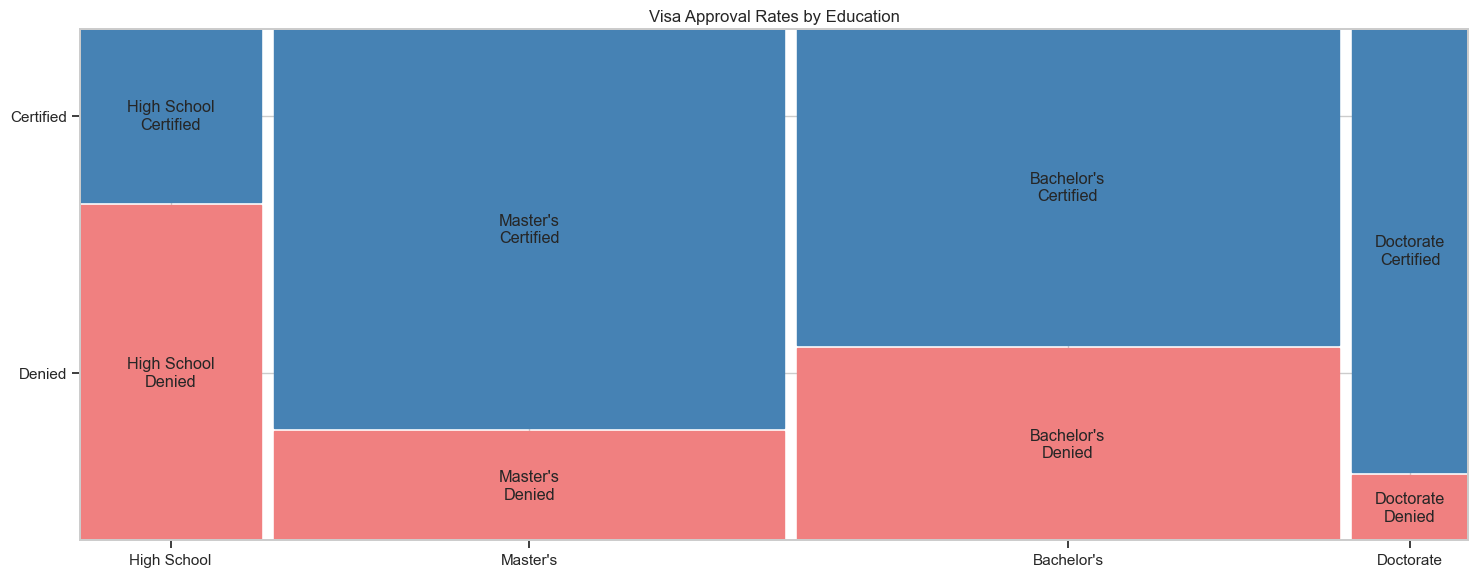

In [90]:
create_mosaic_plot(df, 'education_of_employee', title='Visa Approval Rates by Education')

🔍 Points 

1. **Education level strongly influences outcomes**: There's a clear pattern where higher education correlates with higher approval rates - Doctorate (87.2%), Master's (78.6%), Bachelor's (62.2%), and High School (34.0%).

2. **Doctorate is a powerful predictor**: Despite being **Rare**, Doctorate degree holders have an exceptionally high approval rate, making this category a likely high-value split point for tree-based models.
> Sometimes this may cause model to overfit, as these are rare but Ensemble are generally Robust to such things !

1. **Master's offers balanced predictive value**: dominates the dataset, with a wide breadth in the mosaic plot, indicating its prevalence. With both high volume and strong approval rates, Master's degrees provide reliable predictive power without the risk of overfitting that might come with the rarer Doctorate category.

2. **High School is a negative indicator**: High School education has a denial rate of 66%, making it a strong negative signal that tree models will likely identify.

3. **Clear educational hierarchy**: The stepwise increase in approval rates with each education level suggests trees may create splits that follow this natural hierarchy.

**For modeling**: Education level will likely be among the most important features in your ensemble models, with early splits potentially separating applicants by degree level.


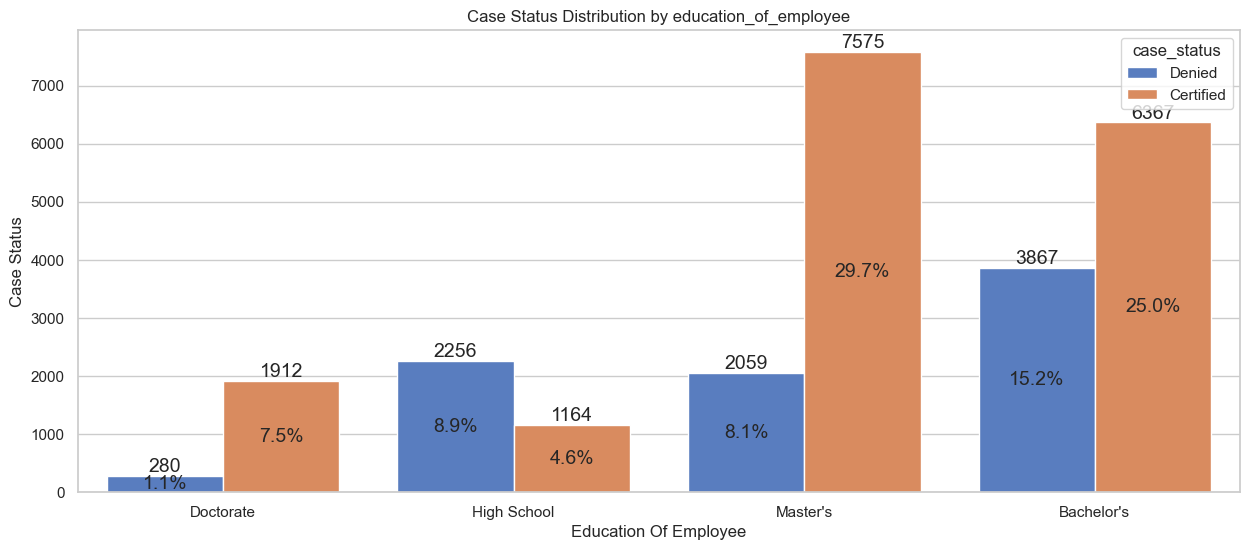

In [91]:
create_grouped_bar(df, 'education_of_employee', sortAsc=True)

🔍 Points 

- Though Bachelor's has more applicants overall, Master's degree holders receive the highest number of approvals.

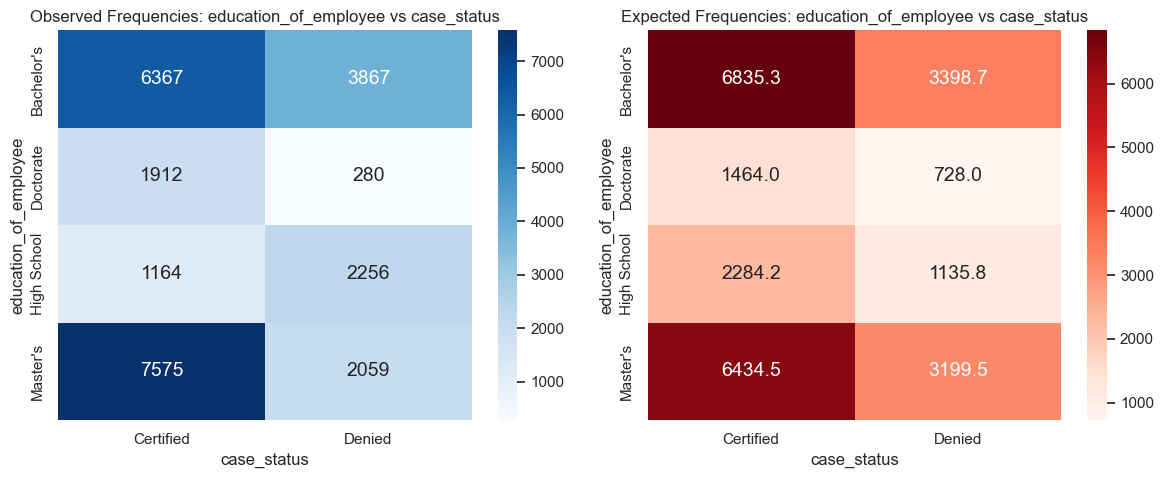

Chi-Square Statistic: 2772.21
P-value: 0.0000
Reject H₀: There is a significant relationship between education_of_employee and case_status


In [92]:
perform_chi_square_test(df, 'education_of_employee')

🚀 This confirms education level has a significant relationship with visa approval outcomes, which matches what you observed in your visualizations.


#### 4. Education of Employee vs Has Job Experience

(As these both feature has lot to do with Job, when think at facade, this analysis can be informative)

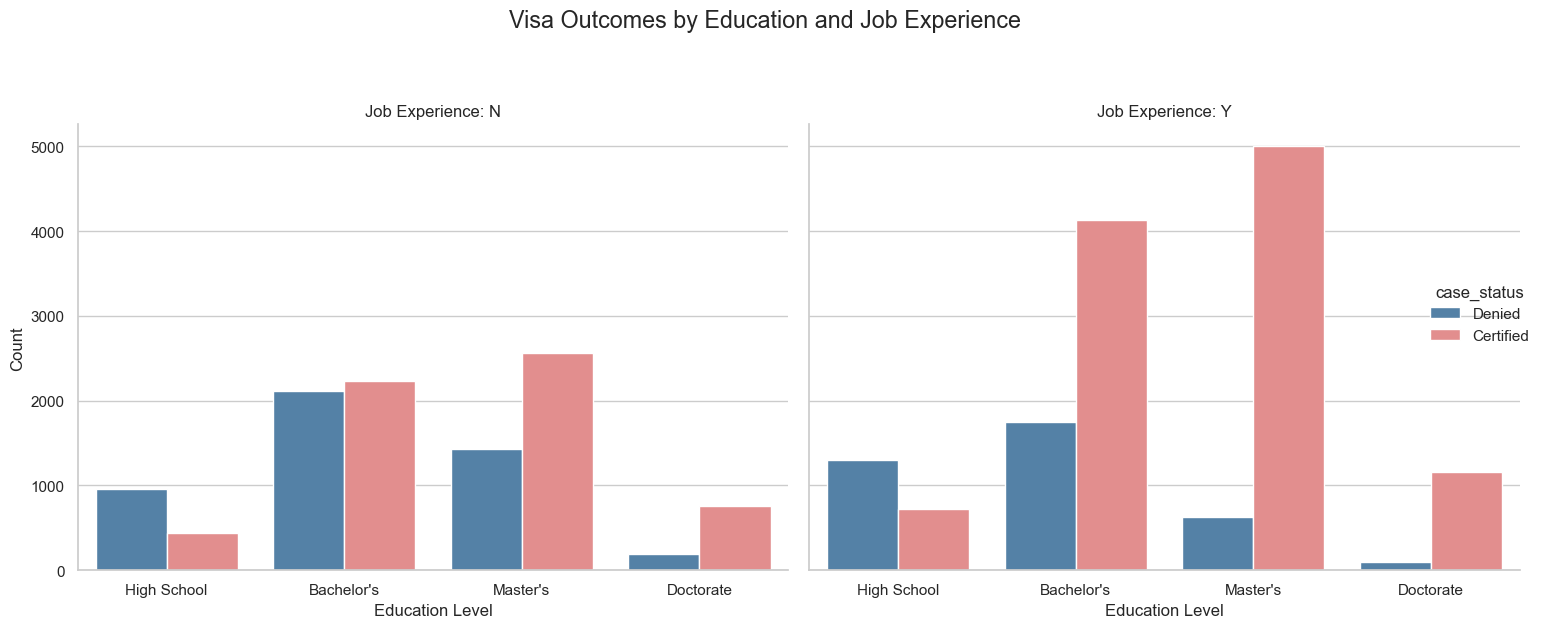

In [93]:
# Now split by job experience
g = sns.catplot(data=df, x='education_of_employee', hue='case_status', col='has_job_experience',
               kind='count', palette=['steelblue', 'lightcoral'],
               order=['High School', 'Bachelor\'s', 'Master\'s', 'Doctorate'],
               height=6, aspect=1.2)
g.figure.suptitle('Visa Outcomes by Education and Job Experience', y=1.05)
g.set_axis_labels('Education Level', 'Count')
g.set_titles('Job Experience: {col_name}')
plt.tight_layout()
plt.show()

🔍 Points 

- It shows that having job experience, can give edge in Visa process and thereby reduce chance of being rejected, comparatively

#### 5. Year of Establishment vs Case Status

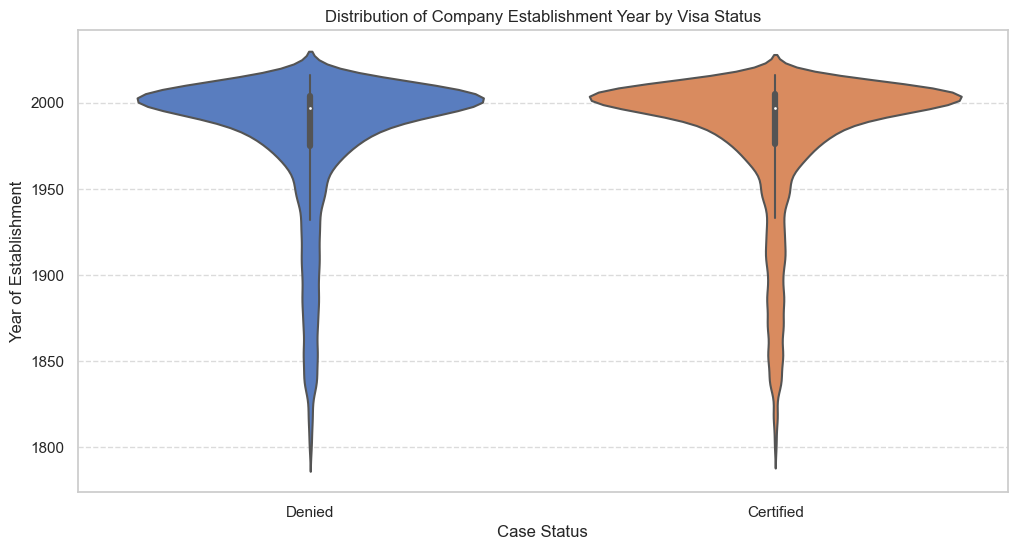

In [94]:
# Violin plot for Year of Establishment by Case Status
plt.figure(figsize=(12, 6))
sns.violinplot(x='case_status', y='yr_of_estab', data=df)
plt.title('Distribution of Company Establishment Year by Visa Status')
plt.xlabel('Case Status')
plt.ylabel('Year of Establishment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

🔍 Points

- Both Certified and Denied have near identical distributions, Suggesting company age alone ain't a strong differentiator

In [95]:
# Get summary statistics for each case status
for status in df['case_status'].unique():
    subset = df[df['case_status'] == status]['yr_of_estab']
    print(f"\nStatistics for {status}:")
    print(f"Mean: {subset.mean():.2f}")
    print(f"Median: {subset.median():.2f}")
    print(f"25th percentile: {subset.quantile(0.25):.2f}")
    print(f"75th percentile: {subset.quantile(0.75):.2f}")
    print(f"Min: {subset.min():.2f}")
    print(f"Max: {subset.max():.2f}")
    print(f"Skewness: {subset.skew():.2f}")


Statistics for Denied:
Mean: 1978.89
Median: 1997.00
25th percentile: 1975.00
75th percentile: 2004.00
Min: 1800.00
Max: 2016.00
Skewness: -2.04

Statistics for Certified:
Mean: 1979.67
Median: 1997.00
25th percentile: 1976.00
75th percentile: 2005.00
Min: 1800.00
Max: 2016.00
Skewness: -2.03


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


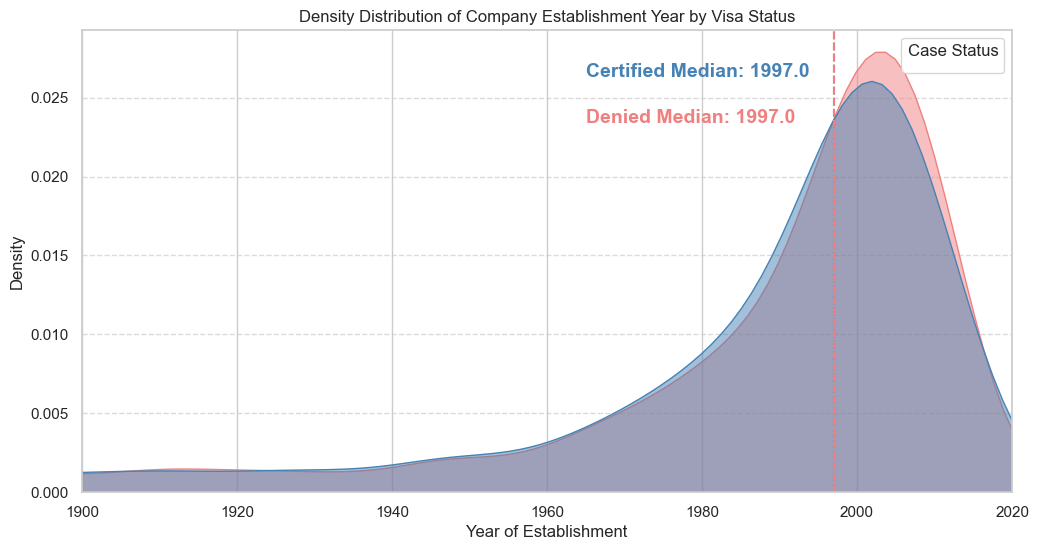

In [96]:
# KDE plot for Year of Establishment by Case Status
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='yr_of_estab', hue='case_status',
            palette=['steelblue', 'lightcoral'],
            common_norm=False, fill=True, alpha=0.5)
plt.title('Density Distribution of Company Establishment Year by Visa Status')
plt.xlabel('Year of Establishment')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical lines for medians without adding to legend
for i, (status, color) in enumerate(zip(['Certified', 'Denied'], ['steelblue', 'lightcoral'])):
    median = df[df['case_status'] == status]['yr_of_estab'].median()
    plt.axvline(x=median, color=color, linestyle='--')

    # Stagger the text positions vertically
    vertical_position = plt.ylim()[1] * (0.9 - i*0.1)  # Different heights
    horizontal_offset = -32  # Left side

    # Add text annotation
    plt.text(median + horizontal_offset, vertical_position,
             f'{status} Median: {median}',
             color=color, fontweight='bold')

plt.xlim(1900, 2020)  # Focus on more recent years
plt.legend(title='Case Status')
plt.show()

🔍 Points

1. Both certified and denied applications have nearly identical distributions
2. The median year is 1997 for both groups
3. Overall, the establishment year distributions are remarkably similar between approved and denied applications

This reinforces the conclusion that company age alone isn't a strong differentiator for visa outcomes. The minimal differences we see in the KDE plot align perfectly with the similar means, medians, and quartiles you shared earlier.

#### 6 Year of Establishment & Continent

Potential Insight : Do older companies in certain continents have higher approval rates?

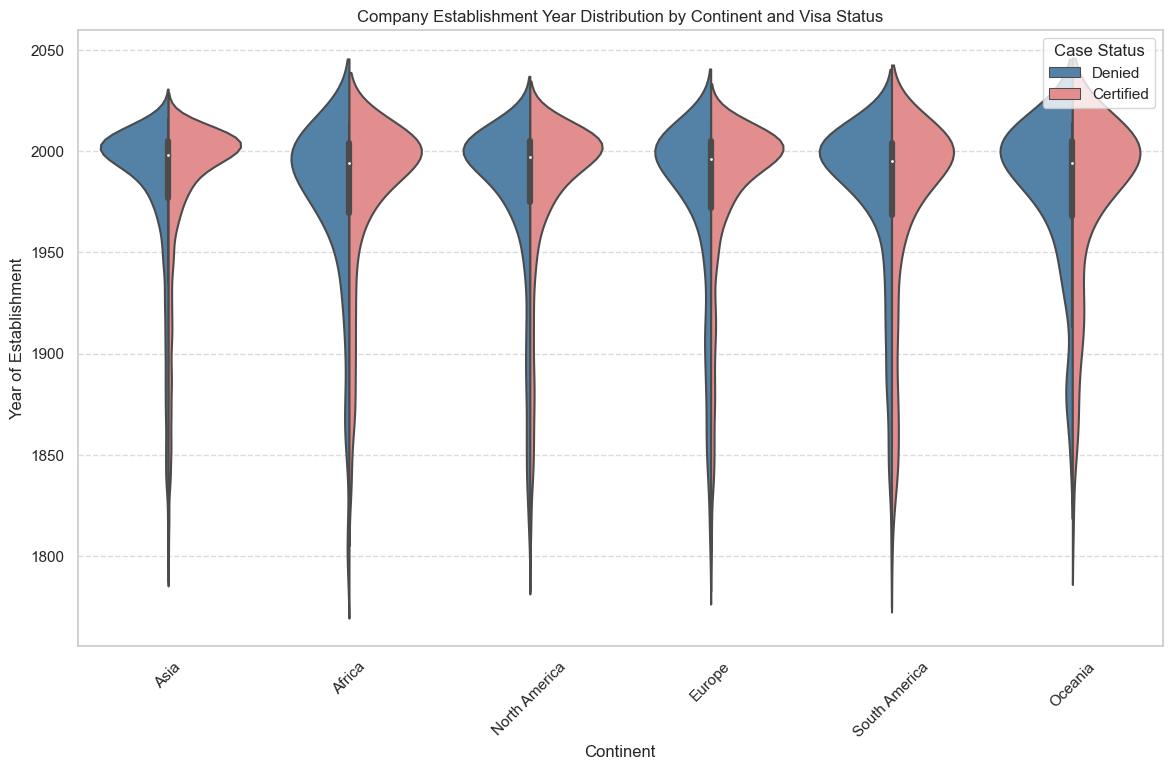

In [97]:
# Violin plots
plt.figure(figsize=(14, 8))
sns.violinplot(x='continent', y='yr_of_estab', hue='case_status',
               data=df, palette=['steelblue', 'lightcoral'], split=True)
plt.title('Company Establishment Year Distribution by Continent and Visa Status')
plt.xlabel('Continent')
plt.ylabel('Year of Establishment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Case Status')
plt.xticks(rotation=45)
plt.show()

🔍 Points

- As there are outliers for almost all case, we can't find much insight or distinguisher for Tree from these violin plots

Adding Continent as another dimension probably won't reveal strong patterns since the establishment year itself doesn't strongly correlate with visa outcomes.

#### 7. Number of Employees vs Case Status


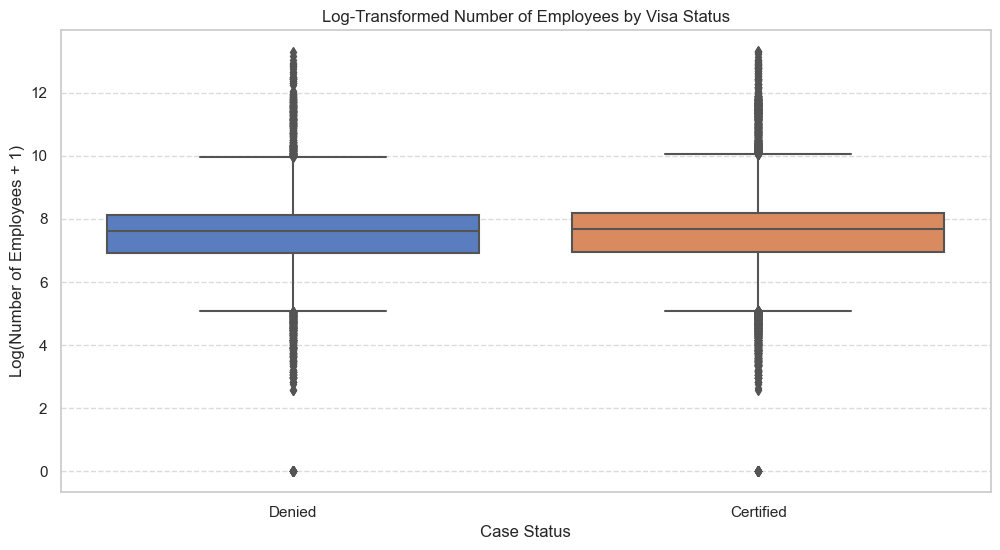

In [98]:
# Box plot with better handling of skewed data
plt.figure(figsize=(12, 6))
# Clip negative values and apply log transformation
transformed_employees = np.log1p(df['no_of_employees'].clip(lower=0))
sns.boxplot(x=df['case_status'], y=transformed_employees)
plt.title('Log-Transformed Number of Employees by Visa Status')
plt.xlabel('Case Status')
plt.ylabel('Log(Number of Employees + 1)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

🔍 Points

- Company size likely isn't a strong differentiator for visa outcomes.
- Both large and small companies have similar approval rates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


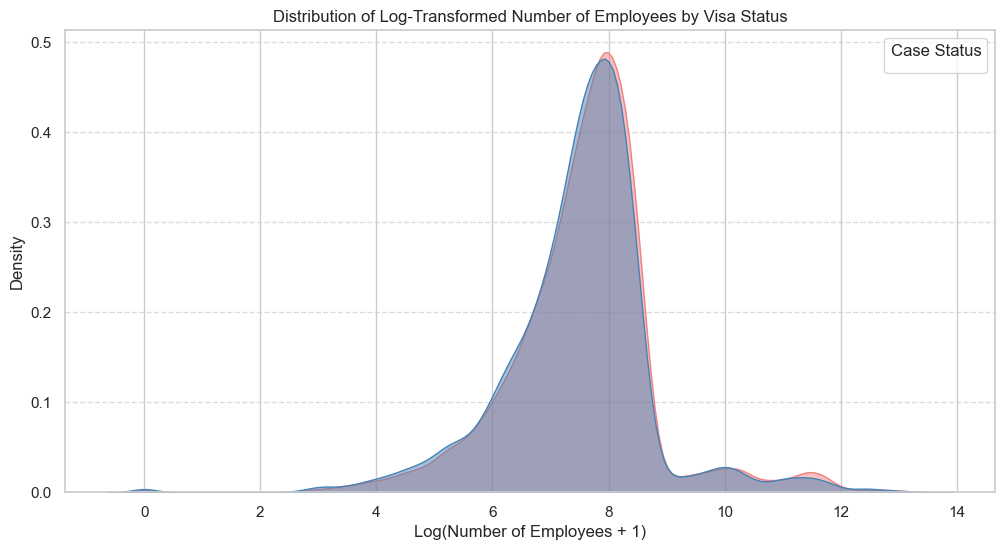

In [99]:
# KDE plot for log-transformed number of employees by case status
plt.figure(figsize=(12, 6))
# Applying Log transformation so as to get better viz (otherwise tree models dont need this during modeling)
# Clip negative values and apply log transformation
transformed_employees = np.log1p(df['no_of_employees'].clip(lower=0))

# Create KDE plot
sns.kdeplot(data=df, x=transformed_employees, hue='case_status',
            palette=['steelblue', 'lightcoral'],
            common_norm=False, fill=True, alpha=0.5)

plt.title('Distribution of Log-Transformed Number of Employees by Visa Status')
plt.xlabel('Log(Number of Employees + 1)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Case Status')
plt.show()

🔍 Points

- This hints that company size isn't a meaningful differentiator for visa outcomes
- The visa approval process seems to evaluate applications similarly regardless of company size.

🧠 REMEMBER:
 
1. **Tree-based models are invariant to monotonic transformations**: They make splits based on the relative ordering of values, not their absolute scale. Log transformation preserves this ordering.
2. **Trees naturally handle skewed distributions**

So while log transformations are valuable for visualization of skewed data like employee counts, you can use the original untransformed values when building tree-based ensemble models without losing predictive power.

#### 8. Region of Employment vs Case Status

In [100]:
create_contingency_table(df, 'region_of_employment')

case_status,Certified,Denied
region_of_employment,,
Island,22600,14900
Midwest,325300,105400
Northeast,452600,266900
South,491300,210400
West,410000,248600


In [101]:
create_contingency_table(df, 'region_of_employment', pct=True)

case_status,Certified,Denied
region_of_employment,,
Island,60.27,39.73
Midwest,75.53,24.47
Northeast,62.90,37.10
South,70.02,29.98
West,62.25,37.75


<Figure size 1200x800 with 0 Axes>

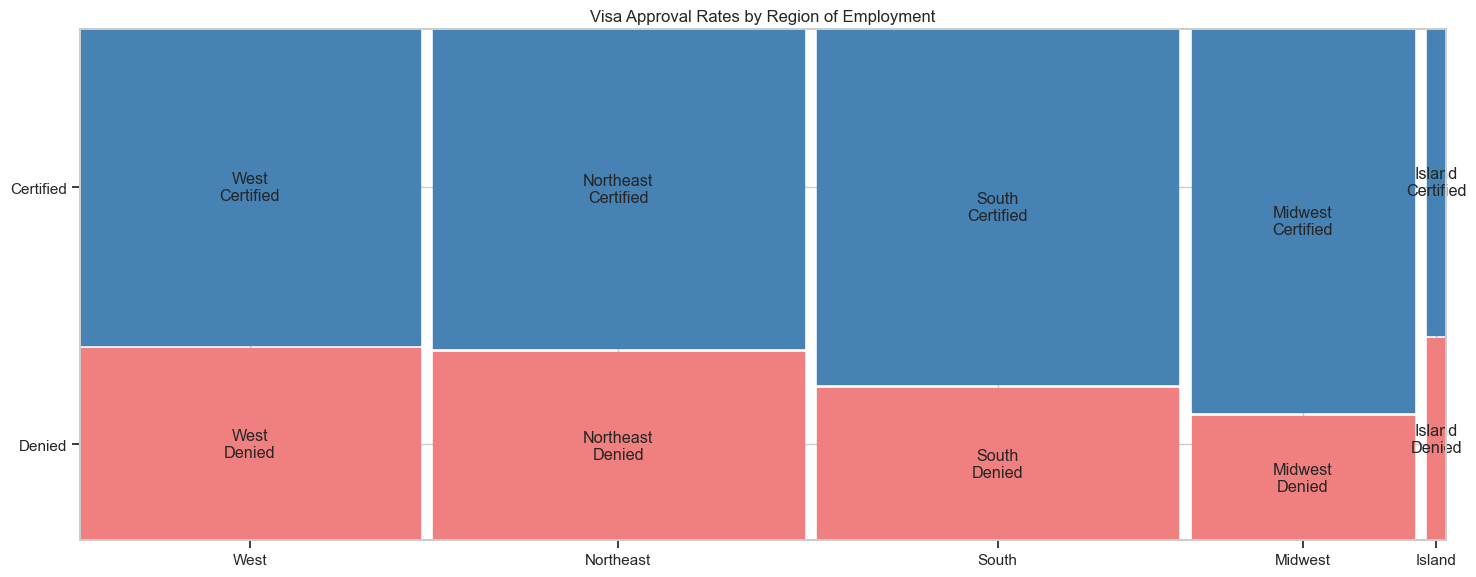

In [102]:
create_mosaic_plot(df, 'region_of_employment', title='Visa Approval Rates by Region of Employment')

---

🔍 Points

1. Island is rare, & hence probably Tree will ignore as it's not helping with splits too.
2. There is no dominance among rest, which is good sign for Tree alike models
3. Midwest has the highest approval rate (75.5%), followed by South (70.0%)

> The Midwest and South regions show stronger imbalance toward approvals, making them potentially valuable split points for tree models.

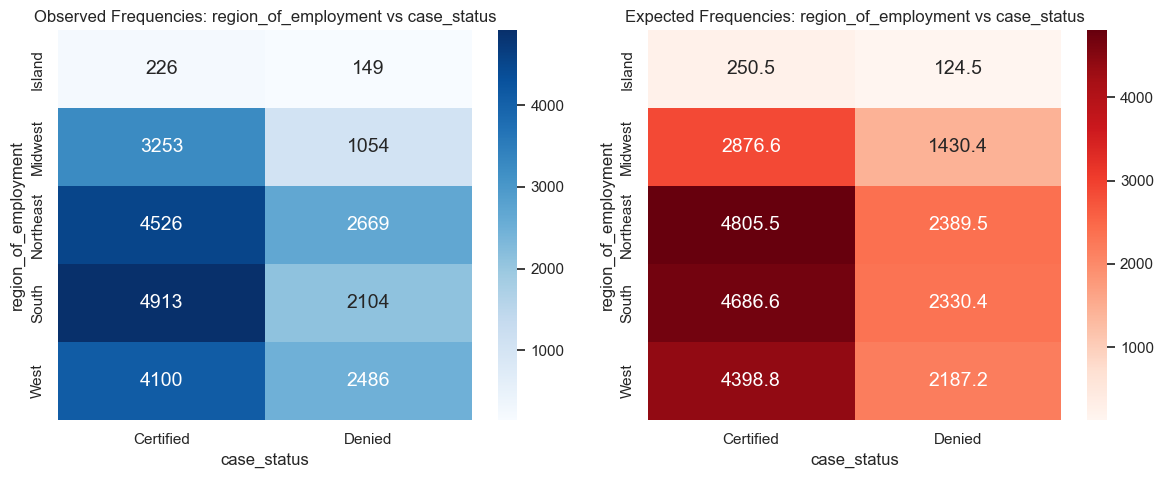

Chi-Square Statistic: 298.45
P-value: 0.0000
Reject H₀: There is a significant relationship between region_of_employment and case_status


In [103]:
perform_chi_square_test(df, 'region_of_employment')

👀 Observation:

The staistical confirmation supports what observed earlier

1. Region matters for visa outcomes
2. The higher approval rates in the Midwest and South represent genuine patterns in the visa process.
3. **Business implications** - Companies and applicants should consider regional factors when planning visa applications, as they appear to influence outcomes.

#### 9. Region and Company Age

Potential insights :
- Do older companies operate in specific regions?
- Are newer companies concentrated in certain regions?

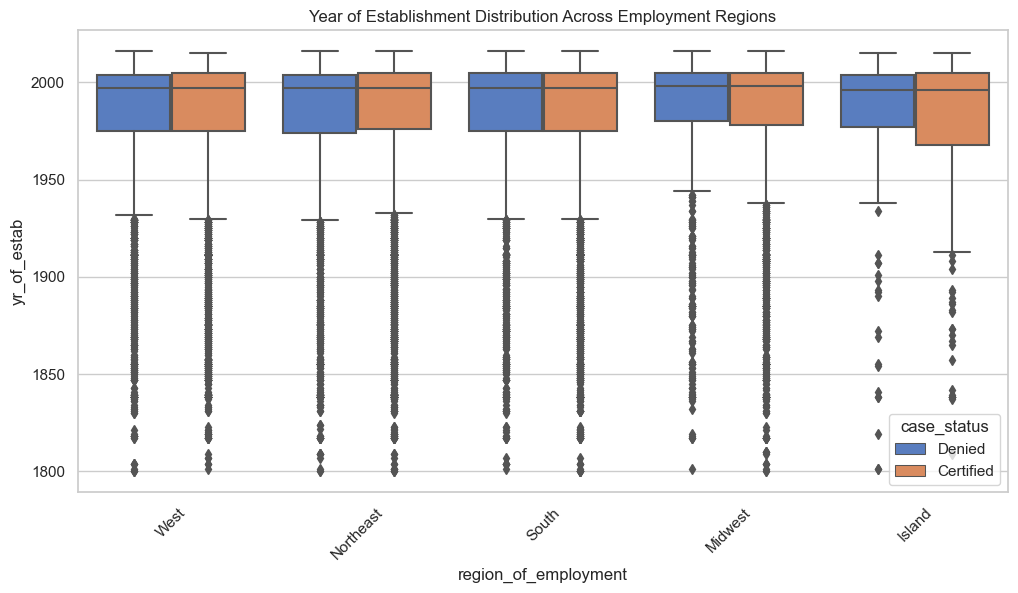

In [104]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="region_of_employment", y="yr_of_estab", hue='case_status')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Year of Establishment Distribution Across Employment Regions")
plt.show()

🔍 Observation: 

The box plot indicates that **company age does not show significant variation across different employment regions** in relation to visa approval. The distributions appear similar, with no clear distinguishing boundaries.

#### 10 Prevailing Wage vs Case Status

Potential insight 

1. If higher-paid positions have better approval rates
2. Whether there's a wage threshold that affects visa decisions

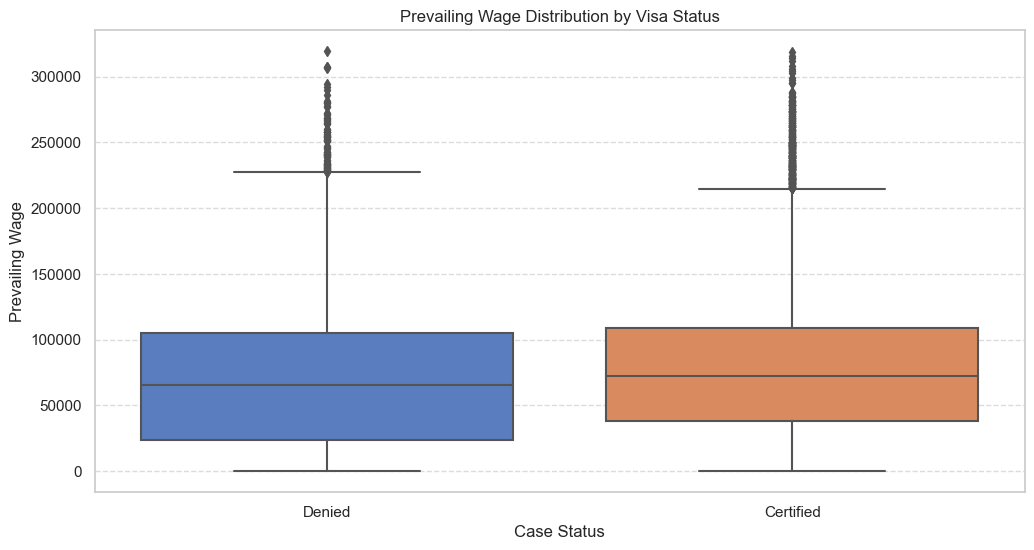

In [105]:
# Box plot for Prevailing Wage by Case Status
plt.figure(figsize=(12, 6))
sns.boxplot(x='case_status', y='prevailing_wage', data=df)
plt.title('Prevailing Wage Distribution by Visa Status')
plt.xlabel('Case Status')
plt.ylabel('Prevailing Wage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

🔍 Points

1. Similar central distributions
2. **Very high-paying positions might have a slightly better chance of approval.**
3. No clear wage threshold: The lack of a distinct separation between the boxes suggests there isn't a clear wage threshold that strongly influences visa decisions. 

This finding suggests that while extremely high wages might slightly favor approval, for the majority of applications, other factors likely play more important roles in determining visa outcomes.

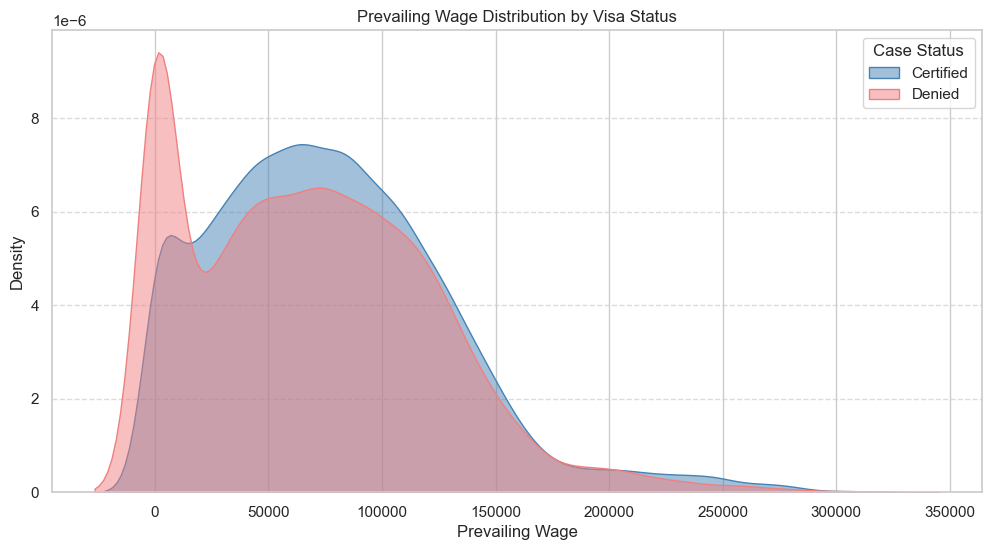

In [106]:
# KDE plot for prevailing wage by case status
plt.figure(figsize=(12, 6))

# Create separate KDE plots for each case status
for status, color in zip(['Certified', 'Denied'], ['steelblue', 'lightcoral']):
    subset = df[df['case_status'] == status]['prevailing_wage']
    sns.kdeplot(x=subset, label=status, color=color, fill=True, alpha=0.5)

plt.title('Prevailing Wage Distribution by Visa Status')
plt.xlabel('Prevailing Wage')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Case Status')
plt.show()

🔍 That's an interesting observation! 

1. **Low-wage threshold effect**: There may be a higher scrutiny or denial rate for very low-wage positions, possibly reflecting immigration policies that prioritize higher-skilled workers.

2. **Entry-level position challenges**: This could indicate that entry-level or lower-skilled positions face more challenges in the visa process.

3. **Potential split point for trees**: This separation in the low wage range could be a valuable split point for tree-based models, even if the overall distributions are similar.

4. **Targeted insight**: While prevailing wage might not be strongly predictive across its entire range, it could be particularly informative at the lower end of the spectrum.

#### 11. Prevailing Wage and Region of Employment

Potential Insight
- This could reveal regional economic patterns in the visa application process.
- Whether certain regions have higher-paying visa applications


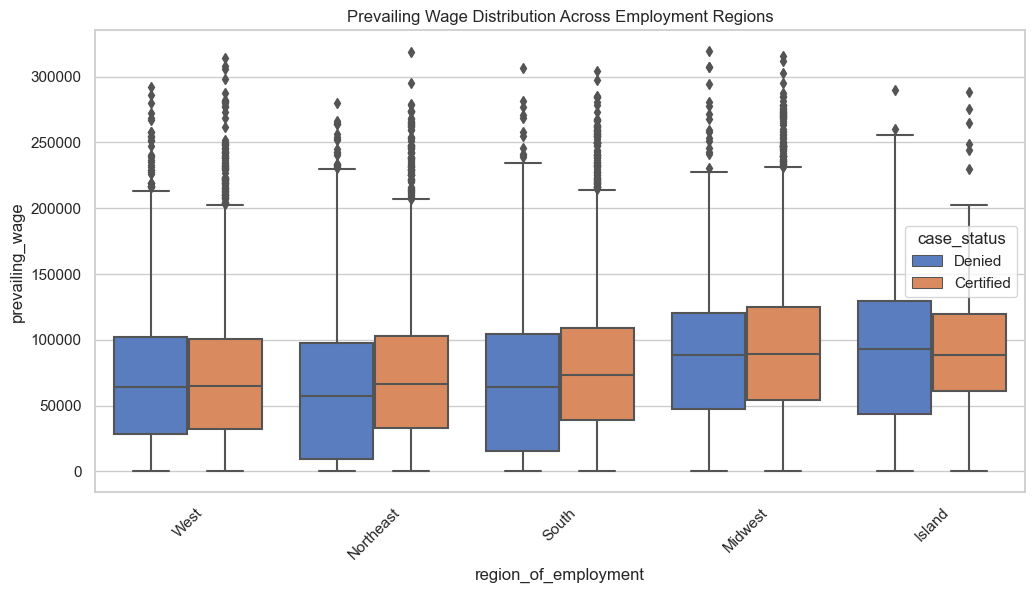

In [107]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="region_of_employment", y="prevailing_wage", hue='case_status')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Prevailing Wage Distribution Across Employment Regions")
plt.show()

🔍 Points: 

1. **Subtle regional differences**: The slight displacement between certified and denied boxes in some regions suggests that wage thresholds might have a minor effect on outcomes, but it varies by region.

2. **Complex relationship**: This visualization reveals that the relationship between wages, regions, and visa outcomes is nuanced - wages may matter more in some regions than others.


This finding suggests that while prevailing wage isn't a universally strong predictor, it might have more predictive power when considered in conjunction with region of employment.

#### 11. Unit of Wage vs Case Status

In [108]:
create_contingency_table(df, 'unit_of_wage')

case_status,Certified,Denied
unit_of_wage,,
Hour,74700,141000
Month,5500,3400
Week,16900,10300
Year,1604700,691500


In [109]:
create_contingency_table(df, 'unit_of_wage', pct=True)

case_status,Certified,Denied
unit_of_wage,,
Hour,34.63,65.37
Month,61.80,38.20
Week,62.13,37.87
Year,69.89,30.11


<Figure size 1200x800 with 0 Axes>

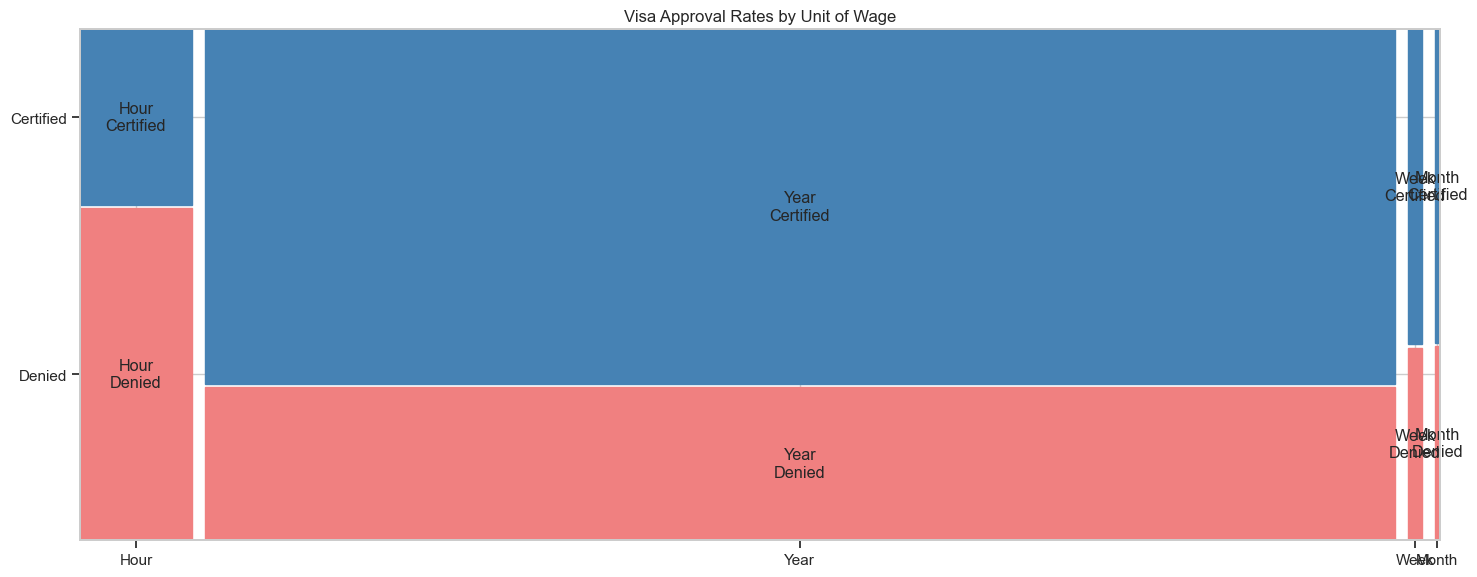

In [110]:
create_mosaic_plot(df, 'unit_of_wage', title='Visa Approval Rates by Unit of Wage')

🔍 Points

1. **Year dominates**: The vast majority of applications use yearly wage (over 90%), making it the dominant category.

2. **Hourly wages show reverse pattern**: While yearly wages favor certification (69.9% approved), hourly wages strongly favor denial (65.4% denied). This striking reversal suggests unit of wage could be a powerful predictor.

3. **Monthly and weekly are rare but positive**: These categories represent small portions of the data but have similar approval rates (around 62%).

> The strong association between hourly wages and denials would likely be captured by tree-based models as an important split.

**Business insight**: The much higher denial rate for hourly positions suggests these jobs face greater scrutiny, possibly because they're seen as less stable or lower-skilled.

This feature shows a meaningful relationship with visa outcomes despite its imbalance, making it potentially valuable for prediction.


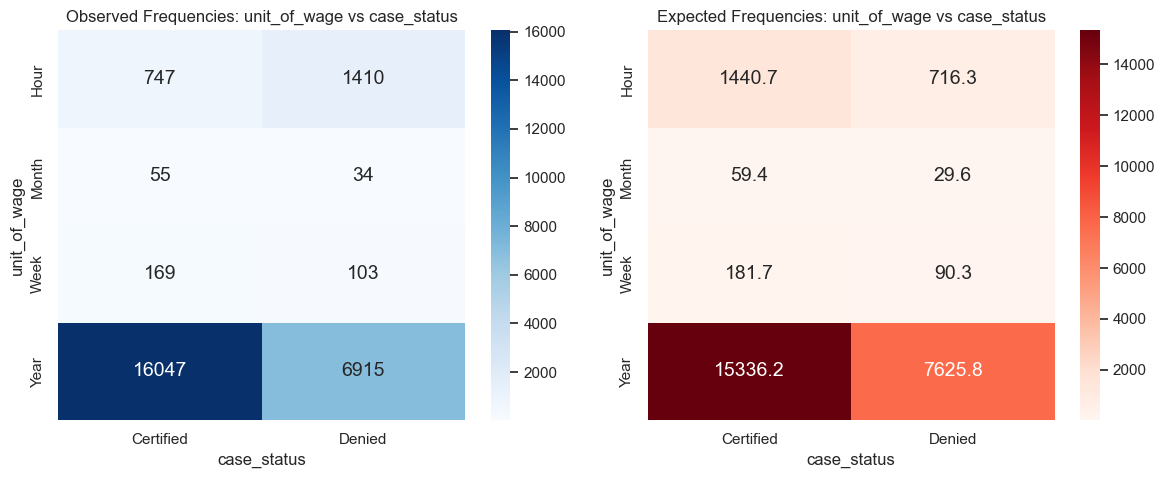

Chi-Square Statistic: 1108.51
P-value: 0.0000
Reject H₀: There is a significant relationship between unit_of_wage and case_status


In [111]:
perform_chi_square_test(df, 'unit_of_wage')

> The stats strengthen our analysis did earlier.

#### 12. Full time Position vs Case Status


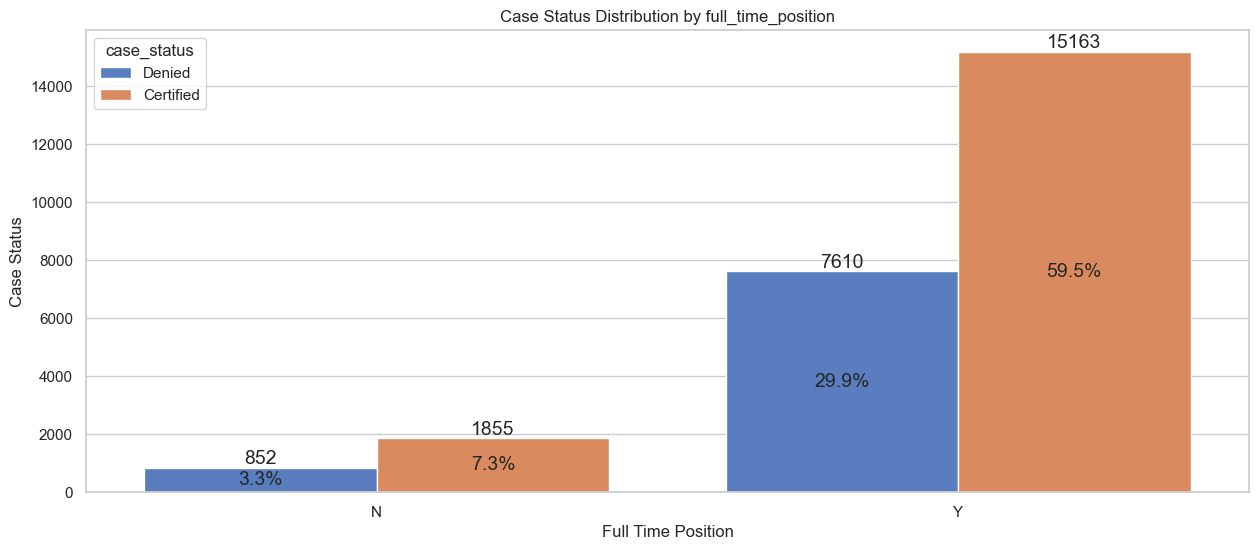

In [112]:
create_grouped_bar(df, 'full_time_position', sortAsc=True)

<Figure size 1200x800 with 0 Axes>

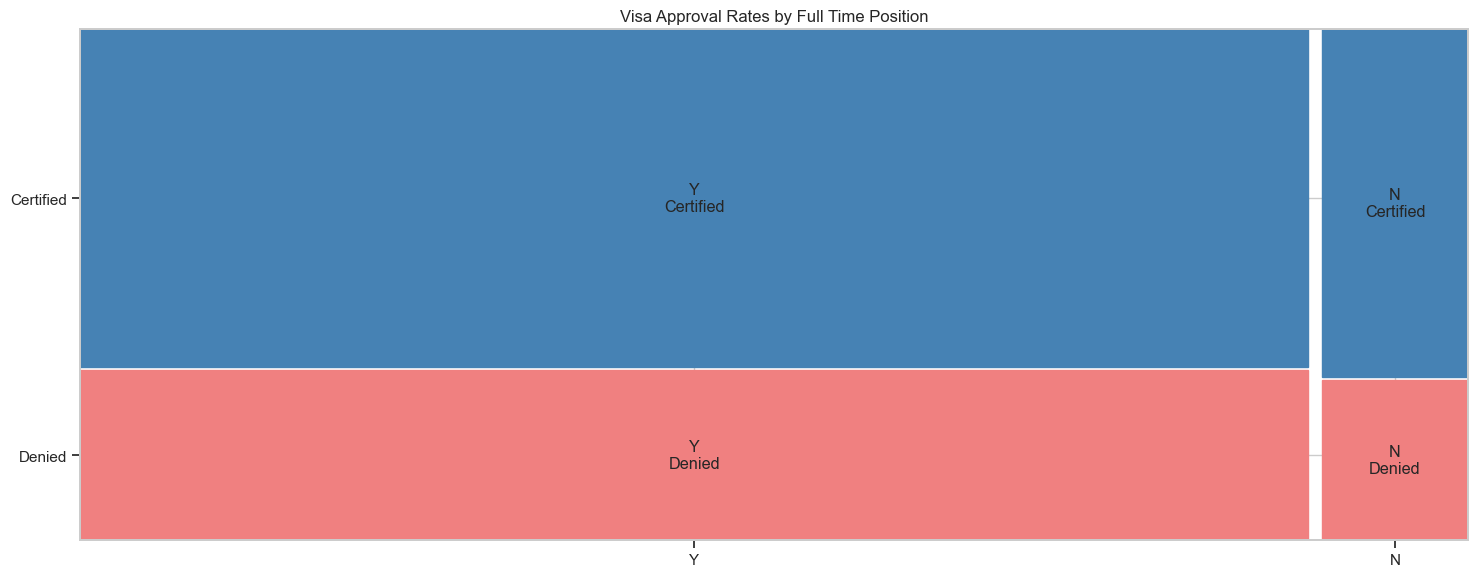

In [113]:
create_mosaic_plot(df, 'full_time_position', title='Visa Approval Rates by Full Time Position')

In [114]:
create_contingency_table(df, 'full_time_position', pct=True)

case_status,Certified,Denied
full_time_position,,
N,68.53,31.47
Y,66.58,33.42


🔍 Points: 

1. **Full-time positions dominate**: The vast majority (89.4%) of visa applications are for full-time positions, creating a highly imbalanced feature.

2. The similar approval rates suggest that full-time status alone isn't a strong predictor of visa outcomes.

**Business insight**: The similar approval rates suggest that immigration authorities don't strongly discriminate between full-time and part-time positions in their decision-making process.

This feature, despite its business importance, may not contribute significantly to predictive power in your models due to the similar approval patterns across its categories.

## NOTES - Tree Models

🧠 **Remember**

- Trees naturally handle outliers by creating separate branches.
- They are less sensitive to distribution shape
- Can naturally adapt to skewed distributions
- Create splits that capture data patterns regardless of Symmetry

If the rare class correlates too strongly with the target, it **could** lead to overfitting, especially in small datasets.  

However, in **large datasets and ensemble methods**, trees tend to generalize well because:  
1. **Bootstrap sampling (in Random Forest)** reduces reliance on any single split.  
2. **Regularization (in Gradient Boosting)** helps control overfitting.  
3. **Tree depth limits** prevent overly specific patterns from dominating.  

So, while rarity **can** be a red flag, it’s not always a problem if handled correctly.

📌 **Log Transformation & Tree based Model:**

🌳 **How Decision Trees Work**  
- Trees split data at specific thresholds (e.g., **no_of_employees > 5000**).  
- Log transformation **won’t change the relative order** of values—so splits remain the same.  
- However, **the depth & interpretability might change** because transformed values are harder to relate to the original scale.  

✅ **Bottom Line**  
- **Not needed for trees** (they handle skew naturally).  
- **Useful for linear models** (like Logistic Regression).  
- **Won’t hurt trees significantly**, but may make splits harder to interpret.  



## PreProcessing 

In [115]:
#Why (Good Practice)
# ? -> Clear seperation between EDA & Preprocessing (Phases)
#1. Any accidental modifications made during EDA won't affect your preprocessing
#2. starting with clean data for the preprocessing phase
df = df_original.copy()

#### 1. Negative Value Treatment

In [116]:
# find columns with negative values
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns


In [117]:
negative_cols = [col for col in numeric_cols if df[col].min() < 0]
print(negative_cols)

['no_of_employees']


**No Of Employees**
- It seems to be data entry error, where negative sign was entered by mistake.
- Generally company is formed with some count of employees, so not using 0
- Negative employee counts are logically impossible

In [118]:
# Convert negative employee counts to absolute values
print(f"Number of negative employee counts before: {(df['no_of_employees'] < 0).sum()}")
df['no_of_employees'] = df['no_of_employees'].abs()
print(f"Number of negative employee counts after: {(df['no_of_employees'] < 0).sum()}")

Number of negative employee counts before: 33
Number of negative employee counts after: 0


📌 **There are no Missing Values and Duplicate Values**

#### 2. Outlier Detection

In [119]:
# Outlier Detection using IQR method and Z-Score

outlier_stats = {}
for col in numeric_cols:
    # IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    outliers_iqr = df[(df[col] < lower_bound_iqr) | (df[col] > upper_bound_iqr)][col]

    # Z-Score method
    #***
    # Why abs()
    # It's required to take the absolute value of z-scores when detecting outliers.
    # This is because outliers can be
    # either unusually high (positive z-score) or unusually low (negative z-score),
    # and we're interested in the magnitude of deviation from the mean, not the direction.
    #***
    z_scores = np.abs(zscore(df[col]))
    zscore_outlier_count = np.sum(z_scores > 3)
    zscore_outlier_percentage = (zscore_outlier_count / len(df)) * 100

    outlier_stats[col] = {
        'min': df[col].min(),
        'max': df[col].max(),
        'iqr_outlier_count': len(outliers_iqr),
        'iqr_outlier_percentage': (len(outliers_iqr) / len(df)) * 100,
        'zscore_outlier_count': zscore_outlier_count,
        'zscore_outlier_percentage': zscore_outlier_percentage,
    }

# Display outlier statistics
for col, stats in outlier_stats.items():
    print(f"\n{col}:")
    print(f"IQR Method - Number of outliers: {stats['iqr_outlier_count']}")
    print(f"IQR Method - Percentage of outliers: {stats['iqr_outlier_percentage']:.2f}%")
    print(f"Z-Score Method - Number of outliers: {stats['zscore_outlier_count']}")
    print(f"Z-Score Method - Percentage of outliers: {stats['zscore_outlier_percentage']:.2f}%")
    print(f"Range: {stats['min']} to {stats['max']}")


no_of_employees:
IQR Method - Number of outliers: 1556
IQR Method - Percentage of outliers: 6.11%
Z-Score Method - Number of outliers: 429
Z-Score Method - Percentage of outliers: 1.68%
Range: 11 to 602069

yr_of_estab:
IQR Method - Number of outliers: 3260
IQR Method - Percentage of outliers: 12.79%
Z-Score Method - Number of outliers: 695
Z-Score Method - Percentage of outliers: 2.73%
Range: 1800 to 2016

prevailing_wage:
IQR Method - Number of outliers: 427
IQR Method - Percentage of outliers: 1.68%
Z-Score Method - Number of outliers: 294
Z-Score Method - Percentage of outliers: 1.15%
Range: 2.1367 to 319210.27


👀 As we can see, `no_of_employees` and `yr_of_esatb` has many outliers.

Since we will using tree-based models, they are less sensitive to the actual numeric values & **invariant** to **monotonic transformations**.

> 💡 **Trees make splits based on the relative ordering of values, not their absolute scale (ie Unbothered of scale/outlier, mostly)**



##### **Binning**

Binning creates interpretable categories that align with business understanding while preserving the meaningful distinctions in the data.
- If bins show clear separation in target variable trends, they might be useful.
- If the binned feature isn't useful, the model will simply ignore it without degrading performance.

Hence there is nothing to loose in introducing new **derived features** (ie Binned Features) for corresponding numerical columns.


In [120]:
# Total columns in df (before binning)
print('Total columns in df (before binning) = ', len(df.columns))

Total columns in df (before binning) =  12


**1. Company Size (no_of_employees)**

In [121]:
# Create company size categories
bins = [0, 50, 250, 1000, 10000, float("inf")]
labels = [
    "Micro (1-50)",
    "Small (51-250)",
    "Medium (251-1000)",
    "Large (1001-10000)",
    "Enterprise (>10000)"
]

# Create new binned feature
df['company_size'] = pd.cut(
    # Handle negative values (to be on safe side)
    df["no_of_employees"].clip(lower=0),
    bins=bins,
    labels=labels
)

# Check the distribution
df['company_size'].value_counts()

Large (1001-10000)     17803
Medium (251-1000)       4702
Enterprise (>10000)     1436
Small (51-250)          1290
Micro (1-50)             249
Name: company_size, dtype: int64

In [122]:
# check if summ of all counts is equal to total rows
print(df["company_size"].value_counts().sum())
print(len(df))


25480
25480


In [123]:
# print few rows no_of_employees & company_size
df[['no_of_employees', 'company_size']].head()

,no_of_employees,company_size
0,14513,Enterprise (>10000)
1,2412,Large (1001-10000)
2,44444,Enterprise (>10000)
3,98,Small (51-250)
4,1082,Large (1001-10000)


**2. Company Era (yr_of_estab)**

The five company era categories represent distinct business and technological periods:

- Before 1950 → **Legacy**  (Manufacturing, Energy, Banking)
- 1950 - 1979 → **Traditional Era** (Aerospace, Engineering, Automotive)
- 1980 - 1999 → **Growth Phase** (IT Services, Finance, Consulting)
- 2000 - 2010 → **Digital Transition Era** (IT, Startups, E-commerce, Construction, Healthcare)
- 2011 - 2016 → **AI & Mobile Era** (AI, Gig Work, Logistics, FinTech, Cloud)

In [124]:
# min and max of yr_of_estab
print(df["yr_of_estab"].min())
print(df["yr_of_estab"].max())

1800
2016


In [125]:
# Create company era categories
# *?
# NOTE: for any 2 point in bins bin is decided like for example
# Assuming x-1 and z are extreme points of your dataset
#  [x, y, z] then
#  - bin 1 is (x, y]
#  - bin 2 is (y, z]
# **
# Why 1799 -> 1800 - 1  // so that 1800 gets acounted
# End 2016 -> becasuse end is inclusive
bins = [1799, 1949, 1979, 1999, 2010, 2016]
labels = [
    "Legacy (Before 1950)",
    "Traditional Era (1950-1979)",
    "Growth Phase (1980-1999)",
    "Digital Transition Era (2000-2010)",
    "AI & Mobile Era (2011-2016)",
]

# Create new binned feature
df["company_era"] = pd.cut(
    df["yr_of_estab"],
    bins=bins,
    labels=labels,
)

# Check the distribution
df["company_era"].value_counts()

Digital Transition Era (2000-2010)    8664
Growth Phase (1980-1999)              7825
Legacy (Before 1950)                  4052
Traditional Era (1950-1979)           3134
AI & Mobile Era (2011-2016)           1805
Name: company_era, dtype: int64

In [126]:
# check if summ of all counts is equal to total rows
print(df["company_era"].value_counts().sum())
print(len(df))


25480
25480


In [127]:
# print few rows yr_of_estab & company_era
df[["yr_of_estab", "company_era"]].head()

,yr_of_estab,company_era
0,2007,Digital Transition Era (2000-2010)
1,2002,Digital Transition Era (2000-2010)
2,2008,Digital Transition Era (2000-2010)
3,1897,Legacy (Before 1950)
4,2005,Digital Transition Era (2000-2010)


In [128]:
# check for year of estab 1800
df[df["yr_of_estab"] == 1800].head()


,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_size,company_era
599,EZYV600,Asia,Doctorate,Y,N,2467,1800,South,62487.14,Year,Y,Certified,Large (1001-10000),Legacy (Before 1950)
1279,EZYV1280,Asia,Bachelor's,N,Y,2014,1800,South,68613.70,Year,Y,Certified,Large (1001-10000),Legacy (Before 1950)
1472,EZYV1473,Europe,Doctorate,Y,N,1561,1800,South,43420.11,Year,Y,Certified,Large (1001-10000),Legacy (Before 1950)
1882,EZYV1883,South America,Master's,N,Y,3814,1800,Northeast,78340.74,Year,Y,Denied,Large (1001-10000),Legacy (Before 1950)
6083,EZYV6084,Asia,Master's,N,N,1604,1800,Midwest,73305.46,Year,Y,Certified,Large (1001-10000),Legacy (Before 1950)


<Figure size 1200x800 with 0 Axes>

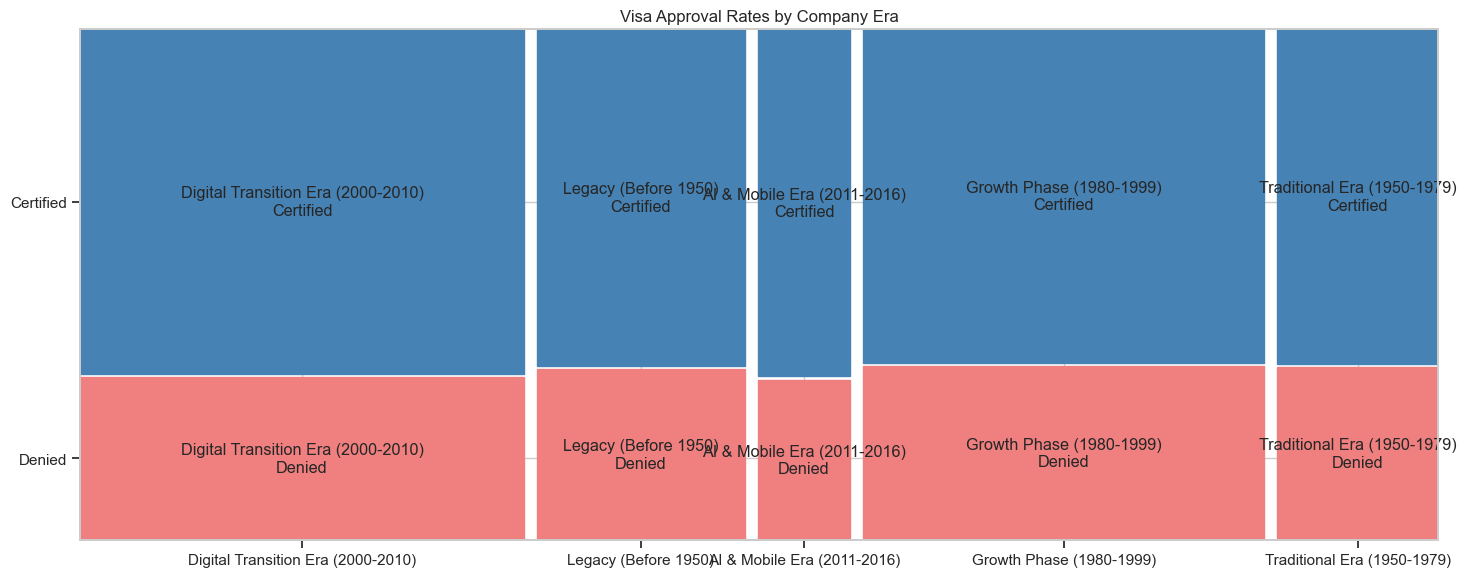

In [129]:
# Let see mosaic plot to check dominance of category and splitting ability at high level
create_mosaic_plot(df, 'company_era', title='Visa Approval Rates by Company Era')

👀 Observation 
- Most of application in data are from Growth and Digital TransitionEra
- It seems that Mobile Era has less application comparatively in dataset but splitting ability seems uniform across all !! (Inface Ai-Mobile Era takes slight edge in that !!)

**3. Wage Category (prevailing_wage)**

In [130]:
# min and max of prevailing_wage
print(df["prevailing_wage"].min())
print(df["prevailing_wage"].max())

2.1367
319210.27


> ❗ Make sure the bins extremes must respect and include min-max of respective feature

In [131]:
# Create wage categories
bins = [0, 40_000, 80_000, 150_000, 3_20_000]
labels = [
    "Entry-level ($0-40K)",
    "Mid-level ($40K-80K)",
    "Professional ($80K-150K)",
    "Executive (>$150K)",
]
# Create new binned feature
df["wage_category"] = pd.cut(df["prevailing_wage"], bins=bins, labels=labels)

In [132]:
# Check the distribution
print("Distribution of wage categories:")
print(df['wage_category'].value_counts())

print("\nPercentage distribution:")
print(df['wage_category'].value_counts(normalize=True) * 100)

Distribution of wage categories:
Professional ($80K-150K)    9183
Entry-level ($0-40K)        7294
Mid-level ($40K-80K)        7165
Executive (>$150K)          1838
Name: wage_category, dtype: int64

Percentage distribution:
Professional ($80K-150K)   36.04
Entry-level ($0-40K)       28.63
Mid-level ($40K-80K)       28.12
Executive (>$150K)          7.21
Name: wage_category, dtype: float64


In [133]:
# show few rows of prevailing_wage & wage_category
df[["prevailing_wage", "wage_category"]].head()

,prevailing_wage,wage_category
0,592.20,Entry-level ($0-40K)
1,83425.65,Professional ($80K-150K)
2,122996.86,Professional ($80K-150K)
3,83434.03,Professional ($80K-150K)
4,149907.39,Professional ($80K-150K)


In [134]:
# check if summ of all counts is equal to total rows
print(df["wage_category"].value_counts().sum())
print(len(df))

25480
25480


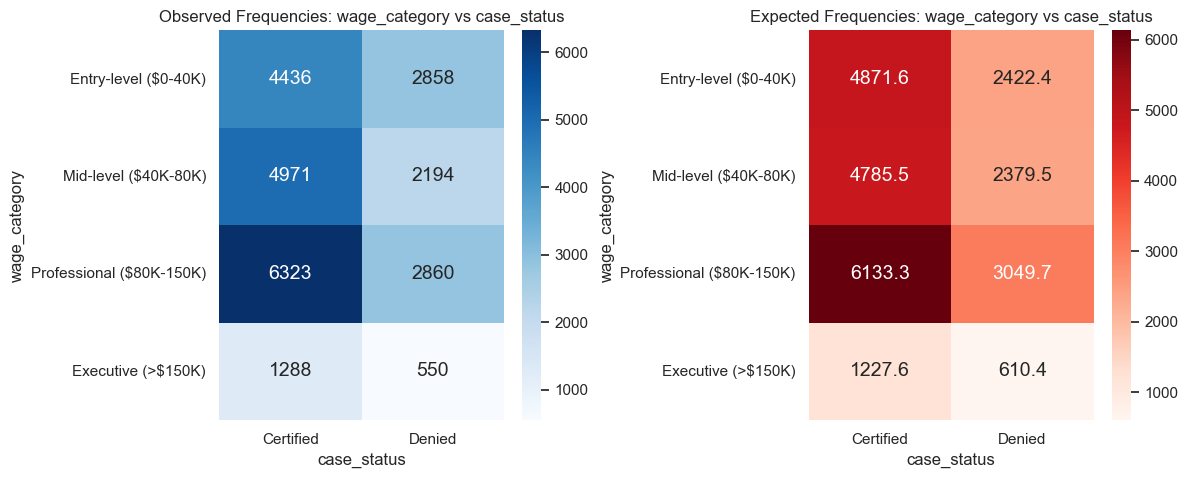

Chi-Square Statistic: 165.58
P-value: 0.0000
Reject H₀: There is a significant relationship between wage_category and case_status


In [135]:
# Check relationship with target variable
perform_chi_square_test(df, 'wage_category')

> NOTE: Graph for same we already saw during EDA

In [136]:
df['case_status'].value_counts()

Certified    17018
Denied        8462
Name: case_status, dtype: int64

#### 📌 **REMEMBER**

**Target vs. Feature Encoding: Key Differences**

**Target Variable**:
- Simple label substitution (e.g., "Certified" → 1)
- No learning involved, just renaming
- Can be done before or after splitting
- Not susceptible to data leakage
- Not used as input to anything

**Feature Variables**:
- Encoding learns from data distribution
- Must be learned from training data only
- Must be done after train-test split
- Susceptible to data leakage if done incorrectly
- Used as **input** to a model

In simple terms: Target encoding just renames classes, while feature encoding is part of what your model learns from.

The target variable is not an input feature; it does not contribute to learning patterns.

🚀 **Target encoding is just a simple mapping, not a learned transformation.**

> Hence Doing Target Encoding before Split here itself !!

In [137]:
df['case_status'].unique()

array(['Denied', 'Certified'], dtype=object)

In [138]:
df['case_status'].value_counts()

Certified    17018
Denied        8462
Name: case_status, dtype: int64

In [139]:
df['case_status'].dtype  # object/string

dtype('O')

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_id                25480 non-null  object  
 1   continent              25480 non-null  object  
 2   education_of_employee  25480 non-null  object  
 3   has_job_experience     25480 non-null  object  
 4   requires_job_training  25480 non-null  object  
 5   no_of_employees        25480 non-null  int64   
 6   yr_of_estab            25480 non-null  int64   
 7   region_of_employment   25480 non-null  object  
 8   prevailing_wage        25480 non-null  float64 
 9   unit_of_wage           25480 non-null  object  
 10  full_time_position     25480 non-null  object  
 11  case_status            25480 non-null  object  
 12  company_size           25480 non-null  category
 13  company_era            25480 non-null  category
 14  wage_category          25480 non-null 

In [141]:
# In-Place Target Encoding

# Encode target variable: Certified -> 1, Denied -> 0
df['case_status'] = df['case_status'].map({'Certified': 1, 'Denied': 0})

# Verify the encoding
print(df['case_status'].value_counts())

1    17018
0     8462
Name: case_status, dtype: int64


In [142]:
df['case_status'].dtype

dtype('int64')

📌 NOTE

1. Machine learning algorithms work better with numeric data types
2. Integer encoding is more memory-efficient than object/string types
3. Most sklearn estimators expect numeric target variables

> Though for Tree based models its not strictly needed to go from string to int but if performed then it will not cut us out anything less !!

In [143]:
print('Total columns in df (after binning) = ', len(df.columns))

Total columns in df (after binning) =  15


> 3 new added (ie 12 + 3)

#### Drop unneeded columns

In [144]:
# drop case_id
df.drop('case_id', axis=1, inplace=True)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  object  
 1   education_of_employee  25480 non-null  object  
 2   has_job_experience     25480 non-null  object  
 3   requires_job_training  25480 non-null  object  
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  object  
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  object  
 9   full_time_position     25480 non-null  object  
 10  case_status            25480 non-null  int64   
 11  company_size           25480 non-null  category
 12  company_era            25480 non-null  category
 13  wage_category          25480 non-null  category
dtypes: category(3), float64(1), int64(3), 

## Feature Engineering

In [146]:
# Check the total number of rows
df.shape

(25480, 14)

💡 **Let's Categorize Columns based on their nature**

1. **Ordinal Encoding (natural ordering exists)**
   1. 
- `education_of_employee` (High School < Bachelor's < Master's < Doctorate)
- 
- `company_size` (Micro < Small < Medium < Large < Enterprise)
- 
- `company_era` (Legacy < Traditional < Growth < Digital < AI)

##### **Ordinal Encoding Prep**

If we use `OrdinalEncoder()` without specifying categories, it will **assign numbers based on first appearance**, which can lead to incorrect ordering.

**Why Explicit Ordering?**

For example, if Education Level is encoded automatically, it might assign:

Bachelor → 0    // if Row with Bachelor comes up (in sample)
High School → 1
PhD → 2

This is incorrect because the order should be:
> High School (0) < Bachelor (1) < Master (2) < PhD (3)


🧠 **REMEMBER**

OrdinalEncoder only works on matrices (2D arrays). 

1. Takes input as a 2D array
2. Returns output as a 2D array

That's why we use:
```python
encoder.fit_transform(df[['education_of_employee']])  # Double brackets create a 2D array
```

Instead of:
```python
encoder.fit_transform(df['education_of_employee'])  # This would fail - it's a 1D Series
```

In [147]:
ordinal_cols = [
    'education_of_employee',
    'company_size',
    'company_era',
    'wage_category'
]

In [148]:
# Define Categorical Order for Each Column that needs Ordinal Encoding
education_of_employee_cats = []
company_size_cats = []
company_era_cats = []
wage_category_cats = []

In [149]:
# Get unique values in their current order
for col in ordinal_cols:
    categories = df[col].unique()
    print(f"\nCurrent unique categories for {col}:")
    for cat in categories:
        print(f"- {cat}")



Current unique categories for education_of_employee:
- High School
- Master's
- Bachelor's
- Doctorate

Current unique categories for company_size:
- Enterprise (>10000)
- Large (1001-10000)
- Small (51-250)
- Medium (251-1000)
- Micro (1-50)

Current unique categories for company_era:
- Digital Transition Era (2000-2010)
- Legacy (Before 1950)
- AI & Mobile Era (2011-2016)
- Growth Phase (1980-1999)
- Traditional Era (1950-1979)

Current unique categories for wage_category:
- Entry-level ($0-40K)
- Professional ($80K-150K)
- Mid-level ($40K-80K)
- Executive (>$150K)


In [150]:
df['education_of_employee'].unique()

array(['High School', "Master's", "Bachelor's", 'Doctorate'], dtype=object)

**1. Education of Employees**

In [151]:
education_of_employee_cats = [
    'High School',
    "Bachelor's",
    "Master's",
    'Doctorate'
]

In [152]:
encoder = OrdinalEncoder(categories=[education_of_employee_cats])
transformed = encoder.fit_transform(df[['education_of_employee']]).ravel()

In [153]:
df['education_of_employee'].value_counts()

Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64

In [154]:
# Get unique values and their counts
pd.Series(transformed).value_counts()

1.00    10234
2.00     9634
0.00     3420
3.00     2192
dtype: int64

Verified Safe

**2. Company Size**

In [155]:
df['company_size'].unique()

['Enterprise (>10000)', 'Large (1001-10000)', 'Small (51-250)', 'Medium (251-1000)', 'Micro (1-50)']
Categories (5, object): ['Micro (1-50)' < 'Small (51-250)' < 'Medium (251-1000)' < 'Large (1001-10000)' < 'Enterprise (>10000)']

In [156]:
company_size_cats = [
    'Micro (1-50)',
    'Small (51-250)',
    'Medium (251-1000)',
    'Large (1001-10000)',
    'Enterprise (>10000)'
]
encoder = OrdinalEncoder(categories=[company_size_cats])
transformed = encoder.fit_transform(df[['company_size']]).ravel()

In [157]:
df['company_size'].value_counts()

Large (1001-10000)     17803
Medium (251-1000)       4702
Enterprise (>10000)     1436
Small (51-250)          1290
Micro (1-50)             249
Name: company_size, dtype: int64

In [158]:
pd.Series(transformed).value_counts()

3.00    17803
2.00     4702
4.00     1436
1.00     1290
0.00      249
dtype: int64

Verified ✔️

**3. Company Era**

In [159]:
df['company_era'].unique()

['Digital Transition Era (2000-2010)', 'Legacy (Before 1950)', 'AI & Mobile Era (2011-2016)', 'Growth Phase (1980-1999)', 'Traditional Era (1950-1979)']
Categories (5, object): ['Legacy (Before 1950)' < 'Traditional Era (1950-1979)' < 'Growth Phase (1980-1999)' < 'Digital Transition Era (2000-2010)' < 'AI & Mobile Era (2011-2016)']

In [160]:
company_era_cats = [
    'Legacy (Before 1950)',
    'Traditional Era (1950-1979)',
    'Growth Phase (1980-1999)',
    'Digital Transition Era (2000-2010)',
    'AI & Mobile Era (2011-2016)',
]
encoder = OrdinalEncoder(categories=[company_era_cats])
transformed = encoder.fit_transform(df[['company_era']]).ravel()

In [161]:
df['company_era'].value_counts()

Digital Transition Era (2000-2010)    8664
Growth Phase (1980-1999)              7825
Legacy (Before 1950)                  4052
Traditional Era (1950-1979)           3134
AI & Mobile Era (2011-2016)           1805
Name: company_era, dtype: int64

In [162]:
pd.Series(transformed).value_counts()

3.00    8664
2.00    7825
0.00    4052
1.00    3134
4.00    1805
dtype: int64

Verified ✔️

**4. Wage Category**

In [163]:
df['wage_category'].unique()

['Entry-level ($0-40K)', 'Professional ($80K-150K)', 'Mid-level ($40K-80K)', 'Executive (>$150K)']
Categories (4, object): ['Entry-level ($0-40K)' < 'Mid-level ($40K-80K)' < 'Professional ($80K-150K)' < 'Executive (>$150K)']

In [164]:
wage_category_cats = [
    'Entry-level ($0-40K)',
    'Mid-level ($40K-80K)',
    'Professional ($80K-150K)',
    'Executive (>$150K)',
]
encoder = OrdinalEncoder(categories=[wage_category_cats])
transformed = encoder.fit_transform(df[['wage_category']]).ravel()

In [165]:
df['wage_category'].value_counts()

Professional ($80K-150K)    9183
Entry-level ($0-40K)        7294
Mid-level ($40K-80K)        7165
Executive (>$150K)          1838
Name: wage_category, dtype: int64

In [166]:
pd.Series(transformed).value_counts()

2.00    9183
0.00    7294
1.00    7165
3.00    1838
dtype: int64

Verified ✔️

🚀 From Distribution Count all seems good

In [167]:
ordinal_cols_cats = [
    education_of_employee_cats,
    company_size_cats,
    company_era_cats,
    wage_category_cats
]

##### **One Hot Encoding Prep**

In [168]:
# You can’t say "hourly < weekly < monthly < yearly" in a strict sense
# because conversion depends on actual wages, not a fixed ranking
ohe_cols = [
    'continent',
    'region_of_employment',
    'unit_of_wage',
]

##### **Binary Encoding Prep**

In [169]:
# let see 3 cols data
print(df['has_job_experience'].unique())
print(df['requires_job_training'].unique())
print(df['full_time_position'].unique())

['N' 'Y']
['N' 'Y']
['Y' 'N']


In [170]:
binary_cols = [
    'has_job_experience',
    'requires_job_training',
    'full_time_position'
]

In [171]:
binary_cats = ['N', 'Y']

In [172]:
# Why repeated 3 times ?
# Because OrdinalEncoder needs same shape as input matrix for param categories
# TODO: Find Good way to address this Binary Encoding Maybe CustomLabelEncoder class that overcomes current limitations of LabelEncoder can be used instead of ordinal encoding
binary_cols_cats = [
    binary_cats,
    binary_cats,
    binary_cats
]

1. Has Job Experience

In [173]:
encoder = OrdinalEncoder(categories=[binary_cats])
transformed = encoder.fit_transform(df[['has_job_experience']]).ravel()


In [174]:
df['has_job_experience'].value_counts()


Y    14802
N    10678
Name: has_job_experience, dtype: int64

In [175]:
# Verified ✔️
pd.Series(transformed).value_counts()


1.00    14802
0.00    10678
dtype: int64

2 Requires Job training

In [176]:
encoder = OrdinalEncoder(categories=[binary_cats])
transformed = encoder.fit_transform(df[['requires_job_training']]).ravel()

In [177]:
df['requires_job_training'].value_counts()

N    22525
Y     2955
Name: requires_job_training, dtype: int64

In [178]:
pd.Series(transformed).value_counts()


0.00    22525
1.00     2955
dtype: int64

3. Full time Position

In [179]:
encoder = OrdinalEncoder(categories=[binary_cats])
transformed = encoder.fit_transform(df[['full_time_position']]).ravel()

In [180]:
df['full_time_position'].value_counts()

Y    22773
N     2707
Name: full_time_position, dtype: int64

In [181]:
pd.Series(transformed).value_counts()

1.00    22773
0.00     2707
dtype: int64

In [182]:
df.columns

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status', 'company_size', 'company_era',
       'wage_category'],
      dtype='object')

👀 **Before Split (Actions Performed)**

✅ Handling Negative Values (Converted to absolute values)  
✅ Feature Engineering (Added derived columns like `company_size`, `company_era`, `wage_category`)  
✅ Target Encoding (`Certified` → `1`, `Denied` → `0`)  
✅ Categorical Encoding Meta (Prepared encoding strategies: Ordinal, One-Hot, and Binary Encoding)  
✅ Outlier Handling (Instead of log transformation, we applied binning since tree-based models are not affected by scale, mostly)  

🔲 Missing Value Handling → There are no duplicates or missing values

#### **Train Test Split**

🧠 **REMEMBER** 

For imbalanced datasets, these are important considerations:

1. `stratify=y` during train-test split (which we're doing now)
2. `class_weight='balanced'` during model training
3. `average='weighted'` when calculating metrics like precision, recall, and F1

These approaches will help ensure the models properly account for the class imbalance rather than just optimizing for the majority class.


In [183]:
# Check total rows
df.shape

(25480, 14)

In [184]:
df['case_status'].value_counts()

1    17018
0     8462
Name: case_status, dtype: int64

In [185]:
# Separate features and target
X = df.drop('case_status', axis=1)
y = df['case_status']

# The stratify=y parameter ensures that the class distribution
# in the train and test sets matches the original distribution,
# which is important for imbalanced datasets.

# Create train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [186]:
# Verify the split
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set distribution:\n{y_train.value_counts()}")
print(f"Testing set distribution:\n{y_test.value_counts()}")

Training set shape: (20384, 13)
Testing set shape: (5096, 13)
Training set distribution:
1    13614
0     6770
Name: case_status, dtype: int64
Testing set distribution:
1    3404
0    1692
Name: case_status, dtype: int64


## Modeling

#### Utils

In [187]:
# a function to compute different metrics to check performance of a classification model built using sklearn
def get_classification_metrics(y, y_pred):
    """
    Function to compute different metrics to check classification model performance

    Parameters:
        y: dependent variable/ground truth labels
        y_pred: predicted target values

    Returns:
        pd.DataFrame containing model performance metrics (Accuracy, Recall, Precision, F1)
    """
    # compute various metrics
    acc = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    # intentionally commented below 2 lines as we will focus on main 4 metrics once model is built
    #f1_weighted = f1_score(y, y_pred, average='weighted')
    #recall_weighted = recall_score(y, y_pred, average='weighted')

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            #"F1_Weighted": f1_weighted,
            #"Recall_Weighted": recall_weighted
        },
        index=[0]
    )

    return df_perf

In [224]:
# Helper function to remove transformer prefix from pipeline's transformed column name
def remove_pipeline_step_prefix(name):
    return name.split("__")[-1]  # Removes transformer prefix

In [282]:
def get_feature_importances(model, columnNames):
    """
    Get feature importances from a trained model.

    Args:
        model: model
        columnNames: Name of the features

    Returns:
        DataFrame with feature names and their importance scores, sorted by importance
    """
    importances = pd.DataFrame({
        'feature': columnNames,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return importances

In [242]:
def plot_feature_importance(importances, top_n=None):
    """
    Plot feature importances as a horizontal bar chart.

    Parameters:
        importances: DataFrame with 'feature' and 'importance' columns
        figsize: tuple, size of the figure (width, height)
        top_n: int, optional number of top features to show (shows all if None)
    """
    # Create copy to avoid modifying original
    df = importances.copy()

    # Limit to top N features if specified
    if top_n is not None:
        df = df.head(top_n)

    # Sort by importance
    df = df.sort_values('importance', ascending=False)

    sns.barplot(x='importance', y='feature', data=df)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

#### GLOBALS

Let's create results to hold scores for each model we are going to build

In [189]:
# score map
# Model Results
results = dict()

🧠 **REMEMBER** (PIPELINE)

Why **Pipeline** over Conventional way of Modeling ?

1. Consistent feature transformation across all models
2. No data leakage between training and testing sets
3. Fair comparison between different models and sampling techniques
4. Code reusability and maintainability

The preprocessing step in our pipeline will remain the same across all models we build

The only thing that will change between pipelines is the sampling technique and the model type/parameters.


🚀 **Hence lets create common Steps-Utilities for Pipelines**

##### **PreProcessor**

In [190]:
X_train.columns

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'company_size', 'company_era', 'wage_category'],
      dtype='object')

In [191]:
for col, cats in zip(ordinal_cols, ordinal_cols_cats):
    print(f"{col} -> {cats}")

education_of_employee -> ['High School', "Bachelor's", "Master's", 'Doctorate']
company_size -> ['Micro (1-50)', 'Small (51-250)', 'Medium (251-1000)', 'Large (1001-10000)', 'Enterprise (>10000)']
company_era -> ['Legacy (Before 1950)', 'Traditional Era (1950-1979)', 'Growth Phase (1980-1999)', 'Digital Transition Era (2000-2010)', 'AI & Mobile Era (2011-2016)']
wage_category -> ['Entry-level ($0-40K)', 'Mid-level ($40K-80K)', 'Professional ($80K-150K)', 'Executive (>$150K)']


In [192]:
for col, cats in zip(binary_cols, binary_cols_cats):
    print(f"{col} -> {cats}")

has_job_experience -> ['N', 'Y']
requires_job_training -> ['N', 'Y']
full_time_position -> ['N', 'Y']


In [193]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=ordinal_cols_cats), ordinal_cols),
        ('binary', OrdinalEncoder(categories=binary_cols_cats), binary_cols),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), ohe_cols)
    ],
    remainder='passthrough'  # Keeps numeric columns ['no_of_employees', 'yr_of_estab', 'prevailing_wage']
)

⚡ NOTE: 

Providing categories explicitly in OrdinalEncoder ensures a consistent ordering across train and test data. While it might seem like data leakage, it's not really leakage because:

- ✅ You're not exposing test data during training.
- ✅ You're just enforcing a fixed, meaningful mapping.
- ✅ It ensures unknown values are handled predictably.

💡 NOTE: 

We set `sparse_output=False` in OneHotEncoder because:

1. Dense arrays are more compatible with most scikit-learn models
2. It makes debugging easier (you can print and inspect the transformed data)
3. For small to medium datasets, the memory advantage of sparse matrices is minimal
4. It avoids potential compatibility issues in the pipeline

This ensures our transformed data is in a standard format that works seamlessly with all models.

🧠 **REMEMBER**

`ColumnTransformer` may **change the order of columns** based on the transformers defined, resulting in a different column order than the original (input) X_train.columns.

For **feature importance**, we need to know the exact column names and order after transformation. We can get this by:

1. Fitting the preprocessor on training data
2. Extracting the feature names from the fitted transformer
3. Using these names when interpreting feature importance

This is especially important with one-hot encoding, which creates new columns that need to be properly labeled.


**Row - Index Lost & Model-Performance**
No, losing the original index in the pipeline has no impact on model performance. The model only cares about the feature values and their relationship to the target, not the row identifiers. The predictions will still align correctly with y_test when evaluating.


📌 **GIST | PIPELINE**

X_train (DataFrame) -> Pipeline --> Transformed (matrix | nd array (num))

Employing Pipeline way will impact 2 things majorly
1. **Order of columns may gets altered**
2. **Row-index wont be preserved, however entries will stay on their position !!**

⚡ NOTE: 

One-hot encoded names will be in format like 
`featurename_categoryname`

In [194]:
# Fit preprocessor on training data to get feature names
# This is only for feature interpretation purposes, not for actual transformation
preprocessor.fit(X_train)

# Get the transformed column names for later use in feature importance
transformed_feature_names = preprocessor.get_feature_names_out()

transformed_columns = [remove_pipeline_step_prefix(name) for name in transformed_feature_names]

In [195]:
print(pd.Series(transformed_columns).values)

['education_of_employee' 'company_size' 'company_era' 'wage_category'
 'has_job_experience' 'requires_job_training' 'full_time_position'
 'continent_Asia' 'continent_Europe' 'continent_North America'
 'continent_Oceania' 'continent_South America'
 'region_of_employment_Midwest' 'region_of_employment_Northeast'
 'region_of_employment_South' 'region_of_employment_West'
 'unit_of_wage_Month' 'unit_of_wage_Week' 'unit_of_wage_Year'
 'no_of_employees' 'yr_of_estab' 'prevailing_wage']


In [196]:
print('Original Columns Order')
print(X_train.columns)

Original Columns Order
Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'company_size', 'company_era', 'wage_category'],
      dtype='object')


In [197]:
X_train_transformed = preprocessor.fit_transform(X_train)
# convert to dataframe with original index (output from preprocessor will be nd array (numeric)
# not dataframe so we loose Row-Index and Column-Order both in Pipelineing)
X_train_transformed = pd.DataFrame(X_train_transformed,
                                 columns=transformed_columns,
                                 index=X_train.index)
X_train_transformed.head()

,education_of_employee,company_size,company_era,wage_category,has_job_experience,requires_job_training,full_time_position,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,no_of_employees,yr_of_estab,prevailing_wage
3516,1.00,3.00,2.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,4069.00,1984.00,61313.77
13759,1.00,3.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,3022.00,1961.00,36588.11
6019,1.00,2.00,1.00,3.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,751.00,1971.00,210280.88
779,2.00,3.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1113.00,1968.00,46457.53
22792,1.00,2.00,1.00,2.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,796.00,1979.00,89542.27


In [198]:
X_train.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_size,company_era,wage_category
3516,Asia,Bachelor's,Y,N,4069,1984,South,61313.77,Year,Y,Large (1001-10000),Growth Phase (1980-1999),Mid-level ($40K-80K)
13759,Asia,Bachelor's,Y,N,3022,1961,Midwest,36588.11,Year,Y,Large (1001-10000),Traditional Era (1950-1979),Entry-level ($0-40K)
6019,North America,Bachelor's,N,N,751,1971,South,210280.88,Year,Y,Medium (251-1000),Traditional Era (1950-1979),Executive (>$150K)
779,Asia,Master's,Y,N,1113,1968,Northeast,46457.53,Year,Y,Large (1001-10000),Traditional Era (1950-1979),Mid-level ($40K-80K)
22792,North America,Bachelor's,Y,N,796,1979,West,89542.27,Year,Y,Medium (251-1000),Traditional Era (1950-1979),Professional ($80K-150K)


This looks correct for pipeline's transformation. ✔️

1. The 4 ordinal columns (education_of_employee, company_size, company_era, wage_category)
2. The 3 binary columns (has_job_experience, requires_job_training, full_time_position)
3. One-hot encoded columns for:
   - continent (5 categories, with one dropped as reference)
   - region_of_employment (4 categories, with one dropped)
   - unit_of_wage (3 categories, with one dropped)
4. The 3 numeric columns passed through (no_of_employees, yr_of_estab, prevailing_wage)

This matches what we would expect from your ColumnTransformer setup.

*Verified*

> This will happen inside the pipeline when we activate it !

##### **UpSampler**

🧠 Remember

**SMOTE vs SMOTE-NC**

While SMOTE will work mathematically, it can create synthetic samples with values that don't make sense for encoded categorical features.

SMOTENC would be ideal as it respects the categorical nature of features even after encoding & 
Originally most of column in our dataset are categorical

🎯 **Rule of thumb**

1. Use SMOTE if all features are Numeric
2. Use SMOTE-NC if any feature is Ordinal/Label Encoded

> SMOTENC will respect the discrete nature of these features and prevent generating invalid intermediate values like 1.5 for categorical features.

In [199]:
print('\n'.join(transformed_columns))

education_of_employee
company_size
company_era
wage_category
has_job_experience
requires_job_training
full_time_position
continent_Asia
continent_Europe
continent_North America
continent_Oceania
continent_South America
region_of_employment_Midwest
region_of_employment_Northeast
region_of_employment_South
region_of_employment_West
unit_of_wage_Month
unit_of_wage_Week
unit_of_wage_Year
no_of_employees
yr_of_estab
prevailing_wage


NOTE: 

The categorical_features parameter in SMOTENC refers only to the feature matrix (X) and has nothing to do with the target variable (y).

In [200]:
# Total number of features after transformation
n_features = len(transformed_columns)

# All columns except the last 3 are categorical
categorical_features = list(range(n_features - 3))
categorical_features

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [206]:
# Create oversampling step with SMOTENC
oversampler = SMOTENC(
    categorical_features=categorical_features,
    random_state=42,
    sampling_strategy='auto'  # Will balance classes by default
)

##### **UnderSampling**

🧠 REMEMBER: 

Since undersampling just selects existing points rather than creating new ones, there's no risk of generating invalid categorical values.

In [207]:
# Create undersampling step
undersampler = RandomUnderSampler(
    random_state=42,
    sampling_strategy='auto'  # Will balance classes by default
)

#### **PipeLines | Modeling**

In [201]:
# Check class imbalance in train set
y_train.value_counts(normalize=True).mul(100).round(2)


1   66.79
0   33.21
Name: case_status, dtype: float64

> Such Imbalance to Rare (ie Denied) class is common

🧐 **Focus Metric**

Recall or F1-Score ?

1. **Regulatory perspective**: The visa program's purpose is to protect US workers while allowing qualified foreign workers. Missing a case that should be denied (false negative) could undermine this protection.

2. **Cost of errors**: 
   - False positive (predicting Certified when actually Denied): Could allow unqualified applicants through, potentially affecting US labor market
   - False negative (predicting Denied when actually Certified): Delays a qualified applicant, but they can appeal or reapply

3. **Practical implementation**: A model with high recall for "Denied" ensures suspicious applications get proper human review, while clear approvals can be processed more efficiently.

The consequences of incorrectly approving an application that should be denied are typically more serious than incorrectly flagging an application for review.

##### 1. Default Decision Tree

In [202]:
# Create pipeline with preprocessing and default decision tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Fit the pipeline on training data
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = dt_pipeline.predict(X_test)

In [203]:
dt_result = get_classification_metrics(y_test, y_pred)
dt_result

,Accuracy,Recall,Precision,F1
0,0.66,0.75,0.74,0.74


🔍 Observation

- The model is performing better than random (which would be ~0.67 for majority class prediction)
- Atleast F1 and Recall and Precision are almost similar | Hence decent
- Can be a good baseline model !

In [204]:
# register result
results['dt'] = dt_result

##### 2. Decision Tree + UpSampling

In [212]:
# Create pipeline with preprocessing, oversampling, and decision tree
dt_oversampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', oversampler),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline on training data
dt_oversampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = dt_oversampled_pipeline.predict(X_test)

In [213]:
dt_oversampled_result = get_classification_metrics(y_test, y_pred)
dt_oversampled_result

,Accuracy,Recall,Precision,F1
0,0.64,0.70,0.75,0.72


In [214]:
results['dt_up'] = dt_oversampled_result

##### 3. Decision Tree + DownSampling

In [215]:
# Create pipeline with preprocessing, undersampling, and decision tree
dt_undersampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', undersampler),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline on training data
dt_undersampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = dt_undersampled_pipeline.predict(X_test)

In [216]:
dt_undersampled_result = get_classification_metrics(y_test, y_pred)
dt_undersampled_result

,Accuracy,Recall,Precision,F1
0,0.63,0.62,0.77,0.69


In [217]:
results['dt_down'] = dt_undersampled_result

Selected Pipeline :- Default (without sampling)

##### 4. Decision Tree (Tuned)

In [275]:
# Create the pipeline with the best sampling approach (based on your results)
# Assuming oversampling performed best
dt_tuning_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid
# ? NOTE: We add classifier__ as a prefix because we're using a pipeline in GridSearchCV.
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 15, 20],  # None allows full growth
    'classifier__min_samples_split': [2, 5, 10, 20],  # Controls minimum samples for a split
    'classifier__min_samples_leaf': [1, 2, 5, 10],  # Controls minimum samples in a leaf,
    'classifier__max_features': [None, 'sqrt', 'log2'], # Controls max features to consider during split
    'classifier__class_weight': [None, 'balanced']
}

# Create stratified k-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create grid search
grid_search = GridSearchCV(
    dt_tuning_pipeline,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    cv = stratified_cv,
    #cv=5,
)

# Fit grid search
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['High '
                                                                                                     'School',
                                                                                                     "Bachelor's",
                                                                                                     "Master's",
                                                                                                     'Doctorate'],
                                                                                                    ['Micro '
                                                                                                     '(1-50)',
                                                                                                     'Small '
                                                                                                     '(51-250)',
                                                                                                     'Medium '
                                                                                                     '(251-1000)',
                                                                                                     'Large '
                                                                                                     '(1001-10000)',
                                                                                                     'Enterpris...
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 5, 10, 15, 20],
                         'classifier__max_features': [None, 'sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=1)

In [276]:
# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 20}


In [277]:

# Create tuned model with best parameters
dt_tuned_pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            DecisionTreeClassifier(
                random_state=42,
                **{remove_pipeline_step_prefix(k): v for k, v in best_params.items()},
            ),
        ),
    ]
)

# Fit tuned model
dt_tuned_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = dt_tuned_pipeline.predict(X_test)

In [278]:
dt_tuned_result = get_classification_metrics(y_test, y_pred)
dt_tuned_result

,Accuracy,Recall,Precision,F1
0,0.73,0.91,0.74,0.82


In [279]:
results['dt_tuned'] = dt_tuned_result

🎯 **Points**

Tuned model for Decision Tree shows significant improvement compare to its counterpart.

- The tuned model is much better at identifying positive cases
- The overall performance (F1) is substantially better

The hyperparameter tuning was effective at improving the model

In [283]:
model = dt_tuned_pipeline.named_steps['classifier']
feat_importances = get_feature_importances(model, transformed_columns)
feat_importances

,feature,importance
0,education_of_employee,0.46
4,has_job_experience,0.21
18,unit_of_wage_Year,0.11
8,continent_Europe,0.07
21,prevailing_wage,0.07
12,region_of_employment_Midwest,0.05
9,continent_North America,0.01
11,continent_South America,0.01
6,full_time_position,0.01
20,yr_of_estab,0.00


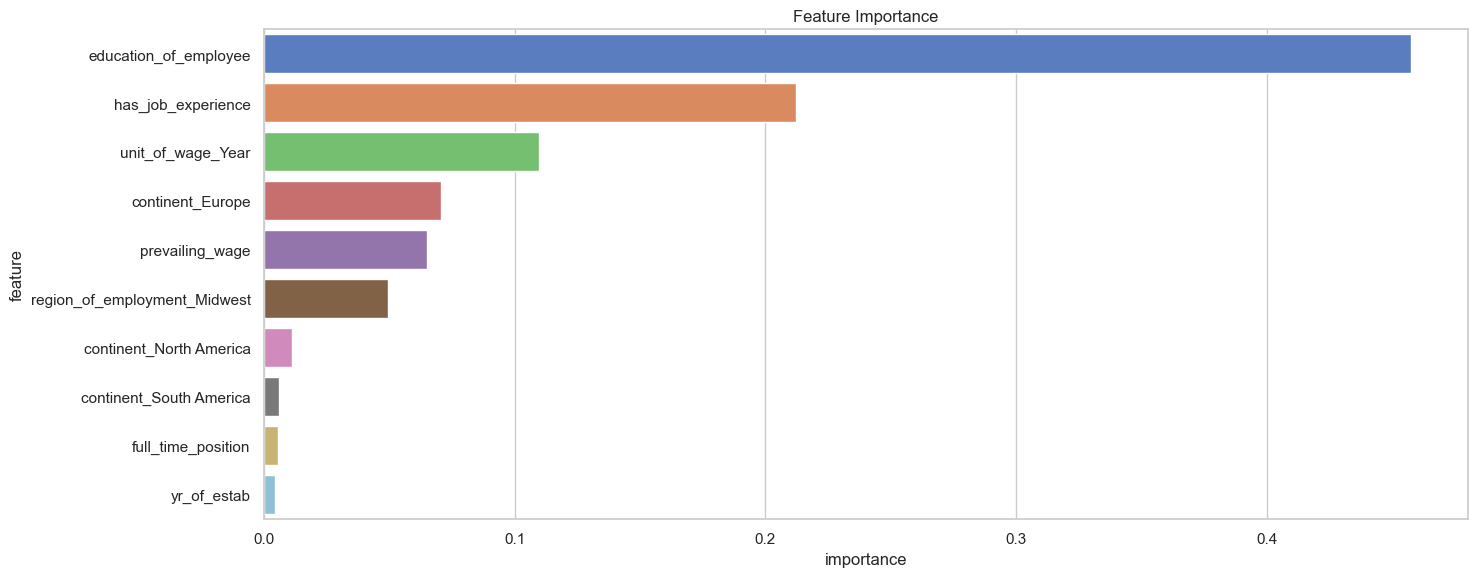

In [284]:
plot_feature_importance(feat_importances, top_n=10)

🔍 Observation

This aligns with immigration policy priorities that favor highly educated, experienced professionals, especially those in positions with annual salaries (typically higher-paying professional roles).

##### 5 Bagging Classifier

In [246]:
# Create pipeline
bagging_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        random_state=42,
        n_estimators=100,  # Number of base estimators
        max_samples=0.8,   # Each estimator gets 80% of samples
        max_features=0.8,  # Each estimator gets 80% of features
        bootstrap=True,    # Sample with replacement
        bootstrap_features=True,  # Sample features with replacement
        n_jobs=-1          # Use all available cores
    ))
])

# Fit the pipeline on training data
bagging_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = bagging_pipeline.predict(X_test)

In [247]:
bagging_result = get_classification_metrics(y_test, y_pred)
bagging_result

,Accuracy,Recall,Precision,F1
0,0.71,0.92,0.72,0.81


⚡ This is much better than Decision Tree (baseline) and at par with Decision Tree (Tuned)

In [248]:
results['bc'] = bagging_result

##### 6 Bagging Classifier + OverSampling

In [249]:
# Create pipeline
bagging_oversampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', oversampler),
    ('classifier', BaggingClassifier(
        random_state=42,
        n_estimators=100,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=-1
    ))
])

# Fit the pipeline on training data
bagging_oversampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = bagging_oversampled_pipeline.predict(X_test)

In [250]:
bagging_oversampled_result = get_classification_metrics(y_test, y_pred)
bagging_oversampled_result

,Accuracy,Recall,Precision,F1
0,0.71,0.79,0.77,0.78


👀 This is also not bad, but sometimes preserving the natural distribution leads to better models

In [251]:
results['bc_up'] = bagging_oversampled_result

##### 7. Bagging Classifier + UnderSampling

In [252]:
# Create pipeline
bagging_undersampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', undersampler),
    ('classifier', BaggingClassifier(
        random_state=42,
        n_estimators=100,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=-1
    ))
])

# Fit the pipeline on training data
bagging_undersampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = bagging_undersampled_pipeline.predict(X_test)

In [253]:
bagging_undersampled_result = get_classification_metrics(y_test, y_pred)
bagging_undersampled_result

,Accuracy,Recall,Precision,F1
0,0.68,0.69,0.80,0.74


In [254]:
results['bc_down'] = bagging_undersampled_result

Selected Pipeline:- Normal (without Sampling)

##### 8. Bagging Classifier (Tuning)

In [255]:
# Create stratified k-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the pipeline
bagging_tuning_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [10, 50, 100, 200],
    'classifier__max_samples': [0.5, 0.7, 1.0],
    'classifier__max_features': [0.5, 0.7, 1.0],
    'classifier__bootstrap': [True, False],
    'classifier__bootstrap_features': [True, False]
}

# Create grid search with stratified CV
grid_search = GridSearchCV(
    bagging_tuning_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(categories=[['High '
                                                                                                     'School',
                                                                                                     "Bachelor's",
                                                                                                     "Master's",
                                                                                                     'Doctorate'],
                                                                                                    ['Micro '
                                                                                                     '(1-50)',
                                                                                                     'Small '
                                                                                                     '(51-250)',
                                                                                                     'Medium '
                                                                                                     '(251-1000)',
                                                                                                     'Large '
                                                                                                     '(1001-10000)',
                                                                                                     'Enterpris...
                                                                         ['continent',
                                                                          'region_of_employment',
                                                                          'unit_of_wage'])])),
                                       ('classifier',
                                        BaggingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__bootstrap_features': [True, False],
                         'classifier__max_features': [0.5, 0.7, 1.0],
                         'classifier__max_samples': [0.5, 0.7, 1.0],
                         'classifier__n_estimators': [10, 50, 100, 200]},
             scoring='f1', verbose=1)

In [256]:
# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'classifier__bootstrap': True, 'classifier__bootstrap_features': False, 'classifier__max_features': 0.7, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 200}


In [257]:
# Create tuned model with best parameters
bagging_tuned_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            BaggingClassifier(
                random_state=42,
                **{remove_pipeline_step_prefix(k): v for k, v in best_params.items()},
            ),
        ),
    ]
)

# Fit tuned model
bagging_tuned_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = bagging_tuned_pipeline.predict(X_test)

In [258]:
bagging_tuned_result = get_classification_metrics(y_test, y_pred)
bagging_tuned_result

,Accuracy,Recall,Precision,F1
0,0.73,0.90,0.75,0.82


In [259]:
results['bc_tuned'] = bagging_tuned_result

🔍 Observation

The tuning has found a better balance point - trading a tiny bit of recall for meaningful gains in precision and overall accuracy. With 90% recall and 75% precision, this model is very well-balanced for visa application decisions, where both identifying qualified applicants and limiting false approvals are important.

#### 9. Random Forest

In [261]:
# Create pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1,           # Use all available cores
        class_weight='balanced'
    ))
])

# Fit the pipeline on training data
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_pipeline.predict(X_test)

In [262]:
rf_result = get_classification_metrics(y_test, y_pred)
rf_result

,Accuracy,Recall,Precision,F1
0,0.73,0.85,0.77,0.81


In [263]:
results['rf'] = rf_result

##### 10 Random Forest + Oversampling

In [264]:
# Create pipeline
rf_oversampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', oversampler),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# Fit the pipeline on training data
rf_oversampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_oversampled_pipeline.predict(X_test)

In [265]:
rf_oversampled_result = get_classification_metrics(y_test, y_pred)
rf_oversampled_result

,Accuracy,Recall,Precision,F1
0,0.70,0.76,0.78,0.77


🤔 Most of the time OverSampled Result remains almost same regardless of Technique used

In [266]:
results['rf_up'] = rf_oversampled_result

##### 11 Random Forest + Undersampling

In [270]:
# Create pipeline with preprocessing, undersampling, and random forest classifier
rf_undersampled_pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        ("sampler", undersampler),
        (
            "classifier",
            RandomForestClassifier(
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

# Fit the pipeline on training data
rf_undersampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_undersampled_pipeline.predict(X_test)

In [271]:
rf_undersampled_result = get_classification_metrics(y_test, y_pred)
rf_undersampled_result

,Accuracy,Recall,Precision,F1
0,0.68,0.67,0.81,0.74


🤔 Most of undersampled didnt show good results, comparatively

In [272]:
results['rf_down'] = rf_undersampled_result

Selected pipeline :- Dfault Random Forest (without Sampling)

##### 12 Random Forest (Tuning)

In [294]:
# Create stratified k-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the pipeline (using normal approach)
rf_tuning_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter distributions
param_distributions = {
    'classifier__n_estimators': randint(50, 500),
    'classifier__max_depth': [None] + list(randint(5, 50).rvs(5)),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
    'classifier__criterion': ['gini', 'entropy']
}

# Create randomized search with stratified CV
random_search = RandomizedSearchCV(
    rf_tuning_pipeline,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=stratified_cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit grid search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinal',
                                                                               OrdinalEncoder(categories=[['High '
                                                                                                           'School',
                                                                                                           "Bachelor's",
                                                                                                           "Master's",
                                                                                                           'Doctorate'],
                                                                                                          ['Micro '
                                                                                                           '(1-50)',
                                                                                                           'Small '
                                                                                                           '(51-250)',
                                                                                                           'Medium '
                                                                                                           '(251-1000)',
                                                                                                           'Large '
                                                                                                           '(1001-10000)',
                                                                                                           'Ent...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16d1847d0>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1698e5050>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16b2d7b10>},
                   random_state=42, scoring='f1', verbose=1)

In [295]:
# Get best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'classifier__bootstrap': False, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 237}


In [296]:
# Create tuned model with best parameters
rf_tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, **{remove_pipeline_step_prefix(k): v for k, v in best_params.items()}))
])

# Fit tuned model
rf_tuned_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_tuned_pipeline.predict(X_test)

In [297]:
rf_tuned_result = get_classification_metrics(y_test, y_pred)
rf_tuned_result

,Accuracy,Recall,Precision,F1
0,0.74,0.91,0.75,0.82


⚡ Not Significant, But still Decent

In [298]:
results['rf_tuned'] = rf_tuned_result

In [301]:
# Feature Importance
model = rf_tuned_pipeline.named_steps['classifier']
feat_importances = get_feature_importances(model, transformed_columns)
feat_importances

,feature,importance
0,education_of_employee,0.39
4,has_job_experience,0.16
21,prevailing_wage,0.14
18,unit_of_wage_Year,0.08
8,continent_Europe,0.05
12,region_of_employment_Midwest,0.03
19,no_of_employees,0.02
15,region_of_employment_West,0.02
20,yr_of_estab,0.02
7,continent_Asia,0.01


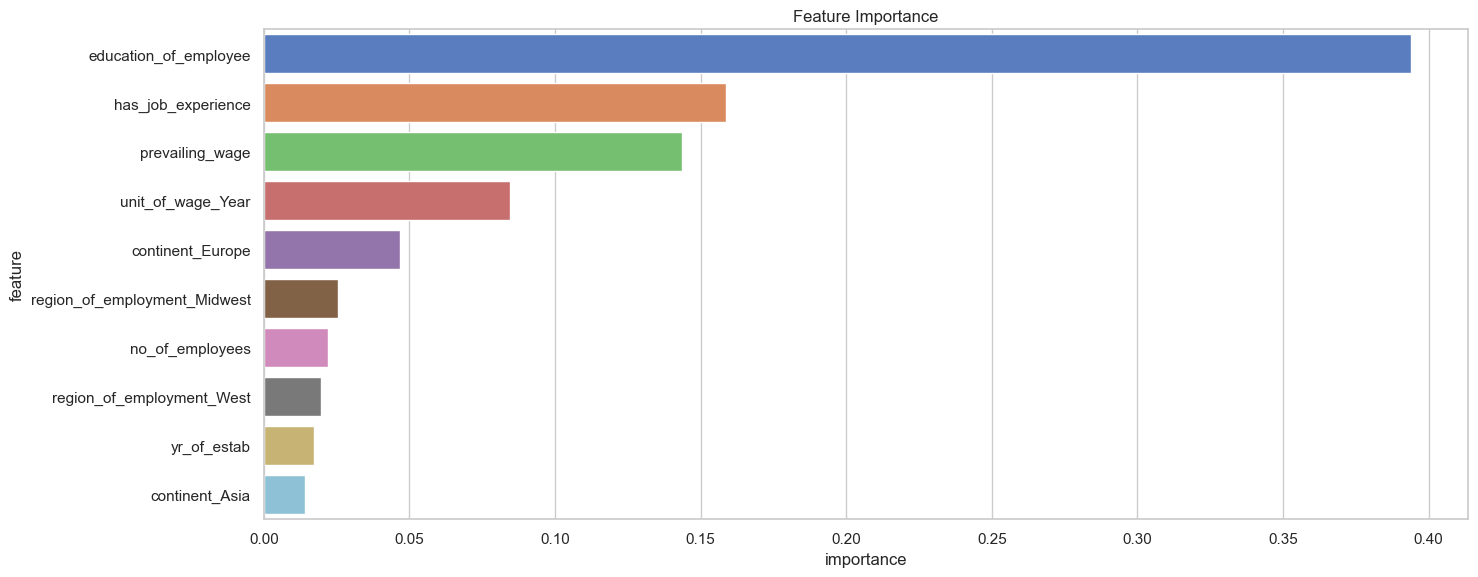

In [302]:
plot_feature_importance(feat_importances, top_n=10)

💡 This suggests:

The US visa system favors highly educated, experienced professionals with good salaries, especially those in traditional professional roles with annual compensation structures, regardless of what's company size and how old company is.

##### 13 AdaBoost

In [305]:
# Create pipeline
ada_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3),  # Using shallow trees as base estimators
        n_estimators=100,  # Number of estimators
        random_state=42
    ))
])

# Fit the pipeline on training data
ada_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = ada_pipeline.predict(X_test)

In [306]:
ada_result = get_classification_metrics(y_test, y_pred)
ada_result

,Accuracy,Recall,Precision,F1
0,0.71,0.83,0.76,0.79


In [307]:
results['ada'] = ada_result

##### 14 Adaboost + OverSampling

In [308]:
# Create pipeline
ada_oversampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', oversampler),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=100,
        learning_rate=1.0,
        random_state=42
    ))
])

# Fit the pipeline on training data
ada_oversampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = ada_oversampled_pipeline.predict(X_test)

In [309]:
ada_oversampled_result = get_classification_metrics(y_test, y_pred)
ada_oversampled_result

,Accuracy,Recall,Precision,F1
0,0.71,0.80,0.77,0.79


In [310]:
results['ada_up'] = ada_oversampled_result

##### 15 AdaBoost + DownSampling

In [311]:
# Create pipeline
ada_undersampled_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', undersampler),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=100,
        random_state=42
    ))
])

# Fit the pipeline on training data
ada_undersampled_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = ada_undersampled_pipeline.predict(X_test)

In [312]:
ada_undersampled_result = get_classification_metrics(y_test, y_pred)
ada_undersampled_result

,Accuracy,Recall,Precision,F1
0,0.67,0.67,0.80,0.73


In [313]:
results['ada_down'] = ada_undersampled_result

NOTE: 

Overall performance of Oversampling is similar to Default
So selecting Default one !!

##### 16 AdaBoost (Tuning)

In [314]:
# Create stratified k-fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the pipeline (using normal approach)
ada_tuning_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1), # Decision Stump
        random_state=42
    ))
])

# Define parameter distributions
param_distributions = {
    'classifier__n_estimators': randint(50, 300),
    'classifier__learning_rate': uniform(0.01, 0.99),  # From 0.01 to 1.0
    'classifier__base_estimator__max_depth': randint(1, 4),
    'classifier__base_estimator__min_samples_split': randint(2, 20),
    'classifier__base_estimator__min_samples_leaf': randint(1, 10),
    'classifier__algorithm': ['SAMME', 'SAMME.R']
}

# Create randomized search with stratified CV
random_search = RandomizedSearchCV(
    ada_tuning_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=stratified_cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit randomized search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nipunshah/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nipunshah/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nipunshah/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nipunshah/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/nipunshah/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be rem

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinal',
                                                                               OrdinalEncoder(categories=[['High '
                                                                                                           'School',
                                                                                                           "Bachelor's",
                                                                                                           "Master's",
                                                                                                           'Doctorate'],
                                                                                                          ['Micro '
                                                                                                           '(1-50)',
                                                                                                           'Small '
                                                                                                           '(51-250)',
                                                                                                           'Medium '
                                                                                                           '(251-1000)',
                                                                                                           'Large '
                                                                                                           '(1001-10000)',
                                                                                                           'Ent...
                                        'classifier__base_estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a385f90>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16a3e8c10>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a21f7d0>},
                   random_state=42, scoring='f1', verbose=1)

In [315]:
# Get best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'classifier__algorithm': 'SAMME', 'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__min_samples_leaf': 9, 'classifier__base_estimator__min_samples_split': 14, 'classifier__learning_rate': 0.86212327742378, 'classifier__n_estimators': 152}


In [316]:
# Create tuned model with best parameters
# Need to handle the base_estimator parameters separately
base_estimator_params = {k.replace('classifier__base_estimator__', ''): v
                         for k, v in best_params.items()
                         if k.startswith('classifier__base_estimator__')}

classifier_params = {k.replace('classifier__', ''): v
                     for k, v in best_params.items()
                     if not k.startswith('classifier__base_estimator__')}

# Remove base_estimator from classifier_params if it exists
if 'base_estimator' in classifier_params:
    del classifier_params['base_estimator']

# Create the tuned model
ada_tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(**base_estimator_params),
        random_state=42,
        **classifier_params
    ))
])

# Fit tuned model
ada_tuned_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = ada_tuned_pipeline.predict(X_test)

In [317]:
ada_tuned_result = get_classification_metrics(y_test, y_pred)
ada_tuned_result

,Accuracy,Recall,Precision,F1
0,0.74,0.88,0.76,0.82


✔️ Good Balanced Score

In [318]:
results['ada_tuned'] = ada_tuned_result

In [320]:
# Feature Importance
model = ada_tuned_pipeline.named_steps['classifier']
feat_importances = get_feature_importances(model, transformed_columns)
feat_importances

,feature,importance
0,education_of_employee,0.25
19,no_of_employees,0.20
4,has_job_experience,0.16
21,prevailing_wage,0.11
20,yr_of_estab,0.05
12,region_of_employment_Midwest,0.04
18,unit_of_wage_Year,0.04
6,full_time_position,0.03
13,region_of_employment_Northeast,0.03
8,continent_Europe,0.02


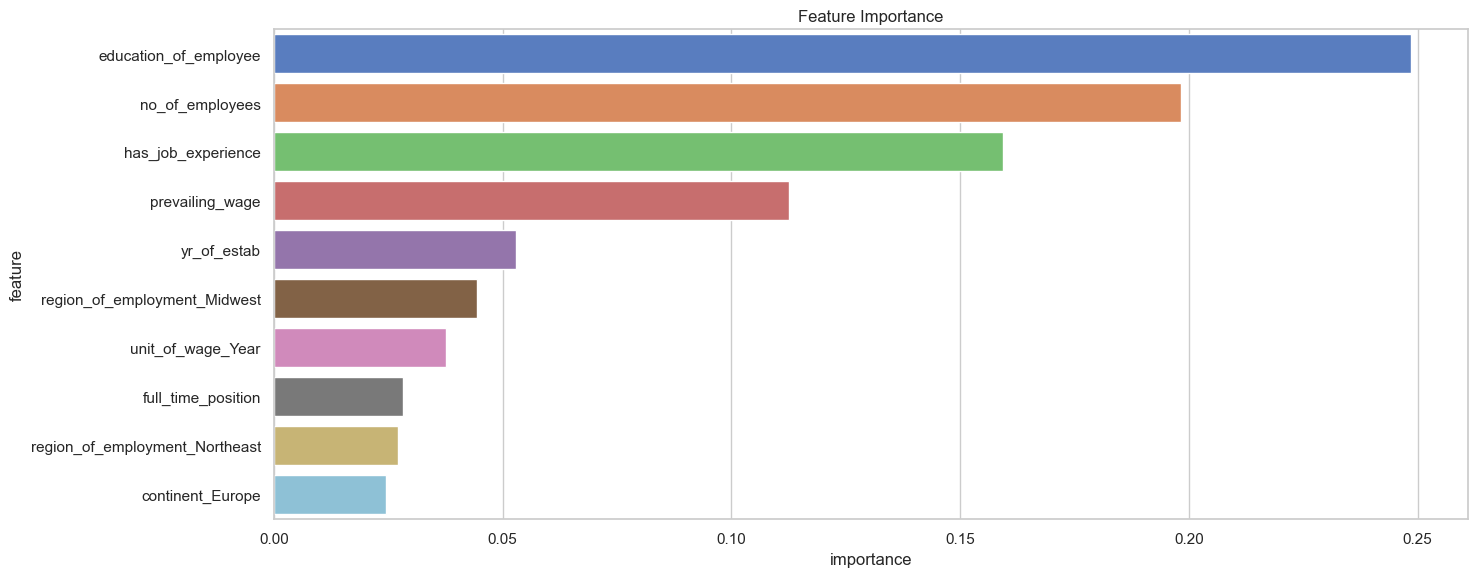

In [321]:
plot_feature_importance(feat_importances, top_n=10)

👀 Reckon: 

This suggests that AdaBoost has identified more nuanced patterns, particularly around the employer characteristics. While education and experience remain crucial, the model indicates that who you work for matters significantly - larger, established companies have better visa approval rates.